# Overview:

## Imports

In [ ]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GaussianNoise
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping


import calendar
import holidays

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Load Data Sets

In [ ]:
# Use pd.read_excel to load the file into a variable named climate_data.
climate_data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/ML final project/Final project/months_state_climate.xlsx')

# Utilize pd.read_csv to read the file into a variable named fips.
fips = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML final project/Final project/fips_state.csv')

# Read the train dataset from the CSV file using pd.read_csv and assign it to a variable named train.
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML final project/Final project/train.csv')

# Read the test dataset from the CSV file using pd.read_csv and assign it to a variable named test.
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML final project/Final project/test.csv')

train.drop(columns = ["Unnamed: 0"],inplace=True)

# We assume that the test data contains the STAT_CAUSE_DESCR column.
# Therefore, we first store this column in a separate variable for later use in calculating the weighted ROC-AUC.
test_y = test['STAT_CAUSE_DESCR']
test.drop(columns = ['Unnamed: 0', 'STAT_CAUSE_DESCR'],inplace=True)

fips = fips.groupby("STATE").mean().reset_index()

## EDA

In [ ]:
def conduct_eda(df, df_name):
    print("Shape of", df_name, ":", df.shape)
    print("\nFirst few rows of", df_name, ":")
    print(df.head())
    print("\nData types of columns in", df_name, ":")
    print(df.dtypes)
    print("\nDescriptive statistics of", df_name, ":")
    print(df.describe())
    print("\nNumber of missing values in each column of", df_name, ":")
    print(df.isnull().sum())

    numeric_features = df.select_dtypes(include=['number'])  # Select only numerical columns
    correlation_matrix = numeric_features.corr().round(2)  # Round the correlation values to 2 decimal places

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

    # Create a correlation heatmap using seaborn with masked upper triangle
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, mask=mask)
    plt.title('Correlation Heatmap of ' + df_name + ' (Lower Triangle)')
    plt.show()

Shape of climate_data : (52, 37)

First few rows of climate_data :
  State  high_01  low_01  prec_01  high_02  low_02  prec_02  high_03  low_03  \
0    AL     13.4     1.4     13.4     15.9     3.3     13.1     20.2     6.6   
1    AK    -11.8   -19.1      7.2     -8.8   -17.1      6.1     -6.0   -15.8   
2    AZ     13.2    -0.8      3.0     15.2     0.7      3.1     19.1     3.3   
3    AR     10.0    -0.9      9.7     12.6     1.0     10.1     17.4     5.0   
4    CA     12.6     1.7     10.5     14.1     2.4      9.9     16.8     4.0   

   prec_03  high_04  low_04  prec_04  high_05  low_05  prec_05  high_06  \
0     13.7     24.3    10.2     12.4     28.2    15.0     10.6     31.3   
1      5.4      1.7    -8.1      4.8      9.4    -0.4      5.4     15.5   
2      2.5     23.1     6.1      1.0     28.1    10.5      0.9     33.9   
3     12.7     22.5     9.6     13.8     26.6    14.7     13.9     30.8   
4      8.3     19.8     5.9      4.3     24.2     9.5      2.5     29.1   

 

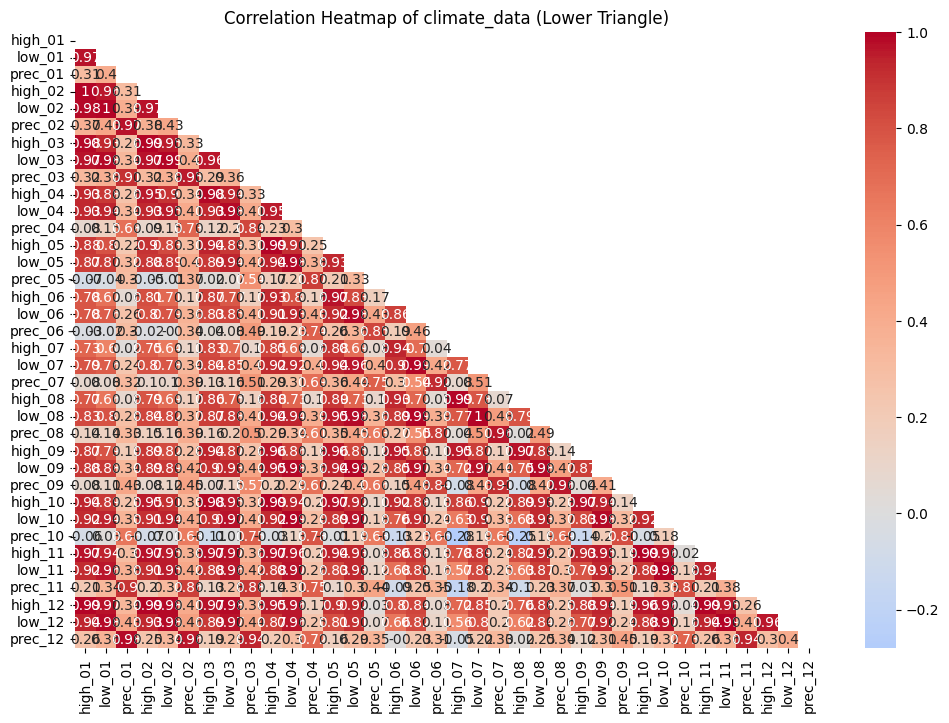

Shape of fips : (54, 3)

First few rows of fips :
  STATE   STCOUNTYFP  FIPS_COUNTY_CODE
0    AK  2153.517241        153.517241
1    AL  1067.000000         67.000000
2    AR  5075.000000         75.000000
3    AZ  4013.866667         13.866667
4    CA  6058.000000         58.000000

Data types of columns in fips :
STATE                object
STCOUNTYFP          float64
FIPS_COUNTY_CODE    float64
dtype: object

Descriptive statistics of fips :
         STCOUNTYFP  FIPS_COUNTY_CODE
count     54.000000         54.000000
mean   31417.677726         65.825874
std    18354.002776         53.981932
min     1067.000000          1.000000
25%    17349.500000         24.500000
50%    30574.500000         62.117188
75%    44785.750000         87.750000
max    78020.000000        263.992481

Number of missing values in each column of fips :
STATE               0
STCOUNTYFP          0
FIPS_COUNTY_CODE    0
dtype: int64


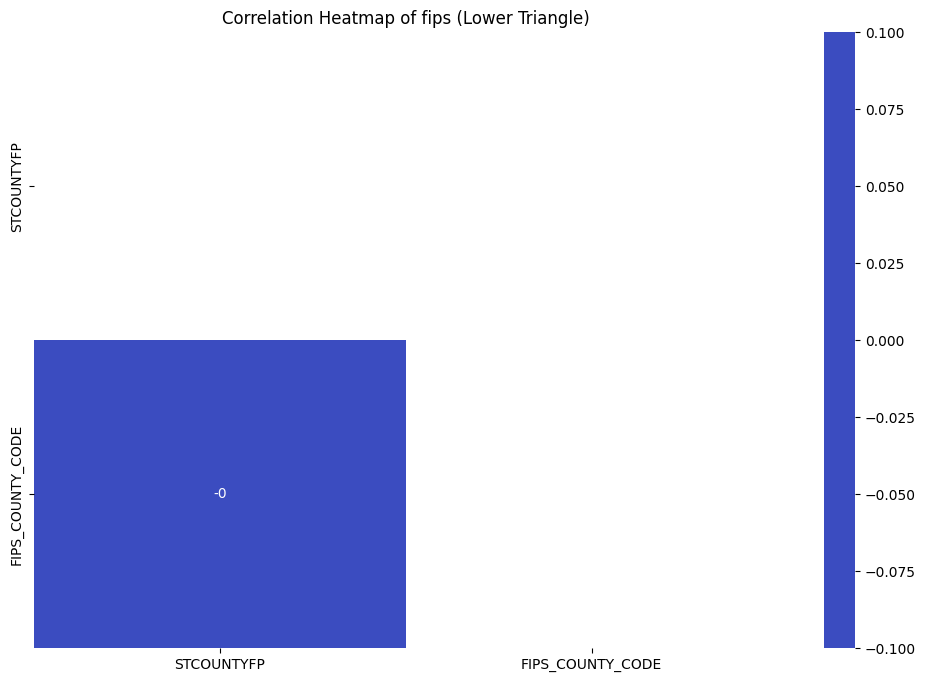

Shape of train : (399997, 38)

First few rows of train :
   OBJECTID     FOD_ID                                   FPA_ID  \
0   1350889    1830723                        SFO-NY-NYS-1998-1   
1     48567      48894                                FS-268149   
2   1828582  300248222  SFO-2015OH-OHS41-60133-P-112-10/17/2015   
3   1296156    1766921                SFO-NY-NY3659-2008-041802   
4   1681031  201845345                  SFO-2013FLFLS2013060495   

  SOURCE_SYSTEM_TYPE SOURCE_SYSTEM NWCG_REPORTING_AGENCY  \
0             NONFED       ST-NASF                ST/C&L   
1                FED   FS-FIRESTAT                    FS   
2             NONFED       ST-NASF                ST/C&L   
3             NONFED       ST-NASF                ST/C&L   
4             NONFED       ST-NASF                ST/C&L   

  NWCG_REPORTING_UNIT_ID              NWCG_REPORTING_UNIT_NAME  \
0                USNYNYS               New York Forest Rangers   
1                USCABDF        San Bernardino 

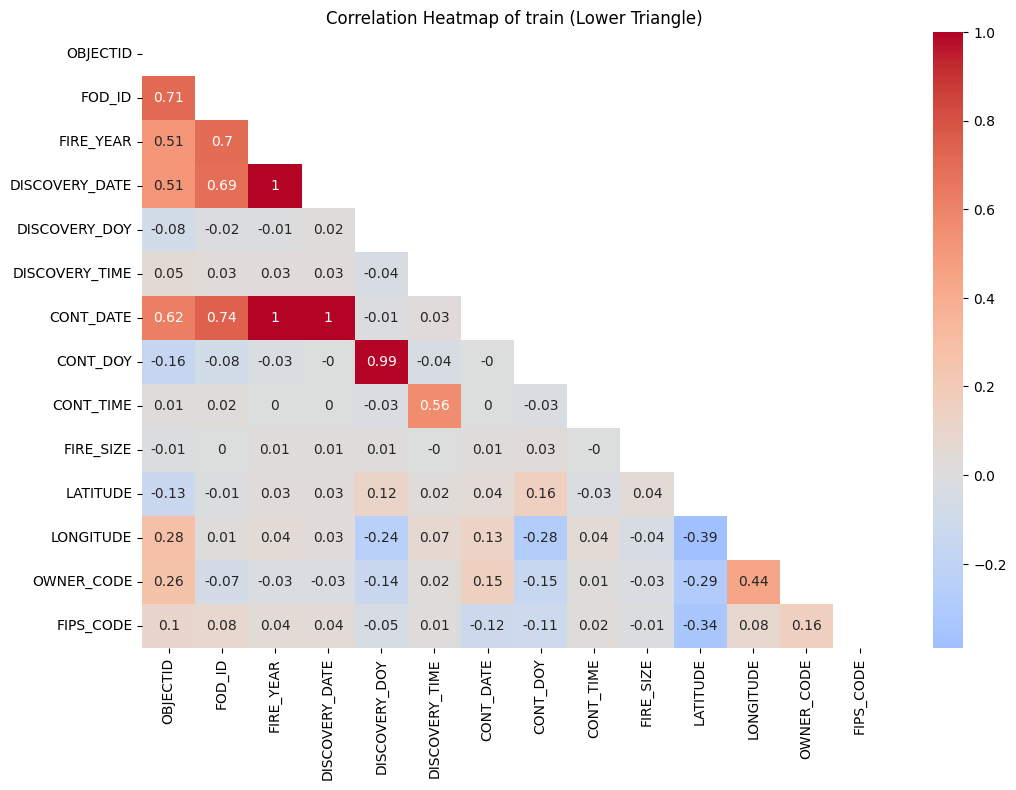

Shape of test : (114285, 37)

First few rows of test :
   OBJECTID     FOD_ID                  FPA_ID SOURCE_SYSTEM_TYPE  \
0    117164     118351               FS-343390                FED   
1    253707     258712                W-308087                FED   
2   1592487  201610403  SFO-WV-2012-2012-32598             NONFED   
3   1562520  201421362     TFS-TXFD2011-354831             NONFED   
4    916507    1043743           SWRA_SC_57374             NONFED   

  SOURCE_SYSTEM NWCG_REPORTING_AGENCY NWCG_REPORTING_UNIT_ID  \
0   FS-FIRESTAT                    FS                USCACNF   
1      DOI-WFMI                   BIA                USNDFTA   
2       ST-NASF                ST/C&L                USWVWVS   
3      ST-TXTXS                ST/C&L                USTXTXS   
4      ST-SCSCS                ST/C&L                USSCSCS   

             NWCG_REPORTING_UNIT_NAME SOURCE_REPORTING_UNIT  \
0           Cleveland National Forest                  0502   
1                  

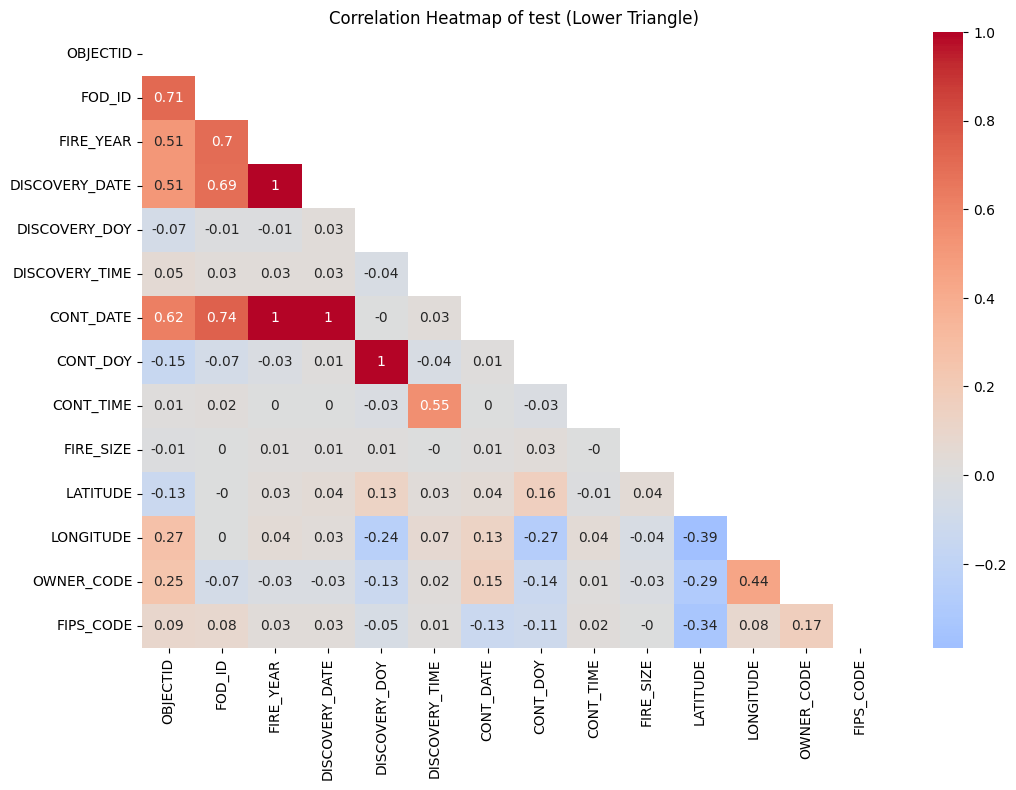

In [ ]:
# Apply the EDA function to each dataframe
dataframes = [climate_data, fips, train, test]
df_names = ["climate_data", "fips", "train", "test"]

for df, df_name in zip(dataframes, df_names):
    conduct_eda(df, df_name)

# Utility functions to clean the data

In [ ]:
def add_features(df):
  df['IS_LEAP_YEAR'] = df.FIRE_YEAR.apply(calendar.isleap).astype(int)
  discovery_date = pd.to_datetime(df.DISCOVERY_DATE, origin='julian', unit='D')
  df['DISCOVERY_MONTH'],df['DISCOVERY_DOW'] = discovery_date.dt.month,discovery_date.dt.dayofweek
  df['DURATION_IN_DAYS'] = df['CONT_DATE'] - df['DISCOVERY_DATE'] + 1
  us_holidays_dict = holidays.UnitedStates()
  df['IS_DISCOVERY_DATE_US_HOLIDAY'] = pd.to_datetime(discovery_date).apply(lambda x: 1 if x in us_holidays_dict else 0)

  df = add_climate(df)
  return df

def add_climate(df):
  # Initialize an empty dictionary to store the JSON data
  data = {}

  # Iterate over each row in the DataFrame
  for index, row in climate_data.iterrows():
      state = row['State']
      state_data = {}

      # Iterate over each column (excluding the 'State' column)
      for column in climate_data.columns[1:]:
          month, attribute = column.split('_') # Extract month and attribute from column name
          if state not in data:
              data[state] = {}
          data[state][f"{attribute}_{month}"] = row[column]
  data_list = []

  # Iterate over each state's data
  for state, state_data in data.items():
      # Iterate over each month's data
      for month in range(1, 13):
          # Extract the values for high, low, and prec for the current month
          high = state_data.get(f"{month:02d}_high", None)
          low = state_data.get(f"{month:02d}_low", None)
          prec = state_data.get(f"{month:02d}_prec", None)

          # Append the values to the list as a tuple
          data_list.append((state, month, high, low, prec))

  # Create a DataFrame from the list
  data_countries = pd.DataFrame(data_list, columns=['STATE', 'MONTH', 'HighTempMonth', 'LowTempMonth', 'PrecMonth'])
  discovery_date = pd.to_datetime(df.DISCOVERY_DATE, origin='julian', unit='D')
  df['MONTH'] = discovery_date.dt.month
  df = df.merge(data_countries, on=['STATE', 'MONTH'], how='left')
  # return merged_df
  return df

def make_features_cyclic(df):

  def make_cyclic(value,cycle_length):
    cyc_val = 2 * np.pi * value / cycle_length
    return np.sin(cyc_val),np.cos(cyc_val)

  df['DISCOVERY_DOY_SIN'],df['DISCOVERY_DOY_COS'] = zip(*pd.Series(zip(df['DISCOVERY_DOY'], df['IS_LEAP_YEAR'])).apply(lambda x:make_cyclic(x[0],365+x[1])))
  df['DISCOVERY_MONTH_SIN'],df['DISCOVERY_MONTH_COS'] = zip(*df["DISCOVERY_MONTH"].apply(lambda x:make_cyclic(x,12)))
  df['DISCOVERY_DOW_SIN'],df['DISCOVERY_DOW_COS'] = zip(*df['DISCOVERY_DOW'].apply(lambda x: make_cyclic(x,7)))
  return df


def remove_unnecessary_features(df):
  # remove date fields
  df.drop(columns=['CONT_DATE','DISCOVERY_DATE','CONT_DOY'
                          ,'DISCOVERY_DOY','DISCOVERY_MONTH'],inplace=True)
  # remove ids
  df.drop(columns=['OBJECTID','FOD_ID','FPA_ID','LOCAL_FIRE_REPORT_ID'
                  ,'LOCAL_INCIDENT_ID','FIRE_CODE','FIRE_NAME'
                  ,'ICS_209_INCIDENT_NUMBER','ICS_209_NAME','MTBS_ID'
                  ,'MTBS_FIRE_NAME','COMPLEX_NAME','OWNER_CODE'
                  ,'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID'
                  ,'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT'
                  ,'SOURCE_REPORTING_UNIT_NAME','SOURCE_SYSTEM_TYPE'
                  ],inplace=True)

  # remove geo fields
  df.drop(columns=['Shape','COUNTY','FIPS_NAME'],inplace=True)
  return df

# Add missing fields and change data format of train set



In [ ]:
# Assuming 'train' is your DataFrame
train['DISCOVERY_MINS_FROM_MIDNIGHT'] = train['DISCOVERY_TIME'].apply(lambda x: (x // 100) * 60 + x % 100)
train['CONT_MINS_FROM_MIDNIGHT'] = train['CONT_TIME'].apply(lambda x: (x // 100) * 60 + x % 100)

discovery_time_state_means = train.groupby('STATE')['DISCOVERY_MINS_FROM_MIDNIGHT'].mean().apply(lambda x: (x // 60) * 100 + x % 60)
cont_time_state_means = train.groupby('STATE')['CONT_MINS_FROM_MIDNIGHT'].mean().apply(lambda x: (x // 60) * 100 + x % 60)

train.drop(columns=['DISCOVERY_MINS_FROM_MIDNIGHT', 'CONT_MINS_FROM_MIDNIGHT'], inplace=True)

# Fill missing values in 'DISCOVERY_TIME' and 'CONT_TIME' with group-wise means
train['DISCOVERY_TIME'] = train.apply(
    lambda row: row['DISCOVERY_TIME'] if pd.notna(row['DISCOVERY_TIME'])
    else discovery_time_state_means[row['STATE']], axis=1
)
# Assuming self.imputer is your imputer method
train['DISCOVERY_TIME'] = train['DISCOVERY_TIME'].fillna(train.groupby('STATE')['DISCOVERY_TIME'].transform('mean'))
train['CONT_TIME'] = train.apply(
    lambda row: row['CONT_TIME'] if pd.notna(row['CONT_TIME'])
    else cont_time_state_means[row['STATE']], axis=1
)
# Assuming self.imputer is your imputer method
train['CONT_TIME'] = train['CONT_TIME'].fillna(train.groupby('STATE')['CONT_TIME'].transform('mean'))

# fill FIPS
train = train.merge(fips,how='left',on='STATE')
train["FIPS"] = train.apply(lambda row: row["FIPS_COUNTY_CODE"] if pd.isna(row["FIPS_CODE"]) else row["FIPS_CODE"],axis=1)
train.drop(columns=['FIPS_CODE','FIPS_COUNTY_CODE','STCOUNTYFP'],inplace=True)
train.rename(columns={'FIPS': 'FIPS_CODE'}, inplace=True)

# Add featrues to train set

In [ ]:
train = add_features(train)

# Add values to train set

In [ ]:
# Group by 'STATE' and 'FIRE_SIZE_CLASS' and fill missing values in 'DURATION_IN_DAYS' based on group-wise mean
train['DURATION_IN_DAYS'] = train.groupby(['STATE', 'FIRE_SIZE_CLASS'])['DURATION_IN_DAYS'].transform(lambda x: x.fillna(x.mean()))
# Use the imputer for any remaining missing values
train['DURATION_IN_DAYS'].fillna(train['DURATION_IN_DAYS'].mean(), inplace=True)

duration_means = train.groupby(['STATE', 'FIRE_SIZE_CLASS'])['DURATION_IN_DAYS'].transform(lambda x: x.fillna(x.mean()))

In [ ]:
train = make_features_cyclic(train)

In [ ]:
train = remove_unnecessary_features(train)

# Create Dummies for test

In [ ]:
categorical_columns = ['SOURCE_SYSTEM','OWNER_DESCR', 'STATE']

ohe = ColumnTransformer([('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_columns)], remainder="passthrough")
ohe.fit(df[categorical_columns])

# Transform the training data
df_encoded = ohe.transform(df[categorical_columns])

# Check transformed data

feature_names = ohe.transformers_[0][1].get_feature_names_out(categorical_columns).reshape(-1, 1)
feature_names = [name for sublist in feature_names for name in sublist]

encoded_df = pd.DataFrame.sparse.from_spmatrix(df_encoded)
encoded_df.columns = feature_names

# Concatenate with the remaining non-categorical columns
encoded_df = pd.concat([encoded_df, df.drop(categorical_columns, axis=1)], axis=1)

Shape of train : (399997, 26)

First few rows of train :
  SOURCE_SYSTEM  FIRE_YEAR  DISCOVERY_TIME STAT_CAUSE_DESCR    CONT_TIME  \
0       ST-NASF       1998     1516.278903   Debris Burning  1523.752427   
1   FS-FIRESTAT       1992     1142.000000    Miscellaneous  1800.000000   
2       ST-NASF       2015     1258.000000   Debris Burning  1325.000000   
3       ST-NASF       2008     1110.000000   Debris Burning  1110.000000   
4       ST-NASF       2013     1345.000000   Debris Burning  1404.000000   

   FIRE_SIZE FIRE_SIZE_CLASS   LATITUDE   LONGITUDE            OWNER_DESCR  \
0       1.00               B  41.586317  -74.494453  MISSING/NOT SPECIFIED   
1    1150.00               F  33.666667 -116.953333  MISSING/NOT SPECIFIED   
2       0.01               A  39.829791  -82.192117                PRIVATE   
3       1.36               B  41.343354  -74.170421  MISSING/NOT SPECIFIED   
4       1.00               B  30.497100  -83.148800                PRIVATE   

  STATE  FIPS_COD

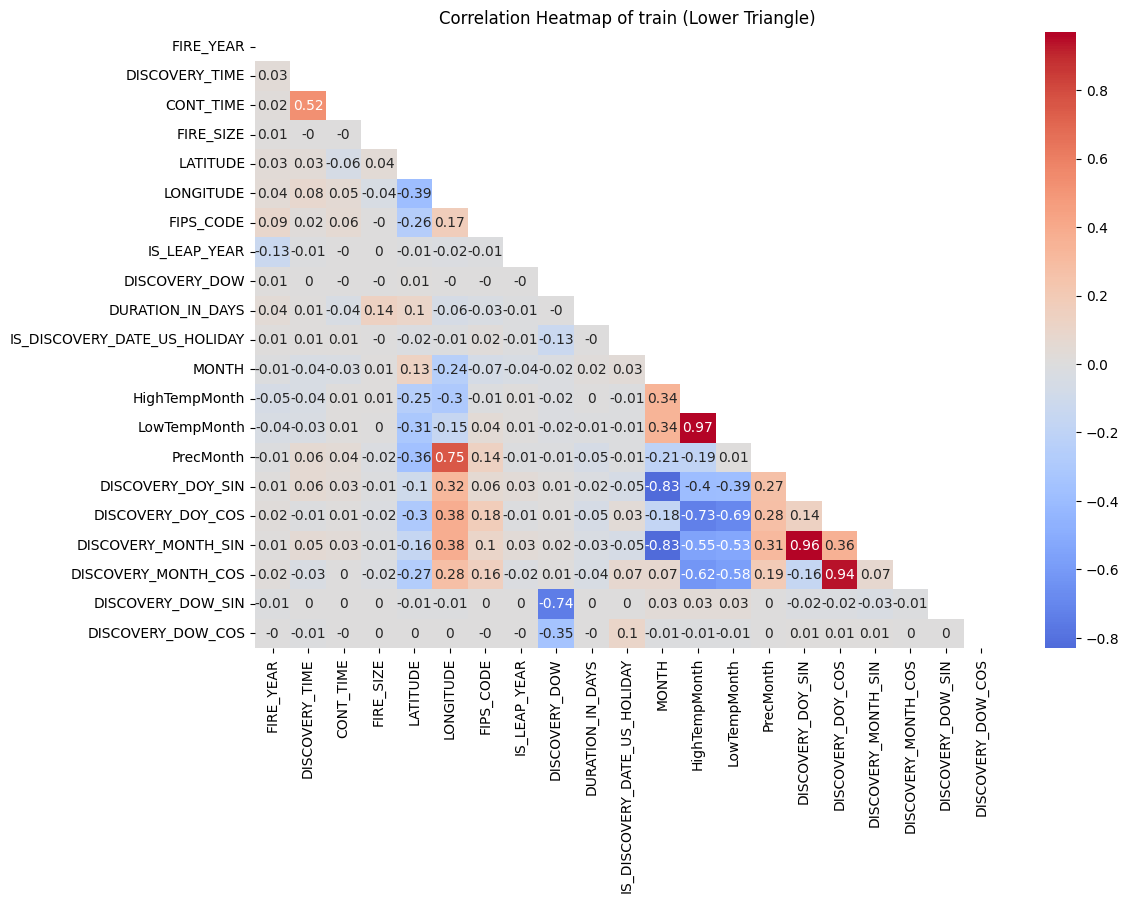

In [ ]:
conduct_eda(train,"train")

# Add missing fields and change data format of test set

In [ ]:
discovery_train_means = pd.Series(discovery_time_state_means)
cont_train_means = pd.Series(cont_time_state_means)


# Fill missing values in 'DISCOVERY_TIME' with mean values calculated during training
# Use state-specific mean if available, otherwise use overall mean
test['DISCOVERY_TIME'] = test.apply(
    lambda row: row['DISCOVERY_TIME'] if pd.notna(row['DISCOVERY_TIME'])
    else discovery_time_state_means.get(row['STATE'], discovery_train_means.iloc[0]), axis=1
)

# Fill missing values in 'CONT_TIME' with mean values calculated during training
# Use state-specific mean if available, otherwise use overall mean
test['CONT_TIME'] = test.apply(
    lambda row: row['CONT_TIME'] if pd.notna(row['CONT_TIME'])
    else cont_time_state_means.get(row['STATE'], cont_train_means.iloc[0]), axis=1
)

# Fill 'FIPS_CODE' with available data from 'FIPS_COUNTY_CODE' if 'FIPS_CODE' is missing
# Drop redundant columns and rename 'FIPS' column
test = test.merge(fips, how='left', on='STATE')
test["FIPS_CODE"] = test.apply(lambda row: row["FIPS_COUNTY_CODE"] if pd.isna(row["FIPS_CODE"]) else row["FIPS_CODE"], axis=1)
test.drop(columns=['FIPS_COUNTY_CODE', 'STCOUNTYFP'], inplace=True)
test.rename(columns={'FIPS': 'FIPS_CODE'}, inplace=True)

# Add fetrues to test set

In [ ]:
test = add_features(test)

In [ ]:
duration_train_means = pd.Series(duration_means)

test['DURATION_IN_DAYS'].fillna(duration_train_means.iloc[0], inplace=True)

In [ ]:
test = make_features_cyclic(test)

In [ ]:
test = remove_unnecessary_features(test)

# Create Dummies for test

In [ ]:
categorical_columns = ['SOURCE_SYSTEM','OWNER_DESCR', 'STATE']

# Transform the training data
df_encoded = ohe.transform(df[categorical_columns])

encoded_df = pd.DataFrame.sparse.from_spmatrix(df_encoded)
encoded_df.columns = feature_names

# Concatenate with the remaining non-categorical columns
encoded_df = pd.concat([encoded_df, df.drop(categorical_columns, axis=1)], axis=1)

#Frequency analysis

In [ ]:
train = train[train['DURATION_IN_DAYS'] <= 270]
train = train[train['FIRE_SIZE'] <= 200000]

Frequency Analysis - FIRE_YEAR :
 FIRE_YEAR
2006    24330
2000    22284
1999    20349
2001    19519
2007    18838
2011    17812
2005    17787
2008    17618
2002    17023
2010    16954
2009    16267
2012    16159
2015    15871
1998    15471
1996    15435
1994    15311
2014    14784
2004    14737
1995    14552
2013    14291
2003    14152
1992    13986
1997    13911
1993    12515
Name: count, dtype: int64 



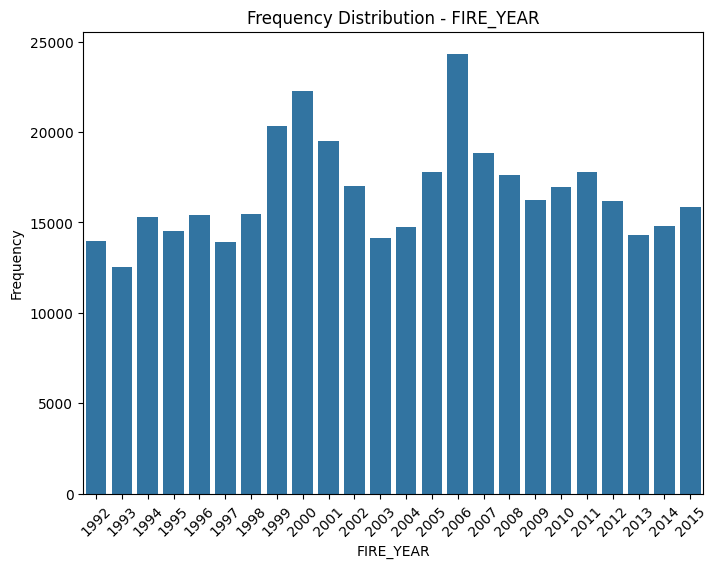

<Figure size 1200x600 with 0 Axes>

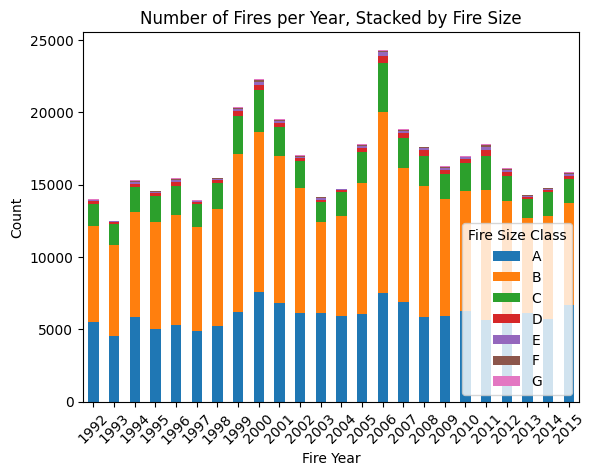

In [ ]:
# Frequency analysis
freq_counts = train['FIRE_YEAR'].value_counts()
print("Frequency Analysis -", 'FIRE_YEAR', ":\n", freq_counts, "\n")

# Plot the frequency distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=train, x='FIRE_YEAR')
plt.title("Frequency Distribution - " + 'FIRE_YEAR')
plt.xlabel('FIRE_YEAR')
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

# Aggregate the count of fires for each combination of 'FIRE_YEAR' and 'FIRE_SIZE_CLASS'
fire_counts = train.groupby(['FIRE_YEAR', 'FIRE_SIZE_CLASS']).size().reset_index(name='count')

# Pivot the data to have 'FIRE_SIZE_CLASS' as columns and 'count' as values
fire_counts_pivot = fire_counts.pivot(index='FIRE_YEAR', columns='FIRE_SIZE_CLASS', values='count').fillna(0)

# Plot a stacked bar plot with different colors representing different fire sizes
plt.figure(figsize=(12, 6))
fire_counts_pivot.plot(kind='bar', stacked=True)
plt.title('Number of Fires per Year, Stacked by Fire Size')
plt.xlabel('Fire Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Fire Size Class')
plt.show()

In [ ]:
# Specify the columns for frequency analysis
columns_to_analyze = ['FIRE_SIZE','FIRE_YEAR','DISCOVERY_TIME','CONT_TIME','FIRE_SIZE',
                      'DURATION_IN_DAYS','HighTempMonth','LowTempMonth',
                      'MONTH','DISCOVERY_DOW']

Using scatter plots to visualize the relationship between temperature variables and fire-related variables can provide a more direct representation of the data points and their distribution. Here's what each scatter plot can potentially explain:

Fire Size vs. Temperature:

High Temperature of the Month: A scatter plot of fire size against high temperatures can visually show the trend of fire size as temperatures increase. You can observe if there's a general trend of larger fires occurring during hotter months or if there are outliers that deviate from this trend.
Low Temperature of the Month: Similarly, a scatter plot of fire size against low temperatures can reveal any patterns or trends in fire size as temperatures decrease. This plot might show smaller fires occurring during colder months
compared to warmer months.
Fire Duration vs. Temperature:

High Temperature of the Month: A scatter plot of fire duration against high temperatures can illustrate the relationship between fire duration and temperature. You can observe if there's a tendency for longer fire durations during hotter months or if there are variations in fire duration at different temperature levels.
Low Temperature of the Month: Similarly, a scatter plot of fire duration against low temperatures can show how fire duration varies with cooler temperatures. This plot might indicate shorter fire durations during colder months compared to warmer months.
By visually inspecting these scatter plots, you can identify any patterns, trends, or correlations between temperature variables and fire-related variables. Scatter plots allow for a direct visualization of the data points and can provide insights into the relationship between temperature and fire behavior. Additionally, you can use techniques such as regression analysis or correlation coefficients to quantitatively measure the strength and direction of these relationships.

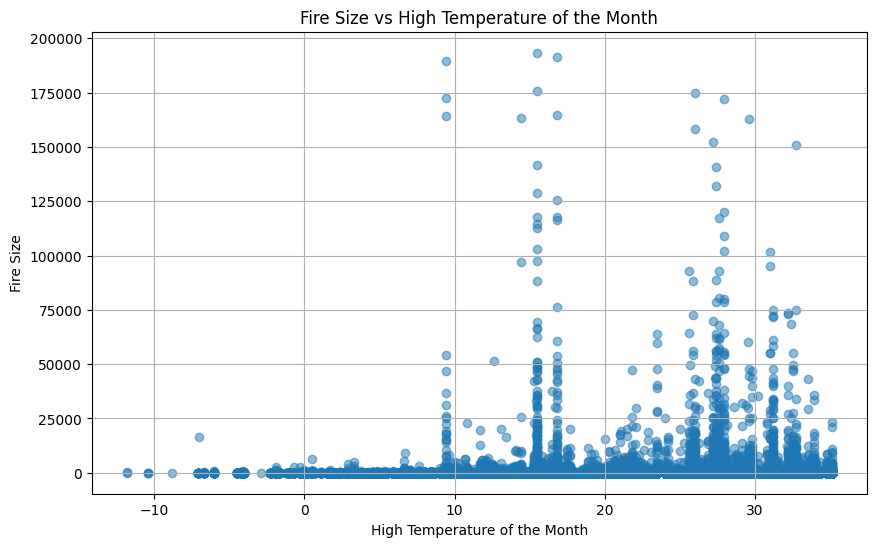

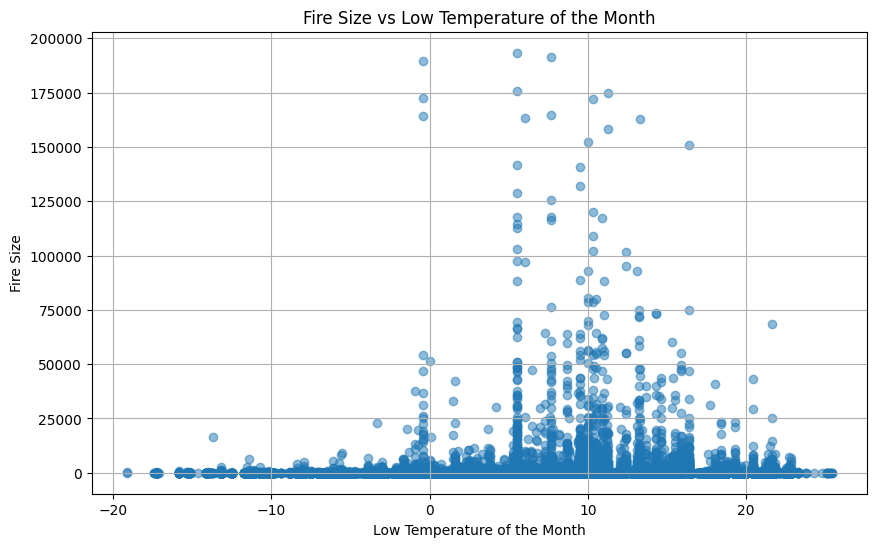

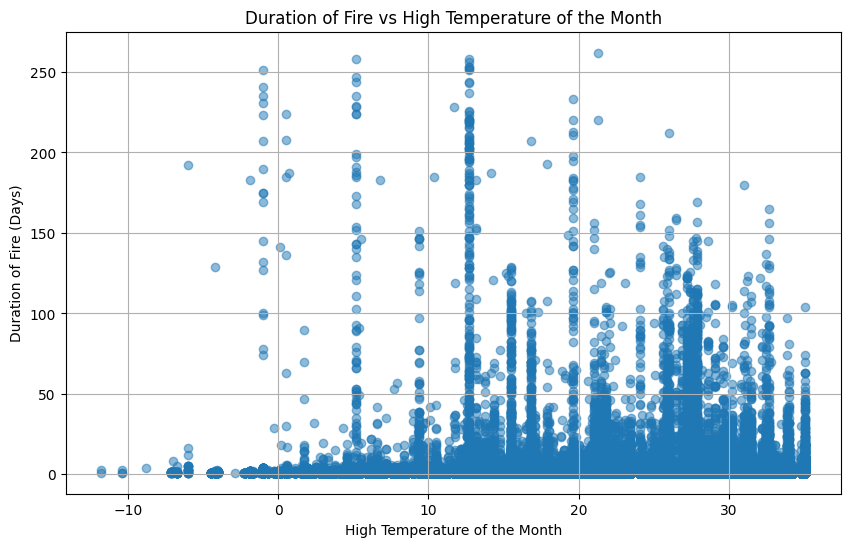

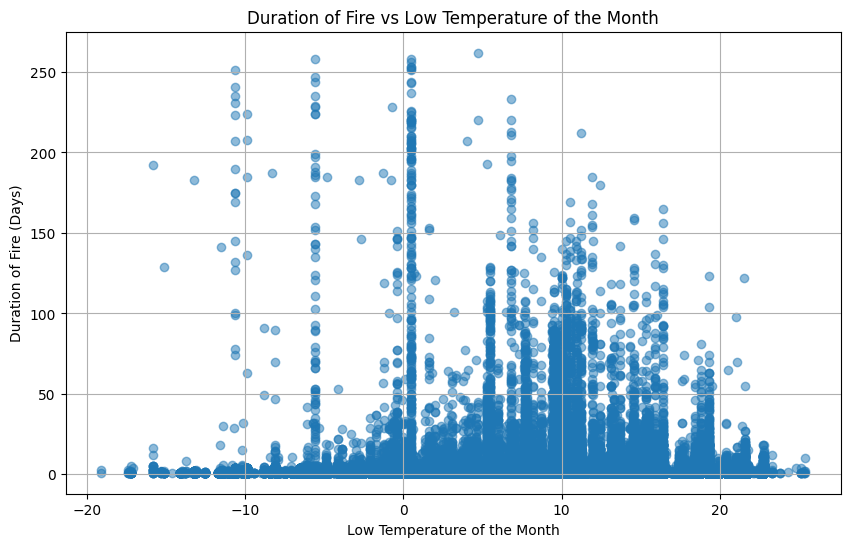

In [ ]:
# Scatter plot for Fire_SIZE vs HighTempMonth
plt.figure(figsize=(10, 6))
plt.scatter(train['HighTempMonth'], train['FIRE_SIZE'], alpha=0.5)
plt.title('Fire Size vs High Temperature of the Month')
plt.xlabel('High Temperature of the Month')
plt.ylabel('Fire Size')
plt.grid(True)
plt.show()

# Scatter plot for Fire_SIZE vs LowTempMonth
plt.figure(figsize=(10, 6))
plt.scatter(train['LowTempMonth'], train['FIRE_SIZE'], alpha=0.5)
plt.title('Fire Size vs Low Temperature of the Month')
plt.xlabel('Low Temperature of the Month')
plt.ylabel('Fire Size')
plt.grid(True)
plt.show()

# Scatter plot for DURATION_IN_DAYS vs HighTempMonth
plt.figure(figsize=(10, 6))
plt.scatter(train['HighTempMonth'], train['DURATION_IN_DAYS'], alpha=0.5)
plt.title('Duration of Fire vs High Temperature of the Month')
plt.xlabel('High Temperature of the Month')
plt.ylabel('Duration of Fire (Days)')
plt.grid(True)
plt.show()

# Scatter plot for DURATION_IN_DAYS vs LowTempMonth
plt.figure(figsize=(10, 6))
plt.scatter(train['LowTempMonth'], train['DURATION_IN_DAYS'], alpha=0.5)
plt.title('Duration of Fire vs Low Temperature of the Month')
plt.xlabel('Low Temperature of the Month')
plt.ylabel('Duration of Fire (Days)')
plt.grid(True)
plt.show()


# Outlier Detection

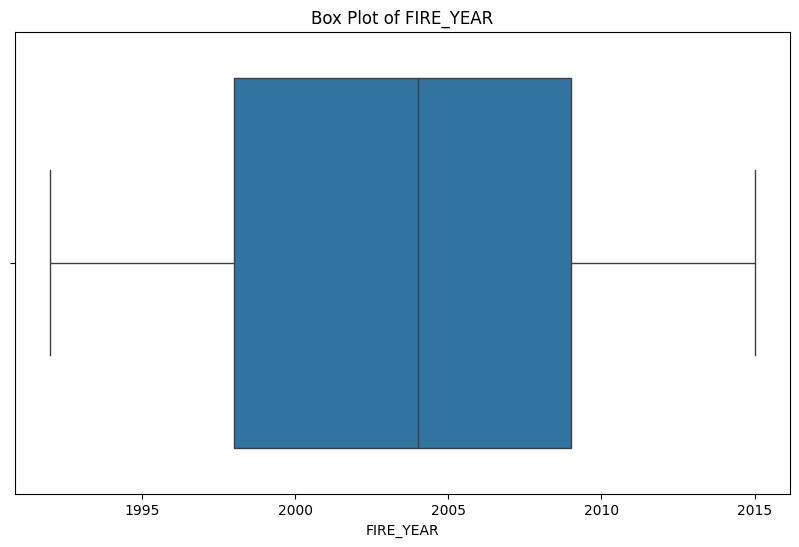

Number of outliers in 'FIRE_YEAR': 0


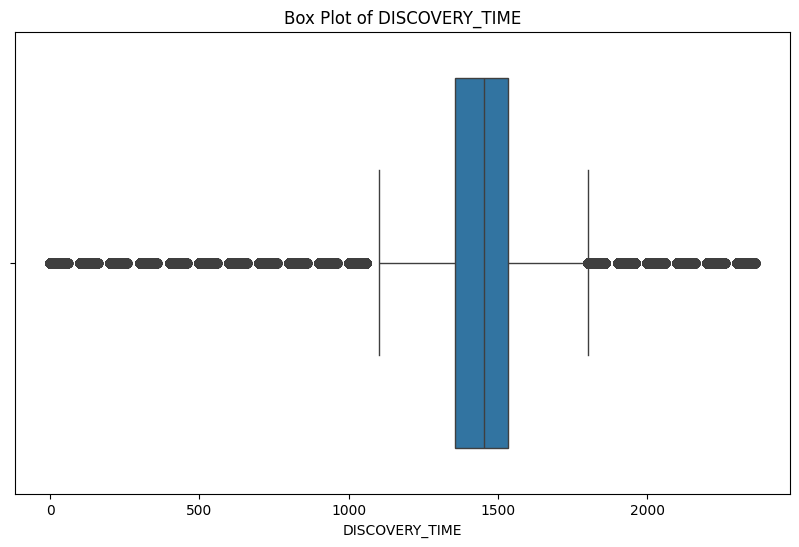

Number of outliers in 'DISCOVERY_TIME': 70048


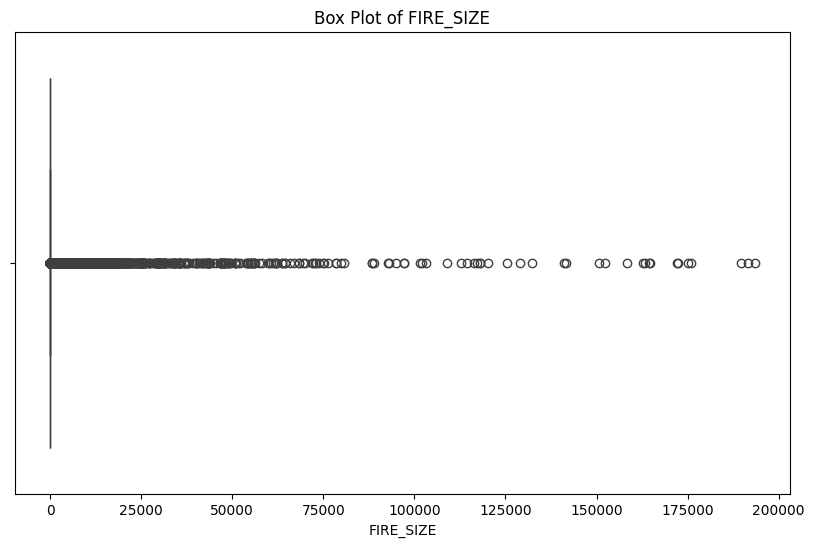

Number of outliers in 'FIRE_SIZE': 63927


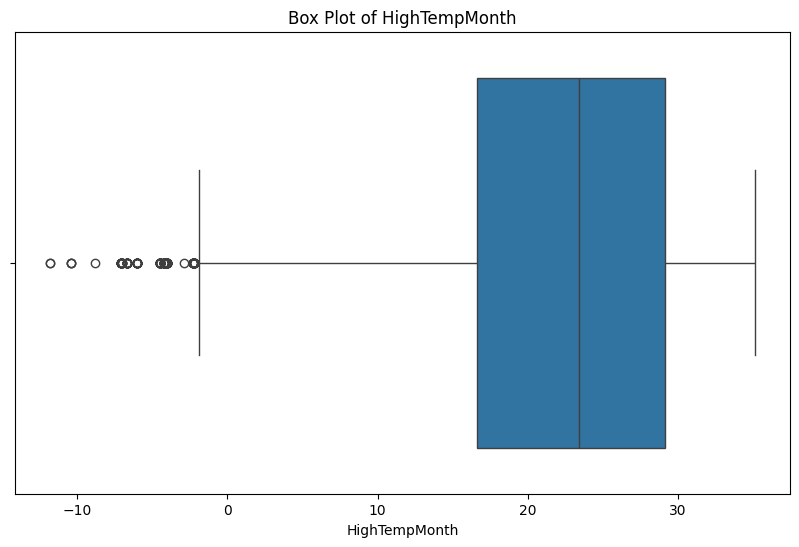

Number of outliers in 'HighTempMonth': 226


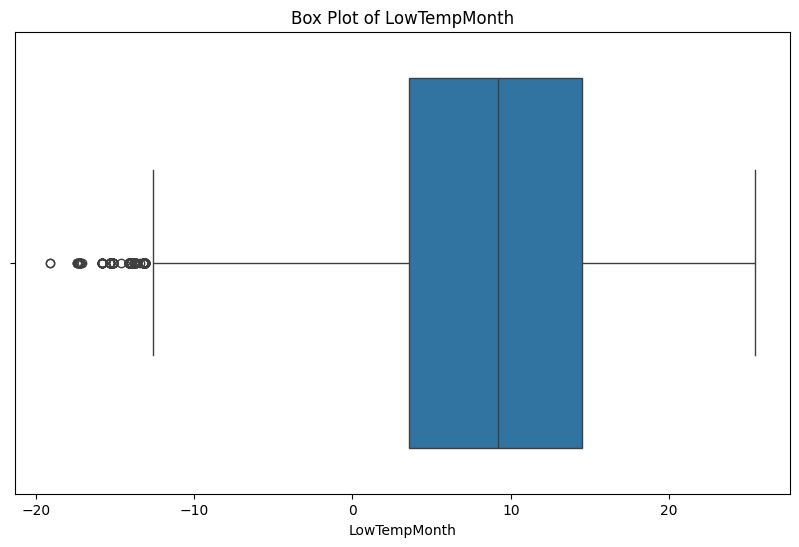

Number of outliers in 'LowTempMonth': 389


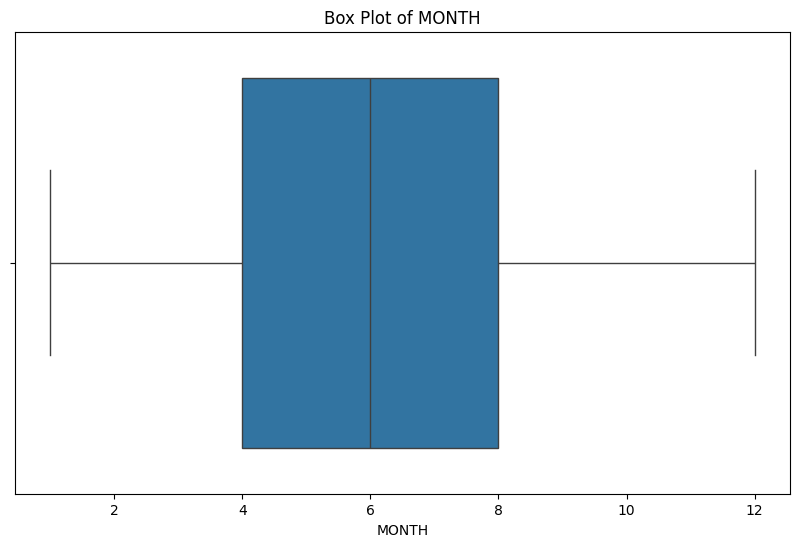

Number of outliers in 'MONTH': 0


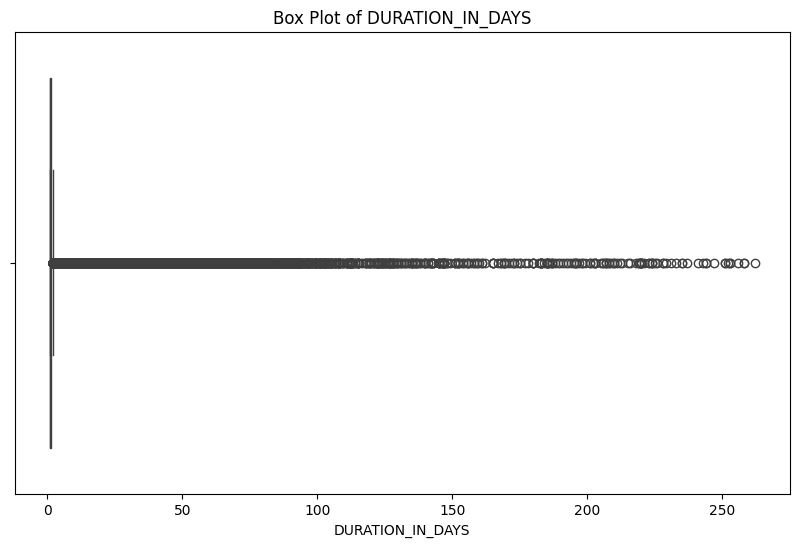

Number of outliers in 'DURATION_IN_DAYS': 39985


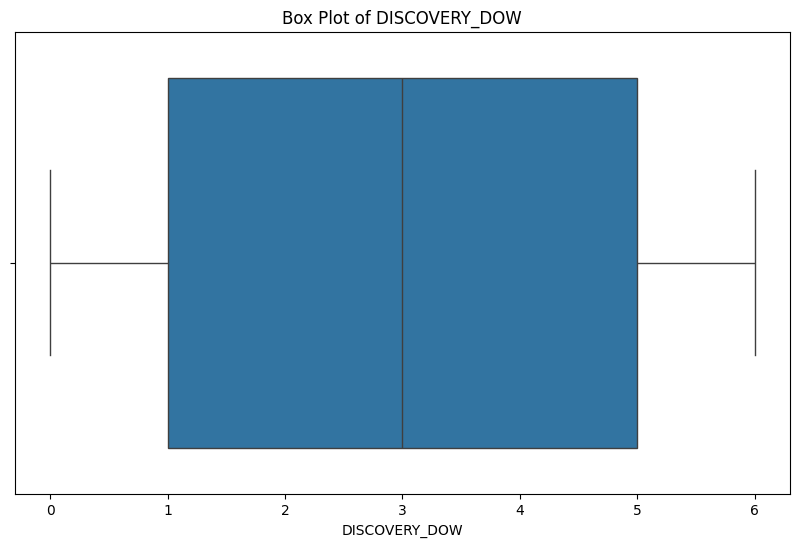

Number of outliers in 'DISCOVERY_DOW': 0


In [ ]:
# Preprocessing numeric features
# Specify the columns for frequency analysis
numeric_features = ['FIRE_YEAR','DISCOVERY_TIME','FIRE_SIZE',
                    'HighTempMonth','LowTempMonth',
                    'MONTH', 'DURATION_IN_DAYS','DISCOVERY_DOW']

# Iterate over numerical columns
for column in numeric_features:
    # Calculate quartiles and interquartile range (IQR)
    quartile1 = train[column].quantile(0.25)
    quartile3 = train[column].quantile(0.75)
    iqr = quartile3 - quartile1

    # Define the outlier boundaries
    lower_bound = quartile1 - 1.5 * iqr
    upper_bound = quartile3 + 1.5 * iqr

    # Find outliers
    outliers = train[(train[column] < lower_bound) | (train[column] > upper_bound)]

    # Visualize outliers using a box plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=train[column])
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)
    plt.show()

    # Print the number of outliers
    num_outliers = len(outliers)
    print(f"Number of outliers in '{column}': {num_outliers}")

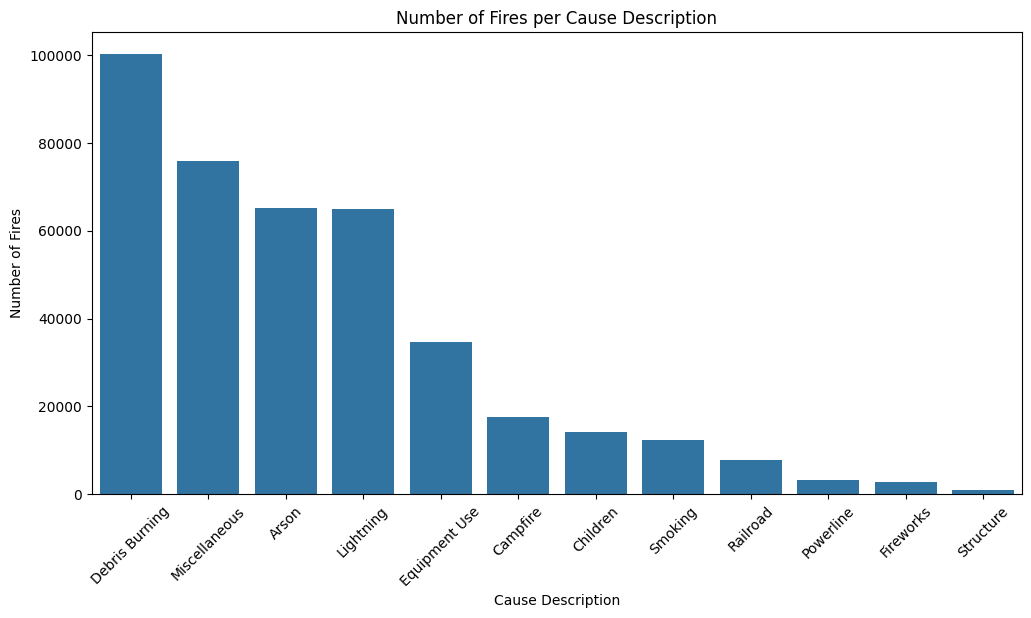

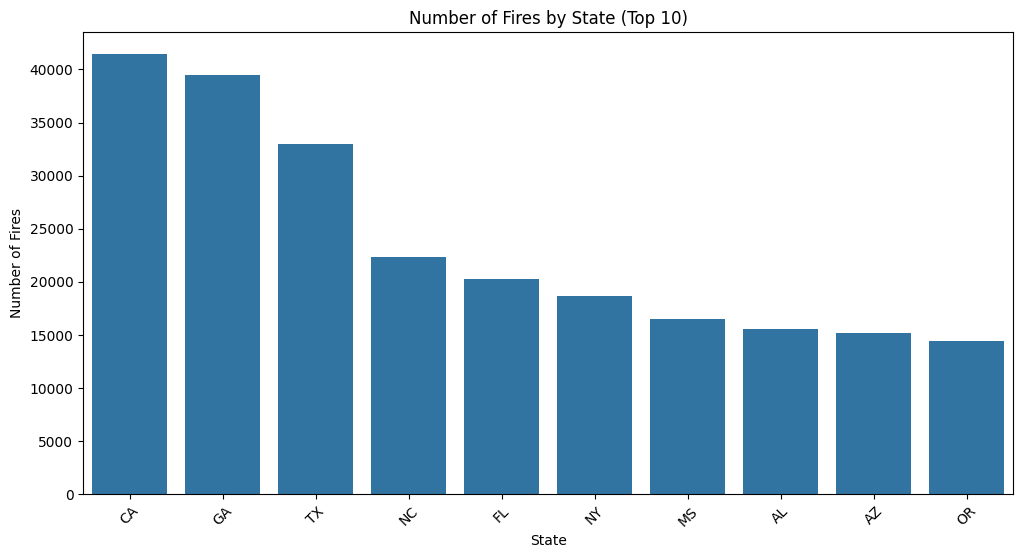

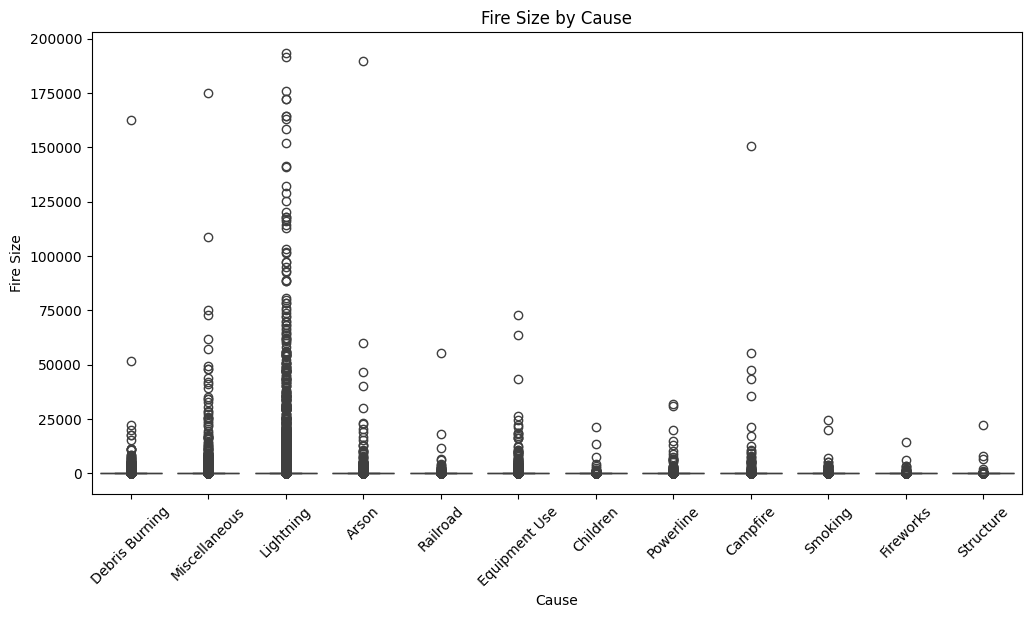

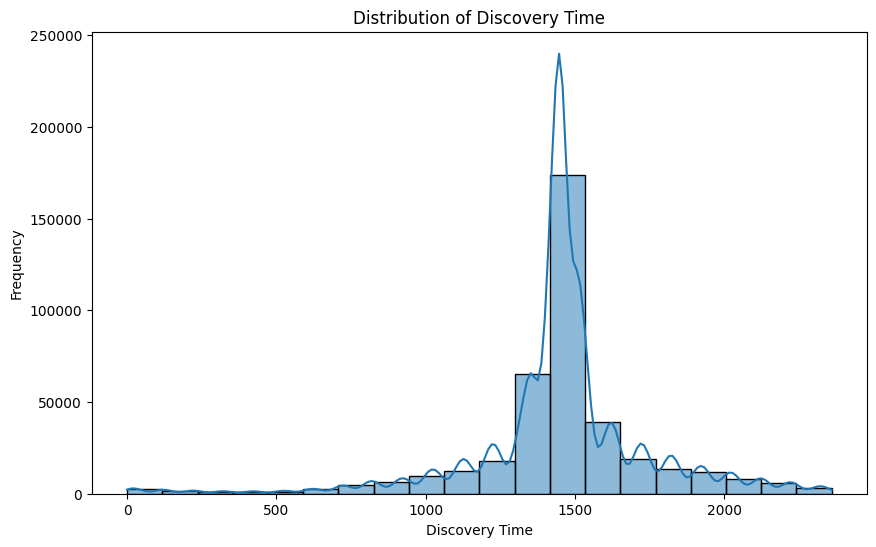

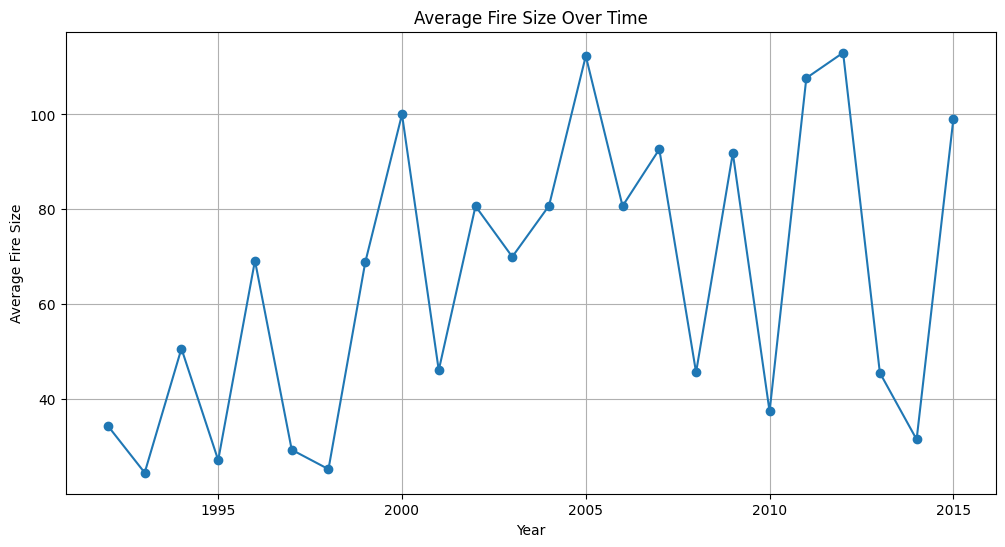

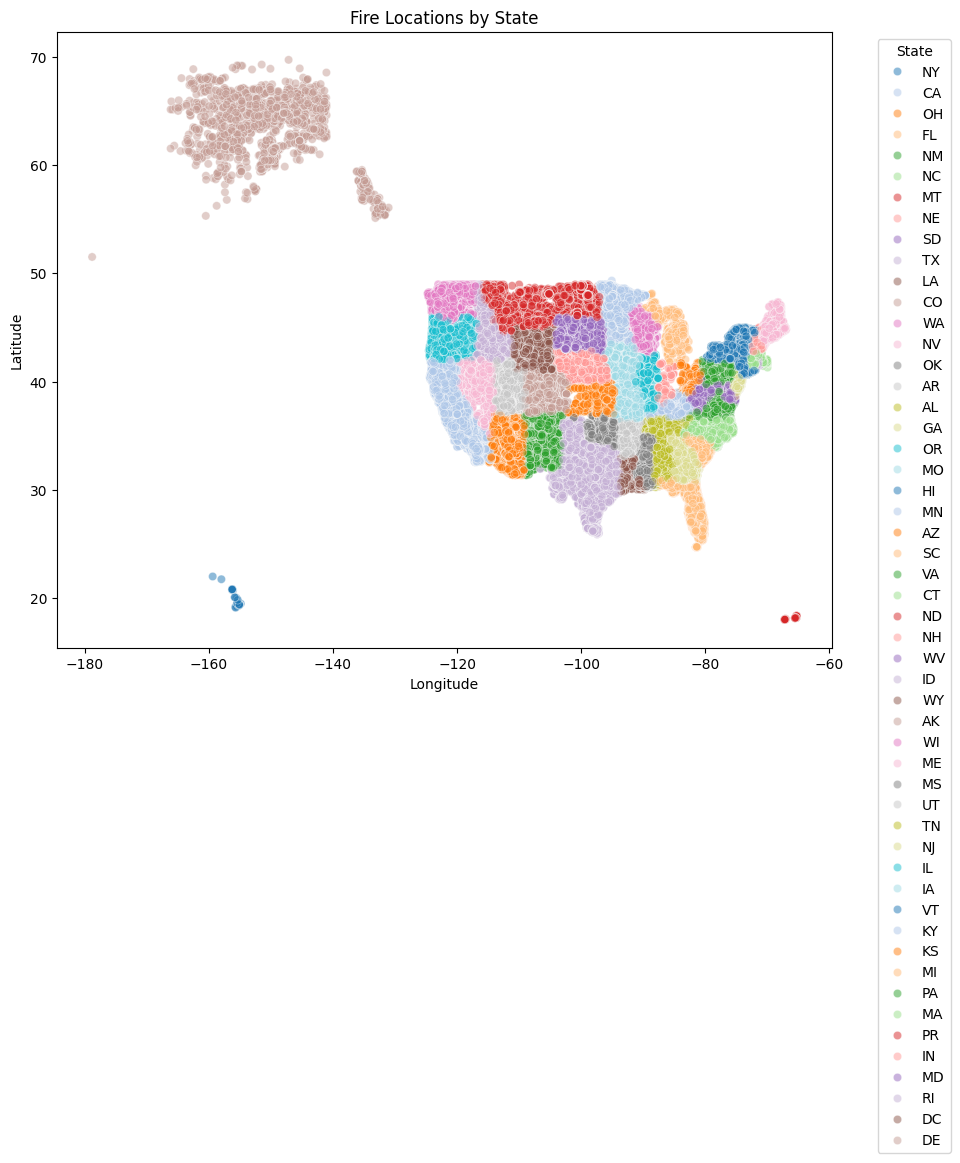

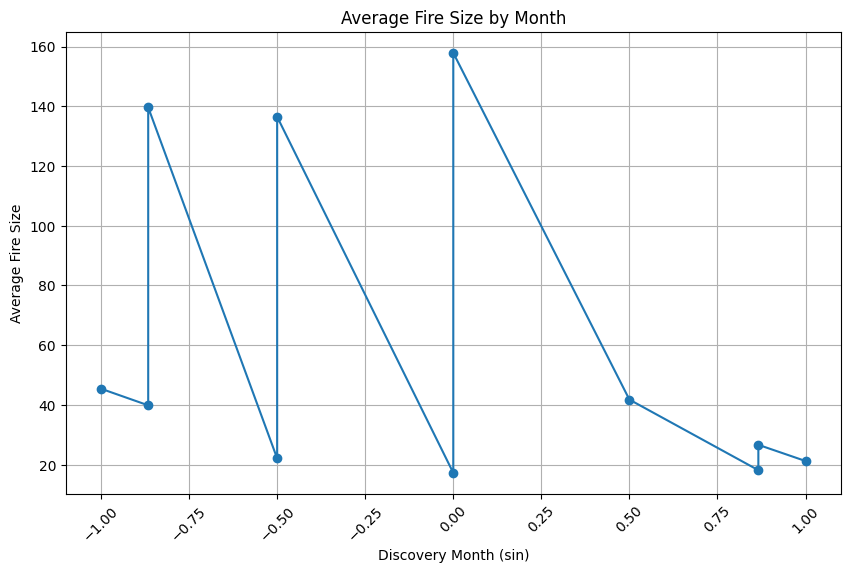

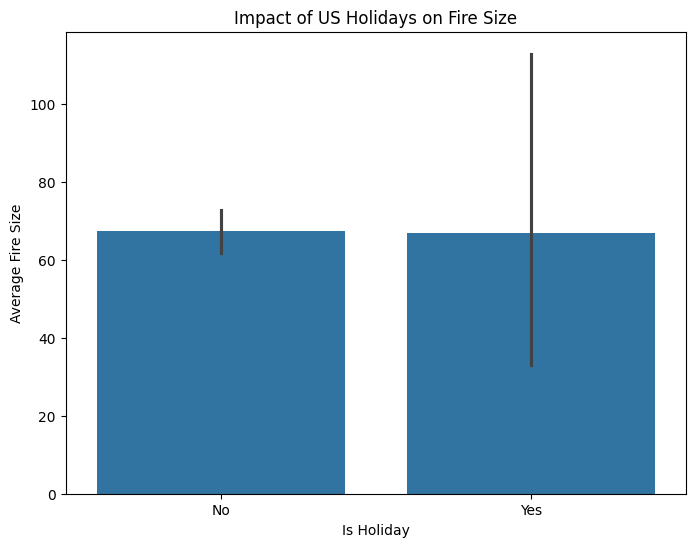

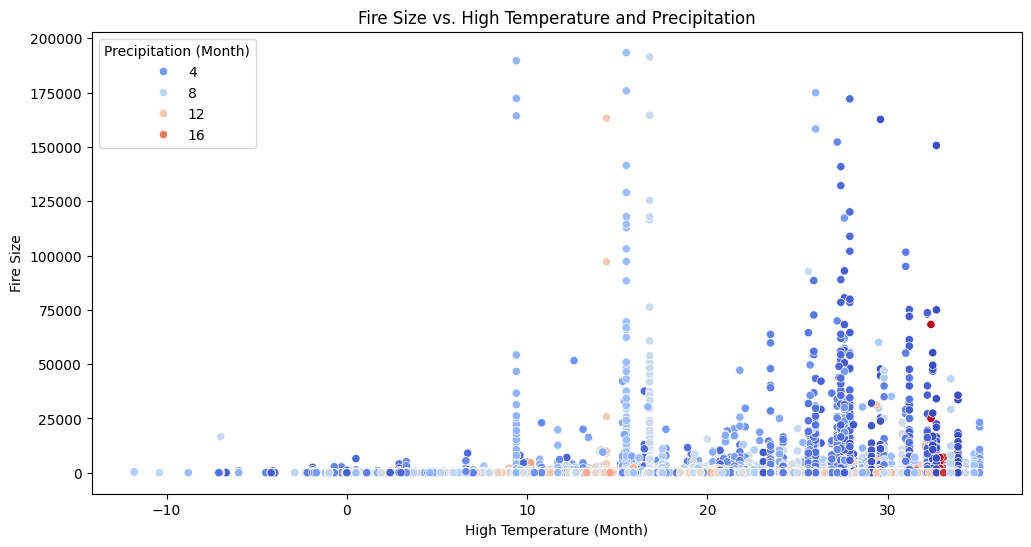

In [ ]:
# Categorical Analysis: Number of Fires per Cause Description
cause_counts = train.groupby('STAT_CAUSE_DESCR').size().reset_index(name='Fires_Count')
plt.figure(figsize=(12, 6))
sns.barplot(data=cause_counts, x='STAT_CAUSE_DESCR', y='Fires_Count', order=cause_counts.sort_values(by='Fires_Count', ascending=False)['STAT_CAUSE_DESCR'])
plt.title('Number of Fires per Cause Description')
plt.xlabel('Cause Description')
plt.ylabel('Number of Fires')
plt.xticks(rotation=45)
plt.show()

# Bar plot of number of fires by STATE
plt.figure(figsize=(12, 6))
sns.countplot(data=train, x='STATE', order=df['STATE'].value_counts().index[:10])
plt.title('Number of Fires by State (Top 10)')
plt.xlabel('State')
plt.ylabel('Number of Fires')
plt.xticks(rotation=45)
plt.show()

# Box plot of FIRE_SIZE by STAT_CAUSE_DESCR
plt.figure(figsize=(12, 6))
sns.boxplot(data=train, x='STAT_CAUSE_DESCR', y='FIRE_SIZE')
plt.title('Fire Size by Cause')
plt.xlabel('Cause')
plt.ylabel('Fire Size')
plt.xticks(rotation=45)
plt.show()

# Histogram of DISCOVERY_TIME
plt.figure(figsize=(10, 6))
sns.histplot(data=train, x='DISCOVERY_TIME', bins=20, kde=True)
plt.title('Distribution of Discovery Time')
plt.xlabel('Discovery Time')
plt.ylabel('Frequency')
plt.show()


# Time Series Analysis
plt.figure(figsize=(12, 6))
train.groupby('FIRE_YEAR')['FIRE_SIZE'].mean().plot(marker='o')
plt.title('Average Fire Size Over Time')
plt.xlabel('Year')
plt.ylabel('Average Fire Size')
plt.grid(True)
plt.show()

# Spatial Analysis
plt.figure(figsize=(10, 8))
sns.scatterplot(data=train, x='LONGITUDE', y='LATITUDE', hue='STATE', palette='tab20', alpha=0.5)
plt.title('Fire Locations by State')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Seasonal Trends
plt.figure(figsize=(10, 6))
train.groupby('DISCOVERY_MONTH_SIN')['FIRE_SIZE'].mean().plot(marker='o')
plt.title('Average Fire Size by Month')
plt.xlabel('Discovery Month (sin)')
plt.ylabel('Average Fire Size')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Holiday Impact
plt.figure(figsize=(8, 6))
sns.barplot(data=train, x='IS_DISCOVERY_DATE_US_HOLIDAY', y='FIRE_SIZE', estimator=np.mean)
plt.title('Impact of US Holidays on Fire Size')
plt.xlabel('Is Holiday')
plt.ylabel('Average Fire Size')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

# Weather Impact
plt.figure(figsize=(12, 6))
sns.scatterplot(data=train, x='HighTempMonth', y='FIRE_SIZE', hue='PrecMonth', palette='coolwarm')
plt.title('Fire Size vs. High Temperature and Precipitation')
plt.xlabel('High Temperature (Month)')
plt.ylabel('Fire Size')
plt.legend(title='Precipitation (Month)')
plt.show()



In [ ]:
train.drop(columns=['MONTH','DISCOVERY_DOW','OWNER_DESCR','SOURCE_SYSTEM','FIRE_SIZE'], inplace=True)

In [ ]:
test.drop(columns=['MONTH','DISCOVERY_DOW','OWNER_DESCR','SOURCE_SYSTEM','FIRE_SIZE'], inplace=True)

In [ ]:
print(train.dtypes)

FIRE_YEAR                         int64
DISCOVERY_TIME                  float64
STAT_CAUSE_DESCR                 object
CONT_TIME                       float64
FIRE_SIZE_CLASS                  object
LATITUDE                        float64
LONGITUDE                       float64
STATE                            object
FIPS_CODE                       float64
IS_LEAP_YEAR                      int64
DURATION_IN_DAYS                float64
IS_DISCOVERY_DATE_US_HOLIDAY      int64
HighTempMonth                   float64
LowTempMonth                    float64
PrecMonth                       float64
DISCOVERY_DOY_SIN               float64
DISCOVERY_DOY_COS               float64
DISCOVERY_MONTH_SIN             float64
DISCOVERY_MONTH_COS             float64
DISCOVERY_DOW_SIN               float64
DISCOVERY_DOW_COS               float64
dtype: object


Utility functions

In [ ]:
def run_model(model, X_val_scaled, y_val, label_encoder, epochs, batch_size, X_train_scaled, y_train):

    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Print model summary
    model.summary()

    # Train the model with Early Stopping
    history = model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val_scaled, y_val), verbose=1)

    # Plot loss and accuracy
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    # Evaluate the model on the validation set
    loss, accuracy = model.evaluate(X_val_scaled, y_val)
    print(f'Test Loss: {loss}')
    print(f'Test Accuracy: {accuracy}')

    # Make predictions
    predictions = model.predict(X_val_scaled)
    predicted_labels = np.argmax(predictions, axis=1)

    # Convert numerical labels back to original class labels
    predicted_classes = label_encoder.inverse_transform(predicted_labels)

    # Print classification report
    print(classification_report(y_val, predicted_labels))

    # Plot confusion matrix
    cm = confusion_matrix(y_val, predicted_labels)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(label_encoder.classes_))
    plt.xticks(tick_marks, label_encoder.classes_, rotation=45)
    plt.yticks(tick_marks, label_encoder.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    return history

In [ ]:
y = train['STAT_CAUSE_DESCR'].values

train = train.drop(['STAT_CAUSE_DESCR'], axis=1)

**Stat cause description prediction models**

In [ ]:
# Define features and target variable
X = train.values

X = pd.get_dummies(train, columns=train.select_dtypes(include=['object']).columns)

# Convert target variable to numerical labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Standardize features (optional but recommended for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [ ]:
X.head()

FIRE_YEAR  DISCOVERY_TIME    CONT_TIME   LATITUDE   LONGITUDE  FIPS_CODE  \
0       1998     1516.278903  1523.752427  41.586317  -74.494453      105.0   
1       1992     1142.000000  1800.000000  33.666667 -116.953333       58.0   
2       2015     1258.000000  1325.000000  39.829791  -82.192117      127.0   
3       2008     1110.000000  1110.000000  41.343354  -74.170421       71.0   
4       2013     1345.000000  1404.000000  30.497100  -83.148800       47.0   

   IS_LEAP_YEAR  DURATION_IN_DAYS  IS_DISCOVERY_DATE_US_HOLIDAY  \
0             0          3.905005                             0   
1             1          5.000000                             0   
2             0          1.000000                             0   
3             1          1.000000                             0   
4             0          1.000000                             0   

   HighTempMonth  LowTempMonth  PrecMonth  DISCOVERY_DOY_SIN  \
0            0.5          -9.9        6.3           0.831171   
1           24.2           9.5        2.5           0.507415   
2           18.1           6.0        7.7          -0.961130   
3           12.7           0.5        9.0           0.955211   
4           25.0          12.1        8.8           0.945596   

   DISCOVERY_DOY_COS  DISCOVERY_MONTH_SIN  DISCOVERY_MONTH_COS  \
0           0.556017             0.866025         5.000000e-01   
1          -0.861702             0.500000        -8.660254e-01   
2           0.276097            -0.866025         5.000000e-01   
3          -0.295927             0.866025        -5.000000e-01   
4           0.325342             1.000000         6.123234e-17   

   DISCOVERY_DOW_SIN  DISCOVERY_DOW_COS  FIRE_SIZE_CLASS_A  FIRE_SIZE_CLASS_B  \
0           0.433884          -0.900969              False               True   
1          -0.781831           0.623490              False              False   
2          -0.974928          -0.222521               True              False   
3          -0.433884          -0.900969              False               True   
4           0.974928          -0.222521              False               True   

   FIRE_SIZE_CLASS_C  FIRE_SIZE_CLASS_D  FIRE_SIZE_CLASS_E  FIRE_SIZE_CLASS_F  \
0              False              False              False              False   
1              False              False              False               True   
2              False              False              False              False   
3              False              False              False              False   
4              False              False              False              False   

   FIRE_SIZE_CLASS_G  STATE_AK  STATE_AL  STATE_AR  STATE_AZ  STATE_CA  \
0              False     False     False     False     False     False   
1              False     False     False     False     False      True   
2              False     False     False     False     False     False   
3              False     False     False     False     False     False   
4              False     False     False     False     False     False   

   STATE_CO  STATE_CT  STATE_DC  STATE_DE  STATE_FL  STATE_GA  STATE_HI  \
0     False     False     False     False     False     False     False   
1     False     False     False     False     False     False     False   
2     False     False     False     False     False     False     False   
3     False     False     False     False     False     False     False   
4     False     False     False     False      True     False     False   

   STATE_IA  STATE_ID  STATE_IL  STATE_IN  STATE_KS  STATE_KY  STATE_LA  \
0     False     False     False     False     False     False     False   
1     False     False     False     False     False     False     False   
2     False     False     False     False     False     False     False   
3     False     False     False     False     False     False     False   
4     False     False     False     False     False     False     False   

   STATE_MA  STATE_MD 

In [ ]:
def save_model(model_name, history):
    with open(f'{model_name}.pkl', 'wb') as f:
            pickle.dump(history.history, f)

1. simple 3 layers prediction model

In [ ]:
# Define the model architecture
model_1 = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                4992      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 12)                396       
                                                                 
Total params: 7468 (29.17 KB)
Trainable params: 7468 (29.17 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
2500/2500 [==============================] - 9s 3ms/step - loss: 1.5937 - accuracy: 0.4532 - val_loss: 1.5395 - val_accuracy: 0.4701
Epoch 2/40
2500/2500 [==============================] - 6s 2ms/step - loss: 1.5175 - accuracy: 0.4770 - val_loss: 1.5109 - val_accuracy: 0.480

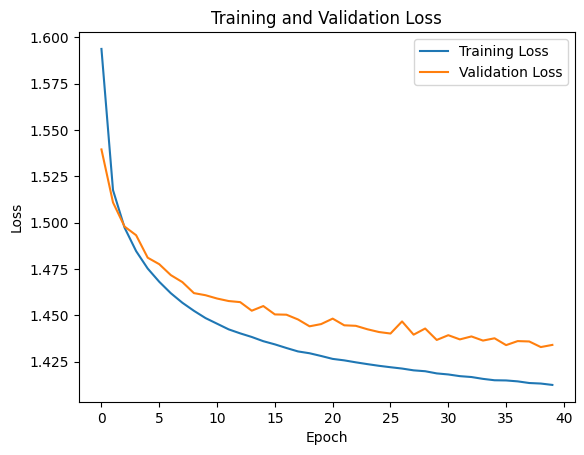

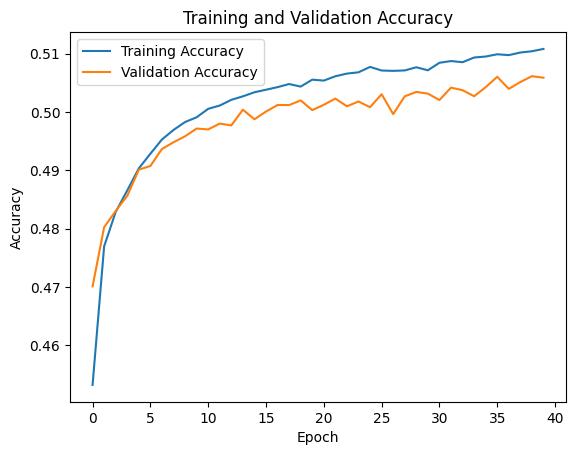

2500/2500 [==============================] - 4s 1ms/step - loss: 1.4341 - accuracy: 0.5059
Test Loss: 1.4340965747833252
Test Accuracy: 0.5058881044387817
2500/2500 [==============================] - 5s 2ms/step
              precision    recall  f1-score   support

           0       0.45      0.47      0.46     12949
           1       0.38      0.18      0.25      3473
           2       0.29      0.05      0.09      2878
           3       0.48      0.69      0.57     20151
           4       0.35      0.15      0.21      6945
           5       0.47      0.37      0.41       538
           6       0.70      0.80      0.75     13008
           7       0.47      0.49      0.48     15217
           8       0.00      0.00      0.00       653
           9       0.41      0.36      0.39      1532
          10       0.33      0.00      0.00      2482
          11       0.00      0.00      0.00       166

    accuracy                           0.51     79992
   macro avg       0.36      0

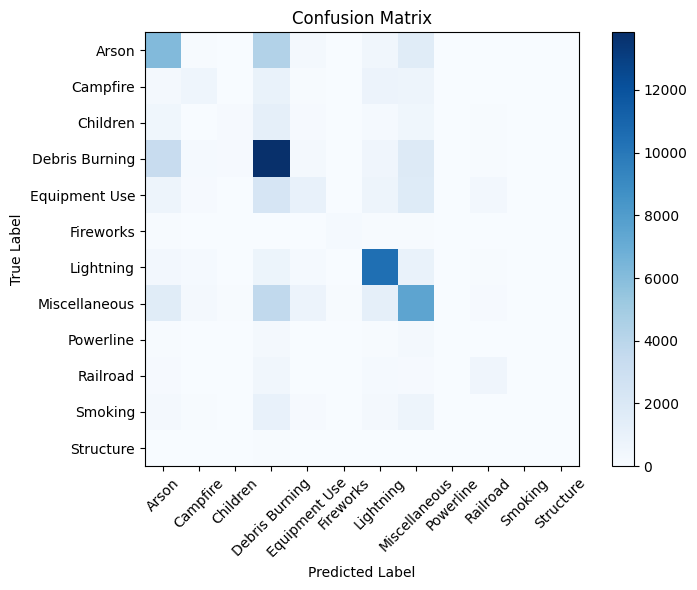

In [ ]:
history1_1 = run_model(model_1, X_val_scaled, y_val, label_encoder, 40, 128, X_train_scaled, y_train)
save_model("history1_1", history1_1)

In [ ]:
history1_2 = run_model(model_1, X_val_scaled, y_val, label_encoder, 40, 256, X_train_scaled, y_train)
save_model("history1_2", history1_2)

NameError: name 'run_model' is not defined

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 64)             │         4,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,468 (29.17 KB)

 Trainable params: 7,468 (29.17 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.4256 - loss: 1.6873 - val_accuracy: 0.4715 - val_loss: 1.5383
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4773 - loss: 1.5168 - val_accuracy: 0.4784 - val_loss: 1.5084
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4819 - loss: 1.4977 - val_accuracy: 0.4820 - val_loss: 1.4960
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4848 - loss: 1.4854 - val_accuracy: 0.4856 - val_loss: 1.4875
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4913 - loss: 1.4738 - val_accuracy: 0.4889 - val_loss: 1.4824
Epoch 6/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4942 - loss: 1.4660 - val_accuracy: 0.4937 - val_loss: 1.4730
Epoch 7/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4943 - loss: 1.4628 - val_accuracy: 0.4919 - val_loss: 1.4749
Epoch 8/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4972 - loss: 1.4534 - 

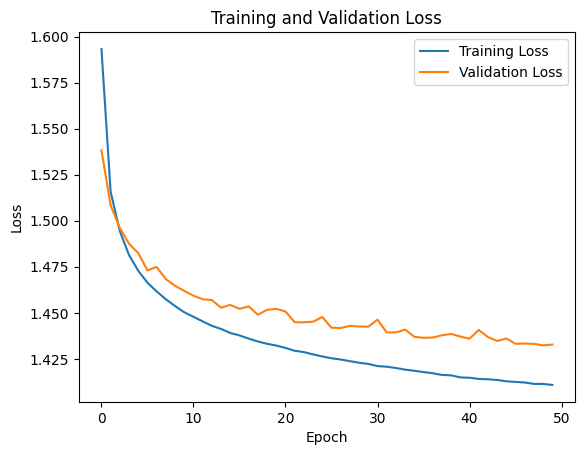

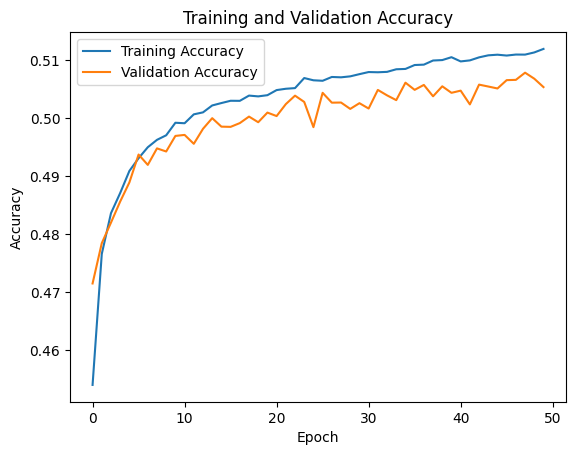

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 841us/step - accuracy: 0.5059 - loss: 1.4354
Test Loss: 1.432750940322876
Test Accuracy: 0.5053755640983582
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 831us/step
              precision    recall  f1-score   support

           0       0.46      0.47      0.47     12949
           1       0.38      0.19      0.25      3473
           2       0.30      0.02      0.04      2878
           3       0.48      0.70      0.57     20151
           4       0.34      0.21      0.25      6945
           5       0.50      0.36      0.42       538
           6       0.67      0.82      0.74     13008
           7       0.50      0.44      0.47     15217
           8       0.00      0.00      0.00       653
           9       0.42      0.35      0.38      1532
          10       0.12      0.00      0.00      2482
          11       1.00      0.01      0.01       166

    accuracy                           0.51     79992
   macro avg       0.43      0.30      0.30     79992
w

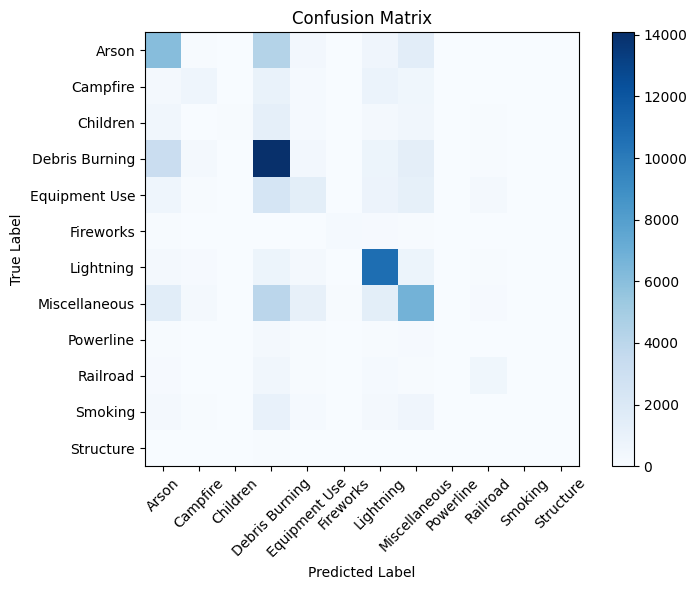

In [ ]:
history1_3 = run_model(model_1, X_val_scaled, y_val, label_encoder, 50, 128, X_train_scaled, y_train)
save_model("history1_3", history1_3)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 64)             │         4,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,468 (29.17 KB)

 Trainable params: 7,468 (29.17 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4133 - loss: 1.7191 - val_accuracy: 0.4613 - val_loss: 1.5543
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4708 - loss: 1.5323 - val_accuracy: 0.4766 - val_loss: 1.5188
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4788 - loss: 1.5073 - val_accuracy: 0.4813 - val_loss: 1.5055
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4862 - loss: 1.4891 - val_accuracy: 0.4858 - val_loss: 1.4938
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4895 - loss: 1.4785 - val_accuracy: 0.4880 - val_loss: 1.4853
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4903 - loss: 1.4734 - val_accuracy: 0.4890 - val_loss: 1.4825
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4934 - loss: 1.4666 - val_accuracy: 0.4926 - val_loss: 1.4771
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4953 - loss: 1.4609 - 

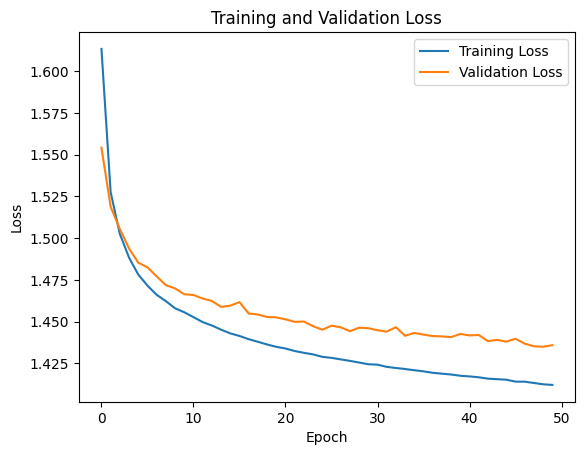

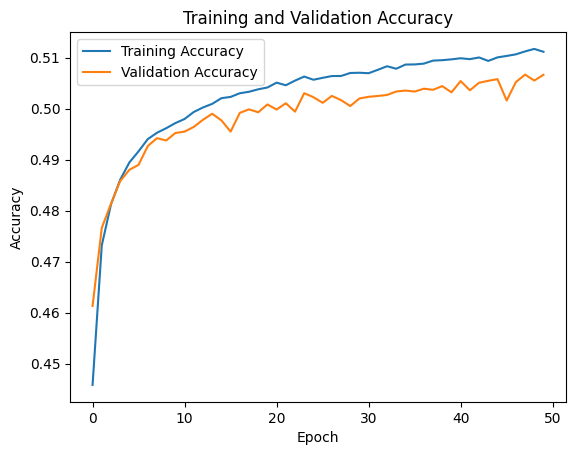

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 808us/step - accuracy: 0.5076 - loss: 1.4381
Test Loss: 1.435856819152832
Test Accuracy: 0.5066131353378296
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 841us/step
              precision    recall  f1-score   support

           0       0.50      0.39      0.44     12949
           1       0.41      0.18      0.25      3473
           2       0.31      0.02      0.04      2878
           3       0.48      0.71      0.57     20151
           4       0.36      0.15      0.21      6945
           5       0.55      0.23      0.32       538
           6       0.68      0.82      0.74     13008
           7       0.45      0.53      0.49     15217
           8       0.12      0.00      0.00       653
           9       0.40      0.36      0.38      1532
          10       0.00      0.00      0.00      2482
          11       0.33      0.01      0.02       166

    accuracy                           0.51     79992
   macro avg       0.38      0.28      0.29     79992
w

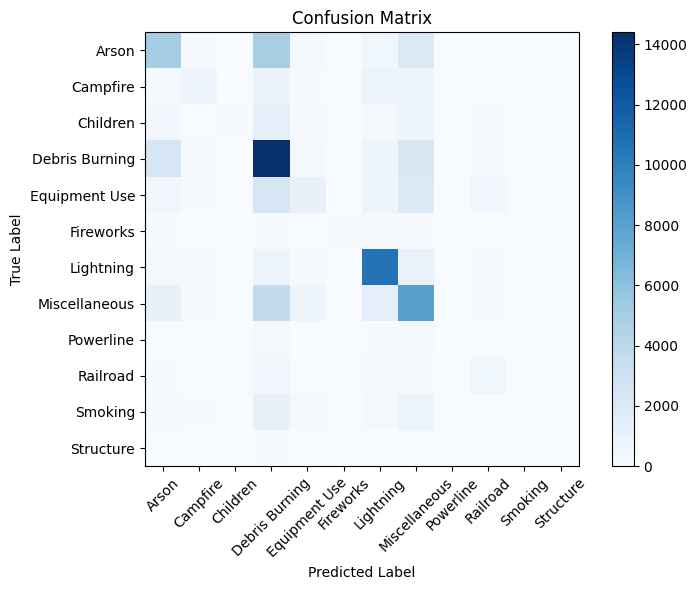

In [ ]:
history1_4 = (run_model(model_1, X_val_scaled, y_val, label_encoder, 50, 256, X_train_scaled, y_train))
save_model("history1_4", history1_4)

In [ ]:
# Define the model architecture
model_2 = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 128)            │         9,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,020 (74.30 KB)

 Trainable params: 19,020 (74.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.4436 - loss: 1.6258 - val_accuracy: 0.4778 - val_loss: 1.5135
Epoch 2/40
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4805 - loss: 1.4993 - val_accuracy: 0.4872 - val_loss: 1.4906
Epoch 3/40
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4914 - loss: 1.4737 - val_accuracy: 0.4917 - val_loss: 1.4752
Epoch 4/40
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4955 - loss: 1.4592 - val_accuracy: 0.4942 - val_loss: 1.4667
Epoch 5/40
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4970 - loss: 1.4510 - val_accuracy: 0.4956 - val_loss: 1.4599
Epoch 6/40
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5011 - loss: 1.4393 - val_accuracy: 0.4936 - val_loss: 1.4598
Epoch 7/40
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5016 - loss: 1.4372 - val_accuracy: 0.4991 - val_loss: 1.4495
Epoch 8/40
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5046 - loss: 1.4282 - 

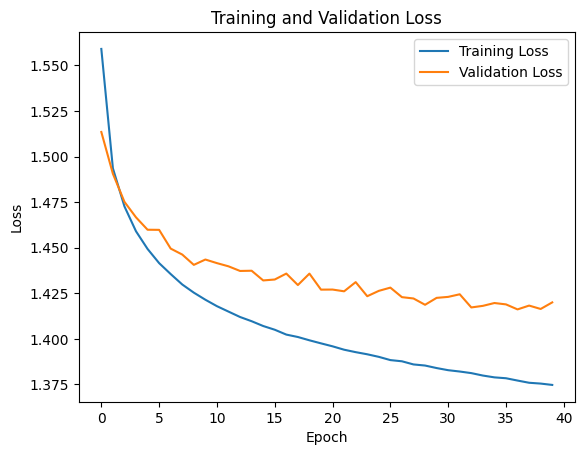

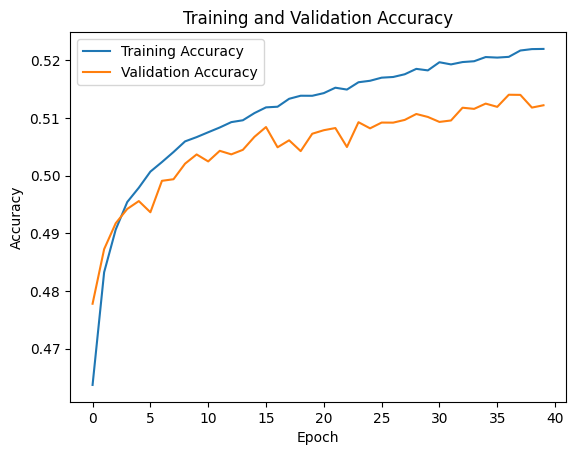

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 813us/step - accuracy: 0.5126 - loss: 1.4215
Test Loss: 1.419992446899414
Test Accuracy: 0.5122012495994568
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 905us/step
              precision    recall  f1-score   support

           0       0.50      0.42      0.46     12949
           1       0.41      0.21      0.28      3473
           2       0.30      0.04      0.08      2878
           3       0.48      0.73      0.58     20151
           4       0.34      0.18      0.24      6945
           5       0.45      0.38      0.41       538
           6       0.70      0.81      0.75     13008
           7       0.47      0.50      0.49     15217
           8       0.10      0.00      0.00       653
           9       0.44      0.18      0.25      1532
          10       0.14      0.00      0.00      2482
          11       0.50      0.02      0.05       166

    accuracy                           0.51     79992
   macro avg       0.40      0.29      0.30     79992
w

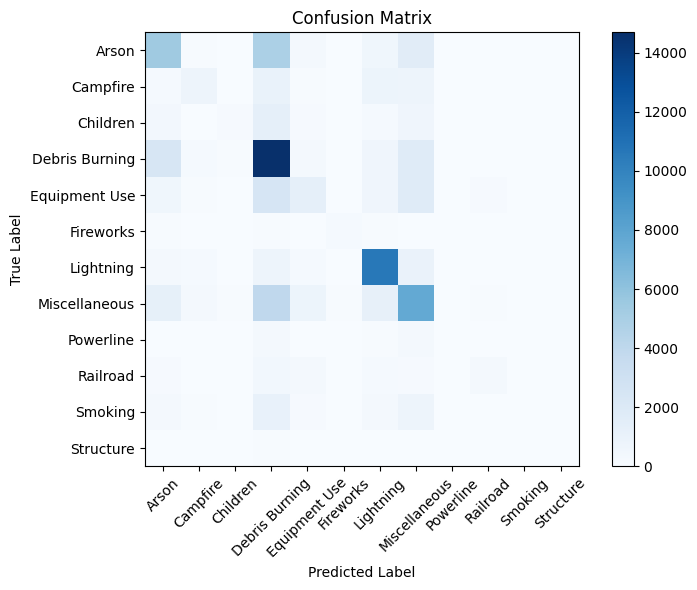

In [ ]:
history2_1 = run_model(model_2, X_val_scaled, y_val, label_encoder, 40, 128, X_train_scaled, y_train)
save_model("history2_1", history2_1)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 128)            │         9,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,020 (74.30 KB)

 Trainable params: 19,020 (74.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4361 - loss: 1.6531 - val_accuracy: 0.4748 - val_loss: 1.5264
Epoch 2/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4788 - loss: 1.5091 - val_accuracy: 0.4809 - val_loss: 1.5010
Epoch 3/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4862 - loss: 1.4841 - val_accuracy: 0.4872 - val_loss: 1.4855
Epoch 4/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4910 - loss: 1.4727 - val_accuracy: 0.4906 - val_loss: 1.4776
Epoch 5/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4945 - loss: 1.4575 - val_accuracy: 0.4933 - val_loss: 1.4673
Epoch 6/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4981 - loss: 1.4493 - val_accuracy: 0.4947 - val_loss: 1.4616
Epoch 7/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5012 - loss: 1.4422 - val_accuracy: 0.4977 - val_loss: 1.4562
Epoch 8/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5018 - loss: 1.4363 - 

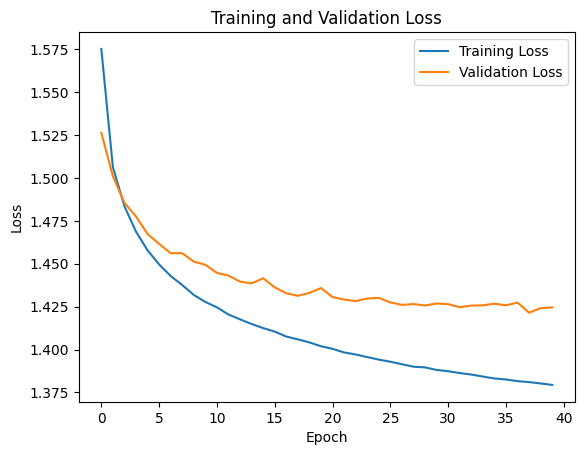

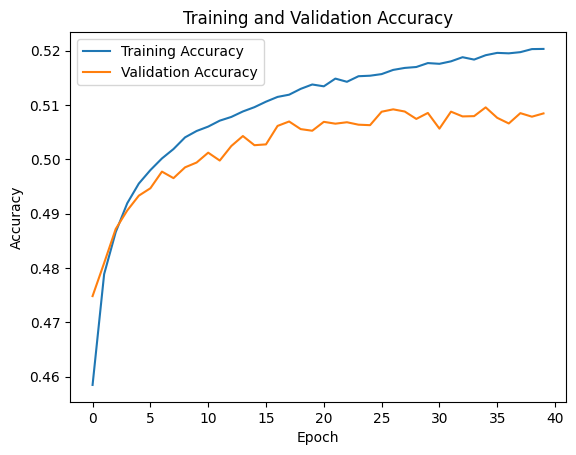

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 770us/step - accuracy: 0.5099 - loss: 1.4245
Test Loss: 1.4246468544006348
Test Accuracy: 0.5084508657455444
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 860us/step
              precision    recall  f1-score   support

           0       0.48      0.43      0.45     12949
           1       0.36      0.26      0.30      3473
           2       0.32      0.04      0.07      2878
           3       0.47      0.73      0.57     20151
           4       0.33      0.23      0.27      6945
           5       0.50      0.33      0.40       538
           6       0.69      0.81      0.75     13008
           7       0.51      0.43      0.47     15217
           8       0.11      0.00      0.00       653
           9       0.41      0.30      0.35      1532
          10       0.11      0.00      0.00      2482
          11       1.00      0.01      0.01       166

    accuracy                           0.51     79992
   macro avg       0.44      0.30      0.30     79992


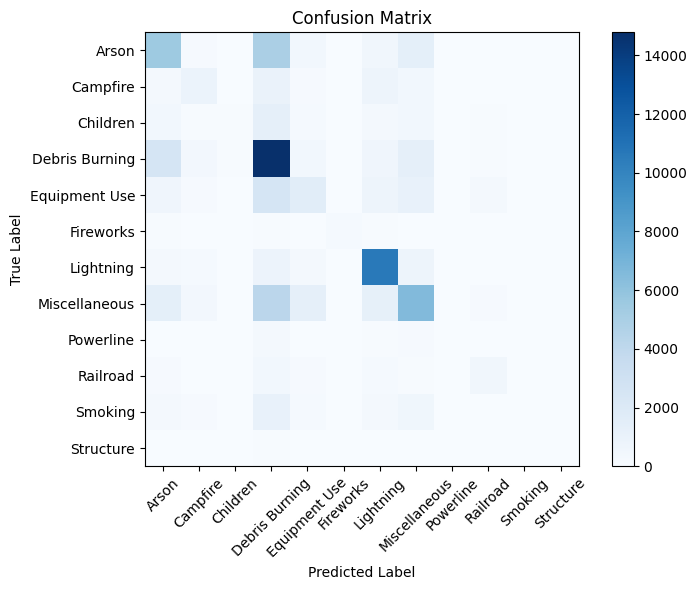

In [ ]:
history2_2 = run_model(model_2, X_val_scaled, y_val, label_encoder, 40, 256, X_train_scaled, y_train)
save_model("history2_2", history2_2)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 128)            │         9,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,020 (74.30 KB)

 Trainable params: 19,020 (74.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.4414 - loss: 1.6348 - val_accuracy: 0.4781 - val_loss: 1.5134
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4824 - loss: 1.4970 - val_accuracy: 0.4858 - val_loss: 1.4889
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4895 - loss: 1.4721 - val_accuracy: 0.4892 - val_loss: 1.4799
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4949 - loss: 1.4582 - val_accuracy: 0.4918 - val_loss: 1.4659
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4967 - loss: 1.4493 - val_accuracy: 0.4949 - val_loss: 1.4592
Epoch 6/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5000 - loss: 1.4418 - val_accuracy: 0.4997 - val_loss: 1.4539
Epoch 7/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5002 - loss: 1.4394 - val_accuracy: 0.4981 - val_loss: 1.4540
Epoch 8/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5034 - loss: 1.4308 - 

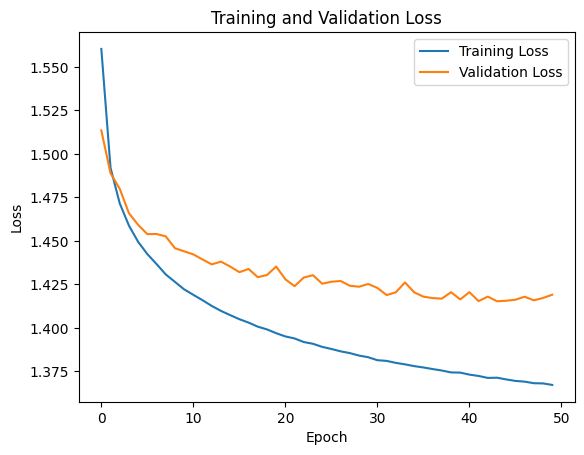

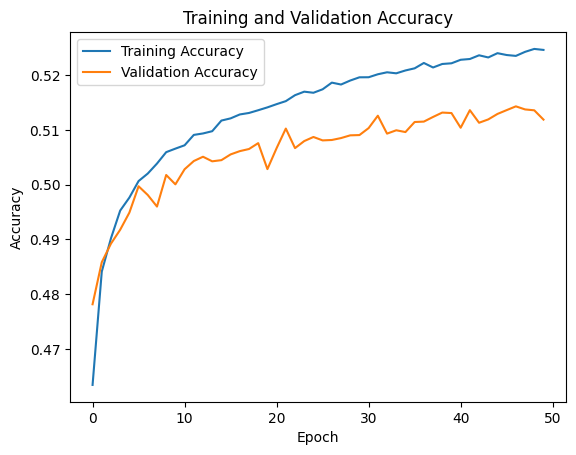

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 816us/step - accuracy: 0.5126 - loss: 1.4210
Test Loss: 1.4190855026245117
Test Accuracy: 0.5119137167930603
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 805us/step
              precision    recall  f1-score   support

           0       0.50      0.44      0.47     12949
           1       0.36      0.30      0.33      3473
           2       0.31      0.03      0.06      2878
           3       0.50      0.66      0.57     20151
           4       0.34      0.20      0.25      6945
           5       0.46      0.38      0.42       538
           6       0.72      0.80      0.76     13008
           7       0.46      0.53      0.49     15217
           8       0.00      0.00      0.00       653
           9       0.41      0.36      0.39      1532
          10       0.12      0.00      0.00      2482
          11       0.44      0.02      0.05       166

    accuracy                           0.51     79992
   macro avg       0.38      0.31      0.31     79992


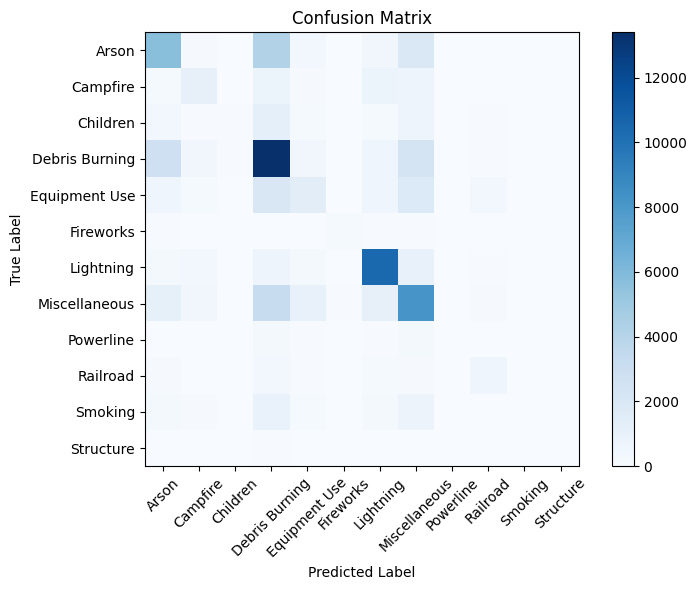

In [ ]:
history2_3 = run_model(model_2, X_val_scaled, y_val, label_encoder, 50, 128, X_train_scaled, y_train)
save_model("history2_3", history2_3)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 128)            │         9,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,020 (74.30 KB)

 Trainable params: 19,020 (74.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4323 - loss: 1.6676 - val_accuracy: 0.4726 - val_loss: 1.5308
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4796 - loss: 1.5070 - val_accuracy: 0.4818 - val_loss: 1.5024
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4856 - loss: 1.4845 - val_accuracy: 0.4886 - val_loss: 1.4888
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4914 - loss: 1.4699 - val_accuracy: 0.4905 - val_loss: 1.4746
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4936 - loss: 1.4607 - val_accuracy: 0.4931 - val_loss: 1.4704
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4966 - loss: 1.4522 - val_accuracy: 0.4951 - val_loss: 1.4620
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4998 - loss: 1.4416 - val_accuracy: 0.4973 - val_loss: 1.4588
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5009 - loss: 1.4376 - 

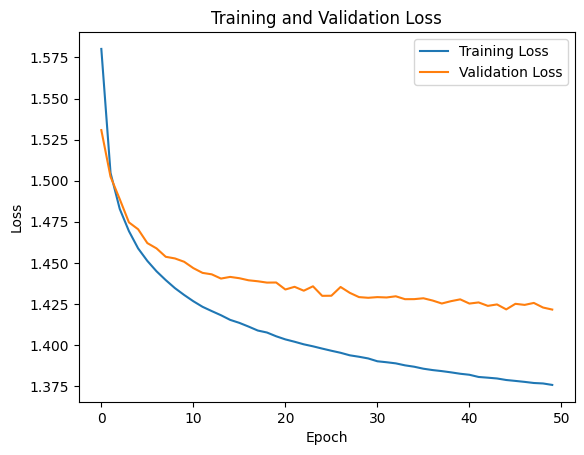

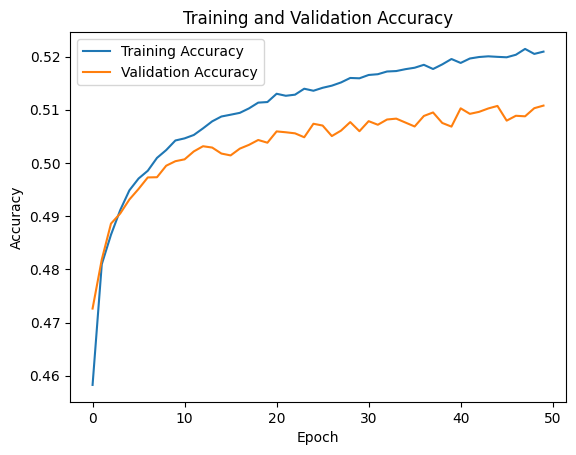

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 802us/step - accuracy: 0.5103 - loss: 1.4237
Test Loss: 1.4216718673706055
Test Accuracy: 0.5107761025428772
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 839us/step
              precision    recall  f1-score   support

           0       0.49      0.42      0.45     12949
           1       0.38      0.25      0.30      3473
           2       0.31      0.03      0.06      2878
           3       0.48      0.72      0.58     20151
           4       0.34      0.20      0.25      6945
           5       0.53      0.31      0.39       538
           6       0.69      0.82      0.75     13008
           7       0.49      0.48      0.48     15217
           8       0.00      0.00      0.00       653
           9       0.42      0.35      0.38      1532
          10       0.00      0.00      0.00      2482
          11       0.25      0.02      0.03       166

    accuracy                           0.51     79992
   macro avg       0.36      0.30      0.31     79992


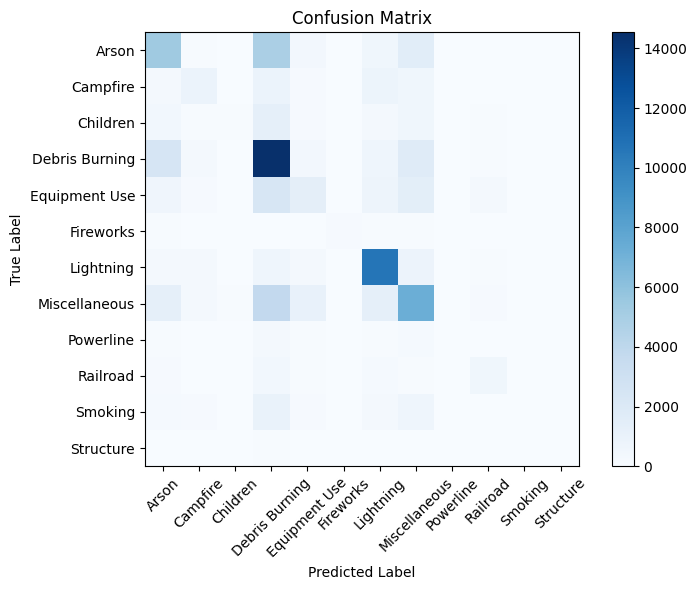

In [ ]:
history2_4 = run_model(model_2, X_val_scaled, y_val, label_encoder, 50, 256, X_train_scaled, y_train)
save_model("history2_4", history2_4)

In [ ]:
# Define the model architecture
model_3 = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                │ (None, 256)            │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,900 (241.80 KB)

 Trainable params: 61,900 (241.80 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.4482 - loss: 1.6042 - val_accuracy: 0.4824 - val_loss: 1.4974
Epoch 2/40
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4862 - loss: 1.4835 - val_accuracy: 0.4908 - val_loss: 1.4790
Epoch 3/40
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4940 - loss: 1.4615 - val_accuracy: 0.4943 - val_loss: 1.4631
Epoch 4/40
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4986 - loss: 1.4475 - val_accuracy: 0.4970 - val_loss: 1.4545
Epoch 5/40
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5037 - loss: 1.4315 - val_accuracy: 0.5000 - val_loss: 1.4458
Epoch 6/40
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5040 - loss: 1.4275 - val_accuracy: 0.5028 - val_loss: 1.4426
Epoch 7/40
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5079 - loss: 1.4164 - val_accuracy: 0.5016 - val_loss: 1.4437
Epoch 8/40
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5095 - loss: 1.4071 - 

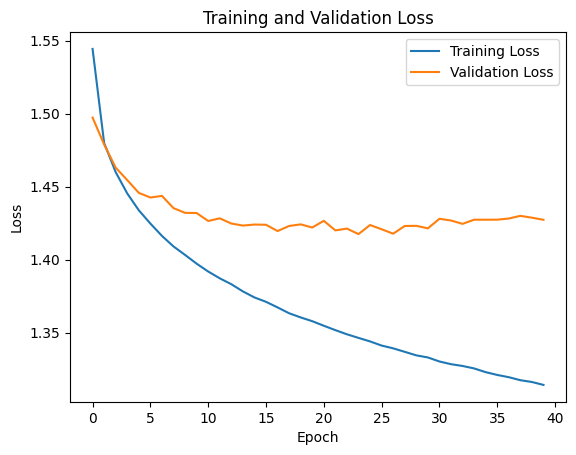

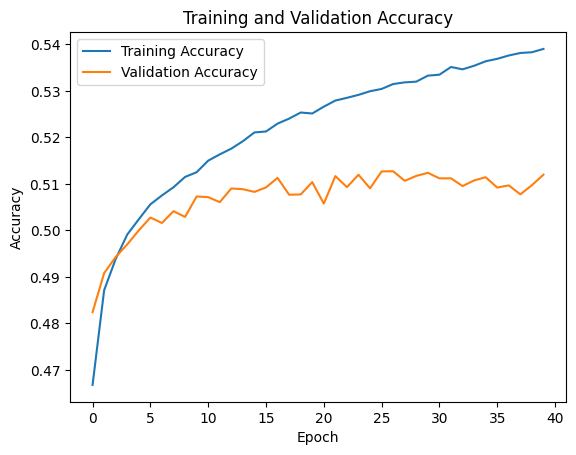

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 955us/step - accuracy: 0.5107 - loss: 1.4303
Test Loss: 1.427372694015503
Test Accuracy: 0.5119886994361877
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 936us/step
              precision    recall  f1-score   support

           0       0.48      0.46      0.47     12949
           1       0.42      0.22      0.29      3473
           2       0.27      0.04      0.07      2878
           3       0.49      0.69      0.57     20151
           4       0.35      0.18      0.23      6945
           5       0.45      0.37      0.40       538
           6       0.70      0.81      0.75     13008
           7       0.47      0.52      0.49     15217
           8       0.12      0.01      0.02       653
           9       0.44      0.26      0.33      1532
          10       0.14      0.00      0.01      2482
          11       0.25      0.02      0.03       166

    accuracy                           0.51     79992
   macro avg       0.38      0.30      0.31     79992
w

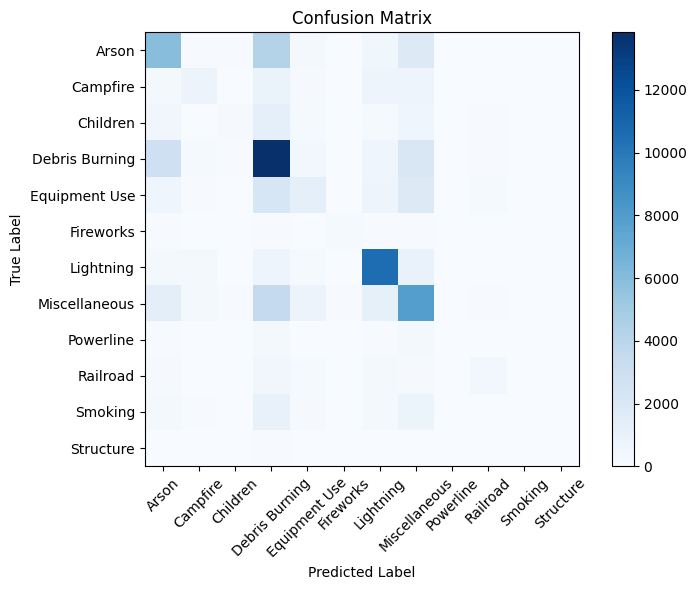

In [ ]:
history3_1 = run_model(model_3, X_val_scaled, y_val, label_encoder, 40, 128, X_train_scaled, y_train)
save_model("history3_1", history3_1)

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_37 (Dense)                │ (None, 256)            │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,900 (241.80 KB)

 Trainable params: 61,900 (241.80 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4417 - loss: 1.6309 - val_accuracy: 0.4797 - val_loss: 1.5033
Epoch 2/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4850 - loss: 1.4876 - val_accuracy: 0.4888 - val_loss: 1.4791
Epoch 3/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4929 - loss: 1.4605 - val_accuracy: 0.4923 - val_loss: 1.4652
Epoch 4/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4967 - loss: 1.4447 - val_accuracy: 0.4964 - val_loss: 1.4593
Epoch 5/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5014 - loss: 1.4371 - val_accuracy: 0.4996 - val_loss: 1.4493
Epoch 6/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5054 - loss: 1.4210 - val_accuracy: 0.5000 - val_loss: 1.4461
Epoch 7/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5084 - loss: 1.4162 - val_accuracy: 0.5023 - val_loss: 1.4382
Epoch 8/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5105 - loss: 1.4047 - 

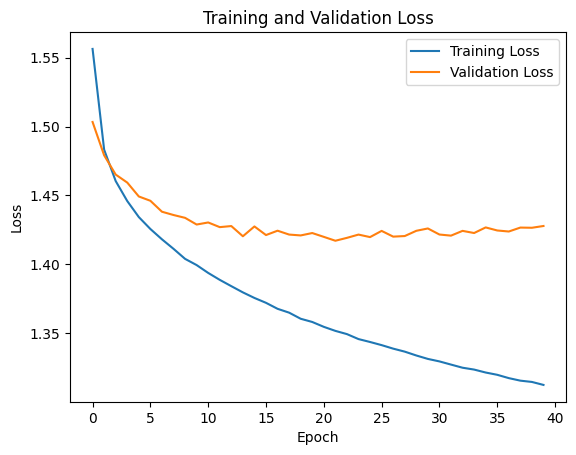

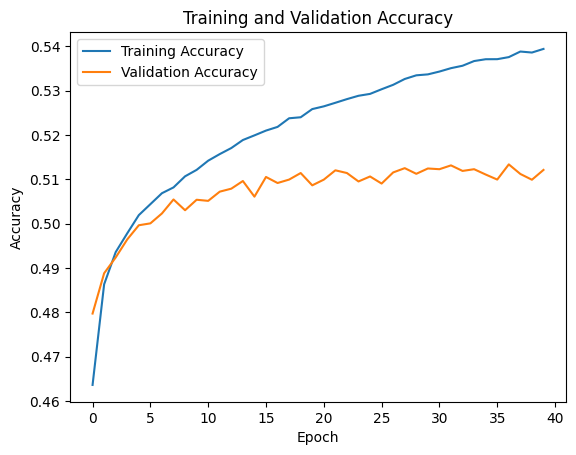

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 834us/step - accuracy: 0.5117 - loss: 1.4310
Test Loss: 1.4279917478561401
Test Accuracy: 0.5120887160301208
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 907us/step
              precision    recall  f1-score   support

           0       0.50      0.42      0.46     12949
           1       0.40      0.25      0.31      3473
           2       0.31      0.03      0.06      2878
           3       0.48      0.72      0.58     20151
           4       0.33      0.19      0.24      6945
           5       0.44      0.38      0.40       538
           6       0.72      0.79      0.75     13008
           7       0.47      0.51      0.49     15217
           8       0.12      0.01      0.01       653
           9       0.43      0.26      0.32      1532
          10       0.27      0.00      0.01      2482
          11       0.22      0.03      0.05       166

    accuracy                           0.51     79992
   macro avg       0.39      0.30      0.31     79992


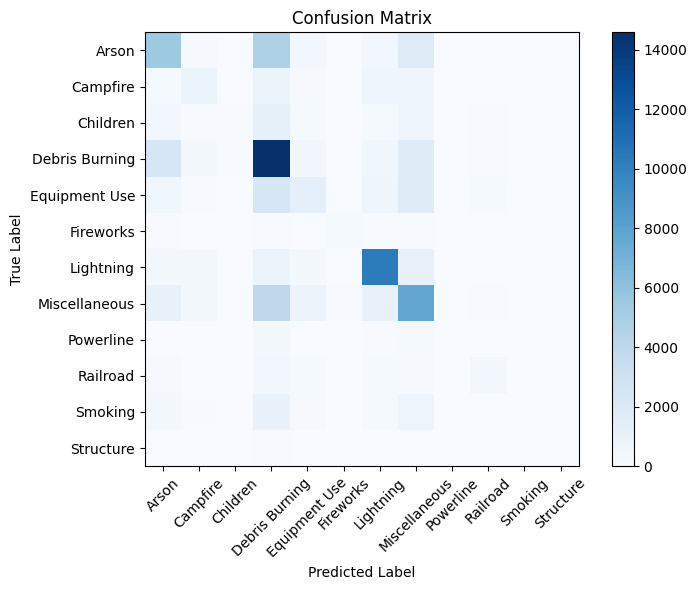

In [ ]:
history3_2 = run_model(model_3, X_val_scaled, y_val, label_encoder, 40, 256, X_train_scaled, y_train)
save_model("history3_2", history3_2)

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_41 (Dense)                │ (None, 256)            │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,900 (241.80 KB)

 Trainable params: 61,900 (241.80 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.4485 - loss: 1.6039 - val_accuracy: 0.4772 - val_loss: 1.5048
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4859 - loss: 1.4842 - val_accuracy: 0.4889 - val_loss: 1.4826
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4933 - loss: 1.4602 - val_accuracy: 0.4937 - val_loss: 1.4693
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4992 - loss: 1.4439 - val_accuracy: 0.4966 - val_loss: 1.4531
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5033 - loss: 1.4286 - val_accuracy: 0.4993 - val_loss: 1.4488
Epoch 6/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5061 - loss: 1.4188 - val_accuracy: 0.5002 - val_loss: 1.4441
Epoch 7/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5091 - loss: 1.4120 - val_accuracy: 0.5040 - val_loss: 1.4361
Epoch 8/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5104 - loss: 1.4071 - 

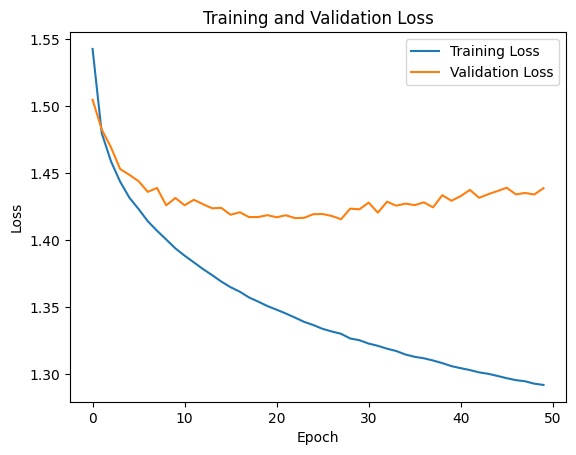

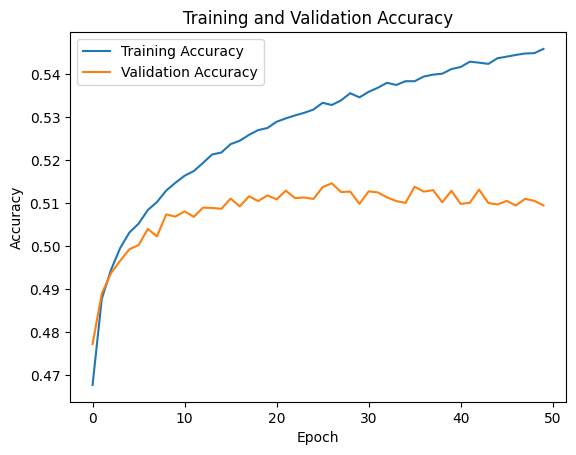

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 933us/step - accuracy: 0.5096 - loss: 1.4428
Test Loss: 1.4388231039047241
Test Accuracy: 0.5094759464263916
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 936us/step
              precision    recall  f1-score   support

           0       0.49      0.44      0.46     12949
           1       0.40      0.24      0.30      3473
           2       0.29      0.04      0.07      2878
           3       0.50      0.66      0.57     20151
           4       0.33      0.19      0.24      6945
           5       0.48      0.34      0.40       538
           6       0.69      0.81      0.75     13008
           7       0.45      0.53      0.49     15217
           8       0.07      0.01      0.01       653
           9       0.43      0.36      0.39      1532
          10       0.16      0.00      0.01      2482
          11       0.29      0.03      0.05       166

    accuracy                           0.51     79992
   macro avg       0.38      0.30      0.31     79992


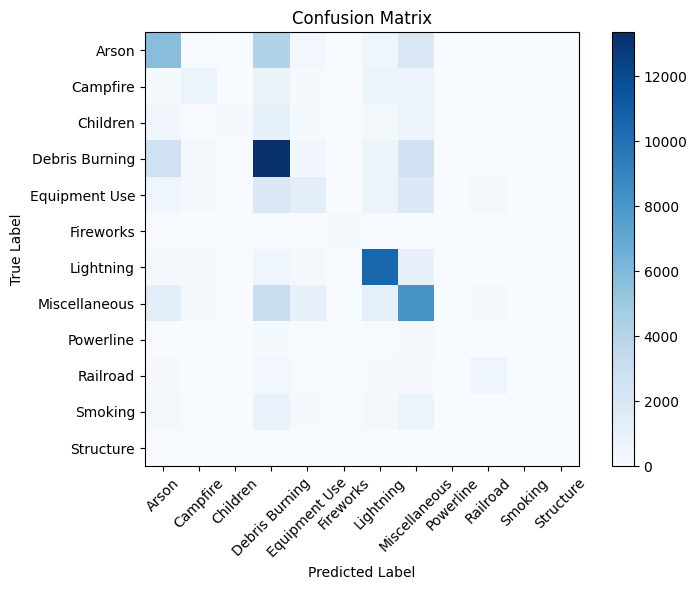

In [ ]:
history3_3 = run_model(model_3, X_val_scaled, y_val, label_encoder, 50, 128, X_train_scaled, y_train)
save_model("history3_3", history3_3)

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 256)            │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,900 (241.80 KB)

 Trainable params: 61,900 (241.80 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4469 - loss: 1.6183 - val_accuracy: 0.4817 - val_loss: 1.5009
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4854 - loss: 1.4866 - val_accuracy: 0.4896 - val_loss: 1.4790
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4926 - loss: 1.4642 - val_accuracy: 0.4958 - val_loss: 1.4634
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4984 - loss: 1.4450 - val_accuracy: 0.4980 - val_loss: 1.4550
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5018 - loss: 1.4350 - val_accuracy: 0.4981 - val_loss: 1.4501
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5063 - loss: 1.4220 - val_accuracy: 0.4965 - val_loss: 1.4469
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5079 - loss: 1.4173 - val_accuracy: 0.4944 - val_loss: 1.4510
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5107 - loss: 1.4071 - 

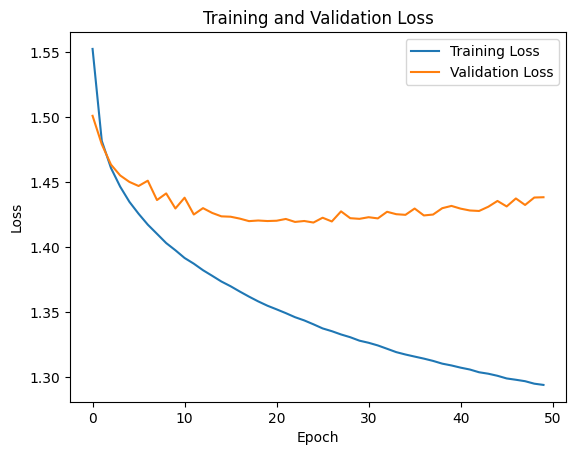

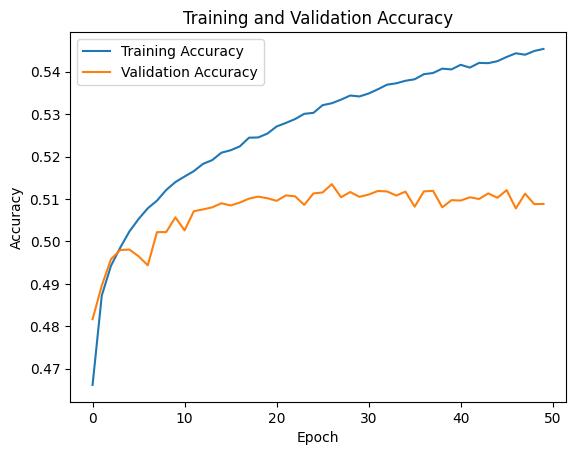

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 799us/step - accuracy: 0.5091 - loss: 1.4436
Test Loss: 1.438400387763977
Test Accuracy: 0.5088258981704712
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 866us/step
              precision    recall  f1-score   support

           0       0.52      0.37      0.43     12949
           1       0.35      0.27      0.30      3473
           2       0.31      0.05      0.08      2878
           3       0.47      0.75      0.58     20151
           4       0.33      0.21      0.26      6945
           5       0.44      0.40      0.42       538
           6       0.72      0.79      0.75     13008
           7       0.49      0.48      0.48     15217
           8       0.11      0.01      0.02       653
           9       0.44      0.26      0.33      1532
          10       0.17      0.01      0.01      2482
          11       0.21      0.03      0.05       166

    accuracy                           0.51     79992
   macro avg       0.38      0.30      0.31     79992
w

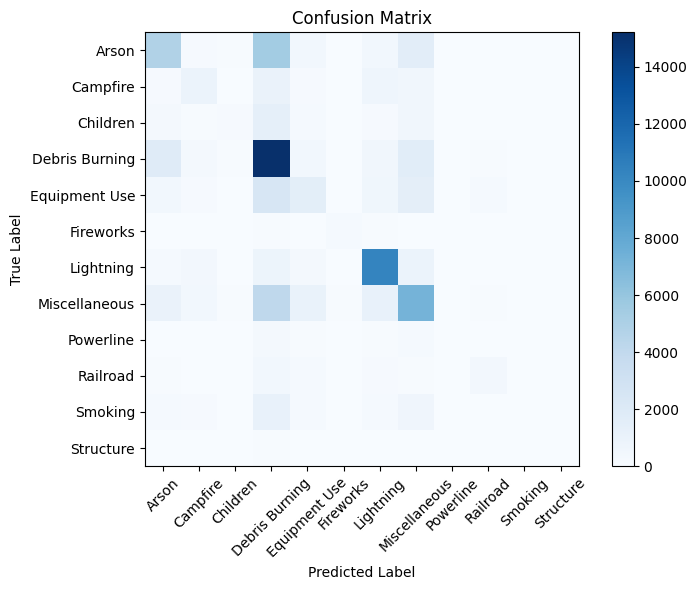

In [ ]:
history3_4 = run_model(model_3, X_val_scaled, y_val, label_encoder, 50, 256, X_train_scaled, y_train)
save_model("history3_4", history3_4)

**Prediction using dropout layers + regularization**

In [ ]:
# Define the model architecture with Dropout and L2 Regularization
model_4 = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_49 (Dense)                │ (None, 256)            │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,412 (212.55 KB)

 Trainable params: 54,412 (212.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.4074 - loss: 2.3384 - val_accuracy: 0.4449 - val_loss: 1.7005
Epoch 2/40
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4371 - loss: 1.7284 - val_accuracy: 0.4474 - val_loss: 1.6834
Epoch 3/40
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4420 - loss: 1.7157 - val_accuracy: 0.4479 - val_loss: 1.6764
Epoch 4/40
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4439 - loss: 1.7095 - val_accuracy: 0.4564 - val_loss: 1.6693
Epoch 5/40
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4426 - loss: 1.7110 - val_accuracy: 0.4556 - val_loss: 1.6695
Epoch 6/40
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4459 - loss: 1.7068 - val_accuracy: 0.4562 - val_loss: 1.6649
Epoch 7/40
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4458 - loss: 1.7058 - val_accuracy: 0.4556 - val_loss: 1.6657
Epoch 8/40
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4450 - loss: 1.7043 - 

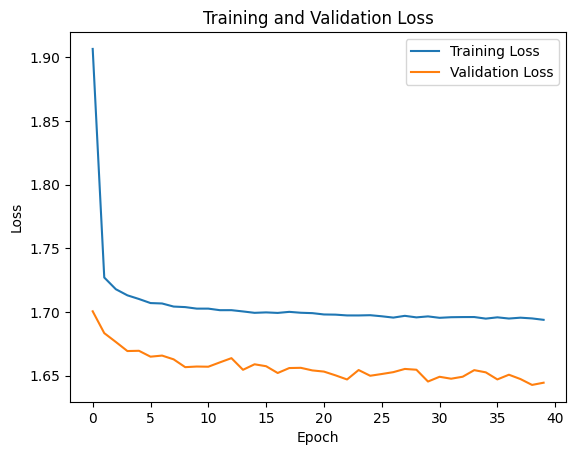

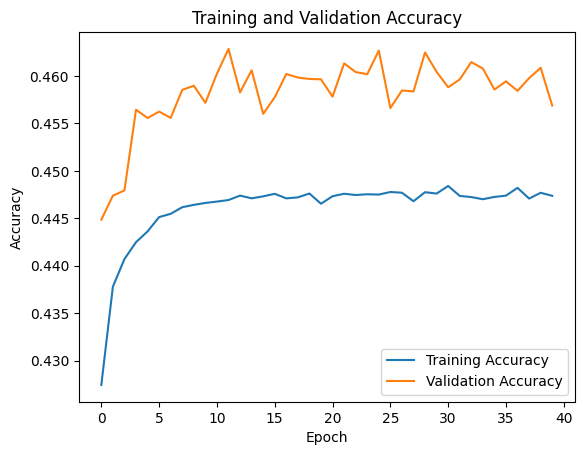

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 831us/step - accuracy: 0.4581 - loss: 1.6450
Test Loss: 1.644455909729004
Test Accuracy: 0.4568706750869751
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 847us/step
              precision    recall  f1-score   support

           0       0.47      0.27      0.34     12949
           1       0.38      0.02      0.04      3473
           2       0.00      0.00      0.00      2878
           3       0.42      0.79      0.54     20151
           4       0.35      0.06      0.10      6945
           5       0.67      0.01      0.02       538
           6       0.55      0.83      0.66     13008
           7       0.44      0.37      0.40     15217
           8       0.00      0.00      0.00       653
           9       0.41      0.18      0.25      1532
          10       0.00      0.00      0.00      2482
          11       0.00      0.00      0.00       166

    accuracy                           0.46     79992
   macro avg       0.31      0.21      0.20     79992
w

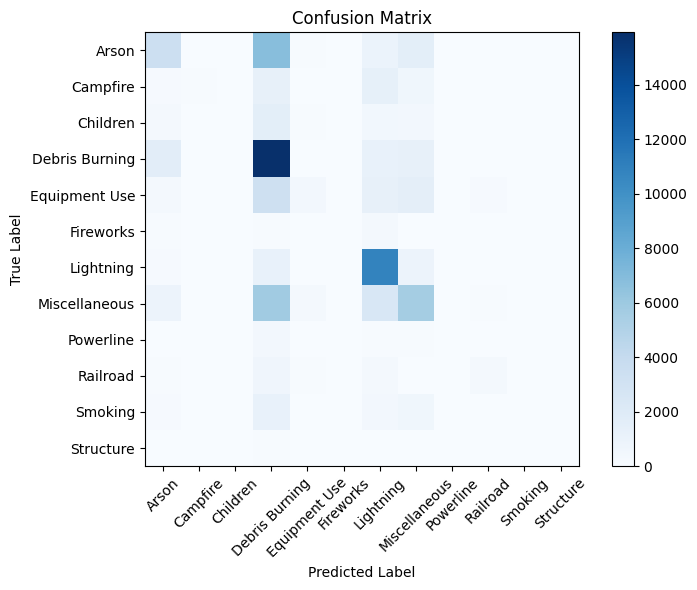

In [ ]:
history4_1 = run_model(model_4, X_val_scaled, y_val, label_encoder, 40, 128, X_train_scaled, y_train)
save_model("history4_1", history4_1)

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_52 (Dense)                │ (None, 256)            │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,412 (212.55 KB)

 Trainable params: 54,412 (212.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.3985 - loss: 2.5395 - val_accuracy: 0.4469 - val_loss: 1.6875
Epoch 2/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4377 - loss: 1.7196 - val_accuracy: 0.4500 - val_loss: 1.6755
Epoch 3/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4410 - loss: 1.7067 - val_accuracy: 0.4537 - val_loss: 1.6688
Epoch 4/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4435 - loss: 1.7008 - val_accuracy: 0.4490 - val_loss: 1.6623
Epoch 5/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4447 - loss: 1.6934 - val_accuracy: 0.4571 - val_loss: 1.6591
Epoch 6/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4494 - loss: 1.6901 - val_accuracy: 0.4556 - val_loss: 1.6546
Epoch 7/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4471 - loss: 1.6881 - val_accuracy: 0.4580 - val_loss: 1.6509
Epoch 8/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4501 - loss: 1.6831 - 

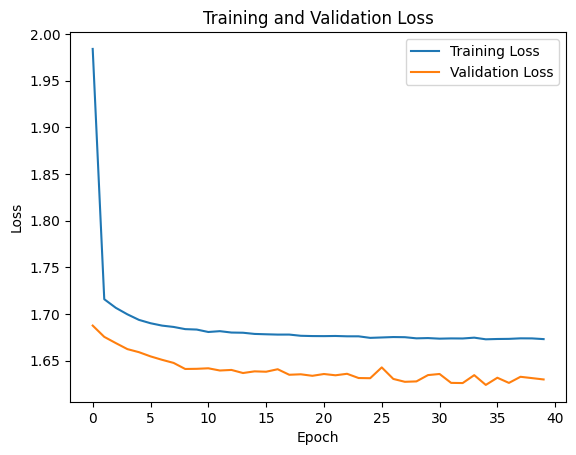

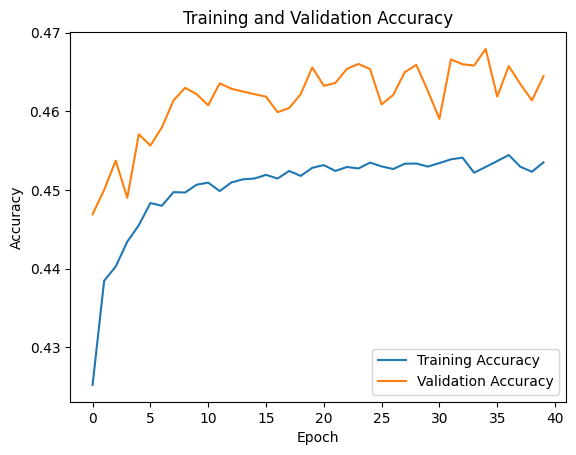

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 867us/step - accuracy: 0.4656 - loss: 1.6304
Test Loss: 1.6299313306808472
Test Accuracy: 0.4644714593887329
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 896us/step
              precision    recall  f1-score   support

           0       0.46      0.30      0.36     12949
           1       0.45      0.01      0.02      3473
           2       0.00      0.00      0.00      2878
           3       0.43      0.78      0.55     20151
           4       0.21      0.02      0.03      6945
           5       0.51      0.10      0.17       538
           6       0.58      0.81      0.68     13008
           7       0.43      0.42      0.43     15217
           8       0.00      0.00      0.00       653
           9       0.40      0.25      0.31      1532
          10       0.00      0.00      0.00      2482
          11       0.00      0.00      0.00       166

    accuracy                           0.46     79992
   macro avg       0.29      0.22      0.21     79992


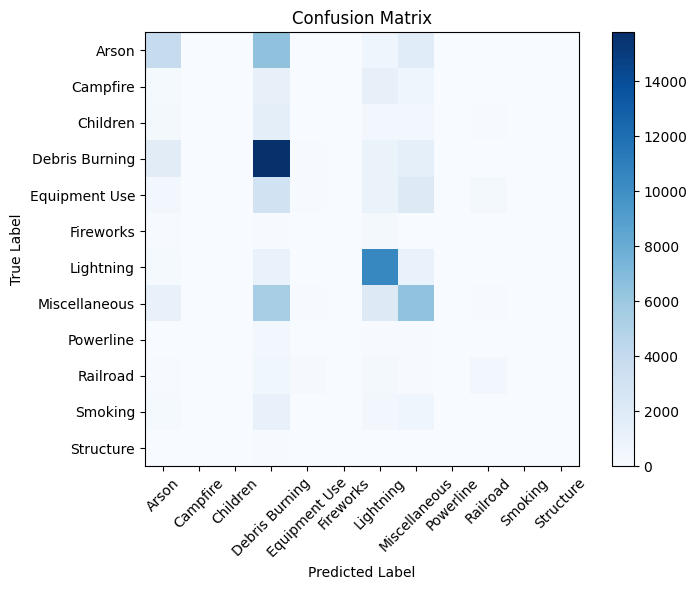

In [ ]:
history4_2 = run_model(model_4, X_val_scaled, y_val, label_encoder, 40, 256, X_train_scaled, y_train)
save_model("history4_2", history4_2)

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_55 (Dense)                │ (None, 256)            │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,412 (212.55 KB)

 Trainable params: 54,412 (212.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.4059 - loss: 2.3633 - val_accuracy: 0.4426 - val_loss: 1.6974
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4366 - loss: 1.7273 - val_accuracy: 0.4499 - val_loss: 1.6861
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4402 - loss: 1.7202 - val_accuracy: 0.4514 - val_loss: 1.6831
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4433 - loss: 1.7148 - val_accuracy: 0.4531 - val_loss: 1.6755
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4418 - loss: 1.7131 - val_accuracy: 0.4546 - val_loss: 1.6709
Epoch 6/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4421 - loss: 1.7116 - val_accuracy: 0.4553 - val_loss: 1.6727
Epoch 7/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4463 - loss: 1.7047 - val_accuracy: 0.4621 - val_loss: 1.6584
Epoch 8/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4484 - loss: 1.6994 - 

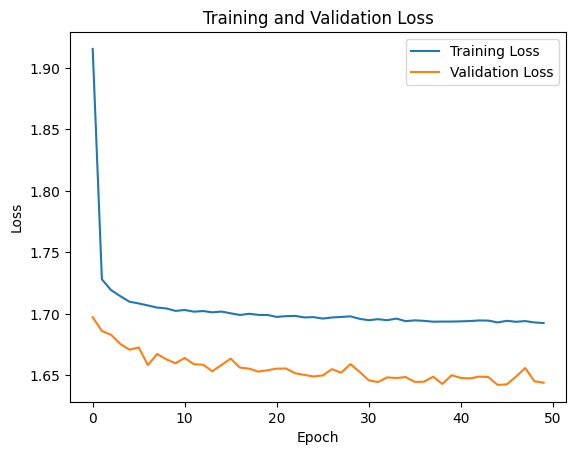

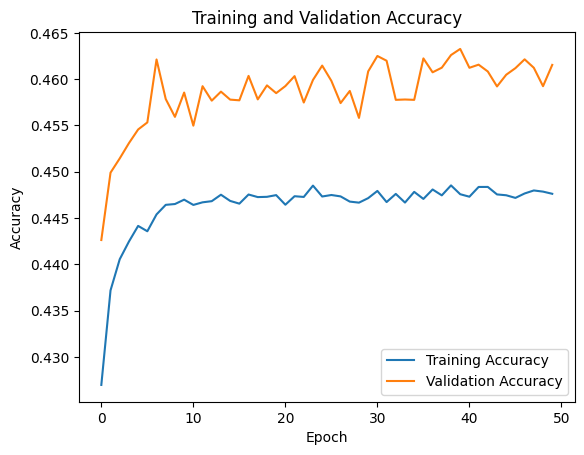

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 887us/step - accuracy: 0.4629 - loss: 1.6439
Test Loss: 1.6440261602401733
Test Accuracy: 0.46153366565704346
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 996us/step
              precision    recall  f1-score   support

           0       0.45      0.34      0.39     12949
           1       0.18      0.00      0.01      3473
           2       0.00      0.00      0.00      2878
           3       0.43      0.73      0.54     20151
           4       0.33      0.06      0.10      6945
           5       0.52      0.09      0.15       538
           6       0.57      0.82      0.67     13008
           7       0.42      0.41      0.42     15217
           8       0.00      0.00      0.00       653
           9       0.41      0.31      0.35      1532
          10       0.00      0.00      0.00      2482
          11       0.00      0.00      0.00       166

    accuracy                           0.46     79992
   macro avg       0.28      0.23      0.22     79992

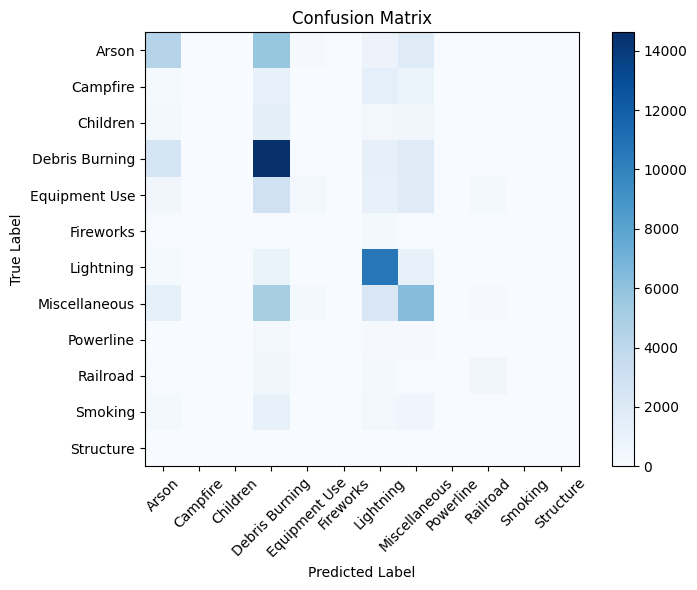

In [ ]:
history4_3 = run_model(model_4, X_val_scaled, y_val, label_encoder, 50, 128, X_train_scaled, y_train)
save_model("history4_3", history4_3)

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_58 (Dense)                │ (None, 256)            │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,412 (212.55 KB)

 Trainable params: 54,412 (212.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.3961 - loss: 2.6048 - val_accuracy: 0.4435 - val_loss: 1.6904
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4373 - loss: 1.7208 - val_accuracy: 0.4524 - val_loss: 1.6755
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4399 - loss: 1.7084 - val_accuracy: 0.4555 - val_loss: 1.6615
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4419 - loss: 1.7045 - val_accuracy: 0.4555 - val_loss: 1.6599
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4436 - loss: 1.6959 - val_accuracy: 0.4572 - val_loss: 1.6599
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4473 - loss: 1.6898 - val_accuracy: 0.4580 - val_loss: 1.6529
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4479 - loss: 1.6865 - val_accuracy: 0.4598 - val_loss: 1.6453
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4473 - loss: 1.6887 - 

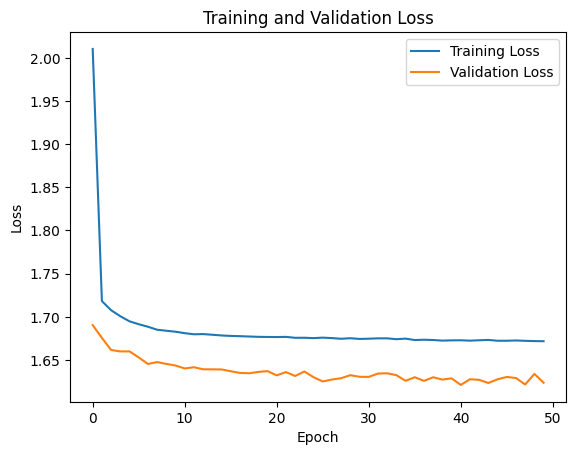

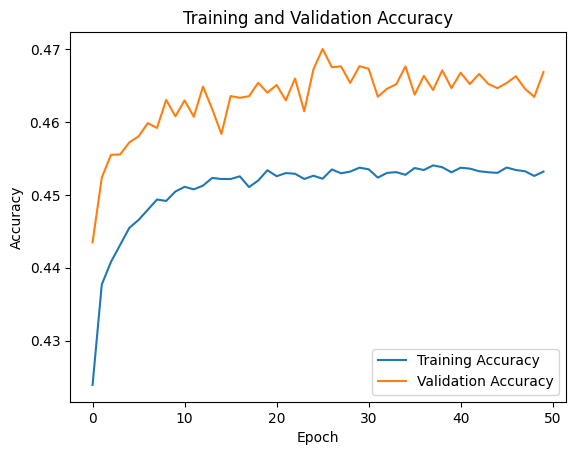

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 841us/step - accuracy: 0.4687 - loss: 1.6238
Test Loss: 1.6236779689788818
Test Accuracy: 0.46685919165611267
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 899us/step
              precision    recall  f1-score   support

           0       0.47      0.27      0.34     12949
           1       0.40      0.03      0.05      3473
           2       0.00      0.00      0.00      2878
           3       0.43      0.80      0.56     20151
           4       0.28      0.03      0.05      6945
           5       0.73      0.04      0.08       538
           6       0.58      0.82      0.68     13008
           7       0.44      0.43      0.43     15217
           8       0.00      0.00      0.00       653
           9       0.41      0.30      0.35      1532
          10       0.00      0.00      0.00      2482
          11       0.00      0.00      0.00       166

    accuracy                           0.47     79992
   macro avg       0.31      0.22      0.21     79992

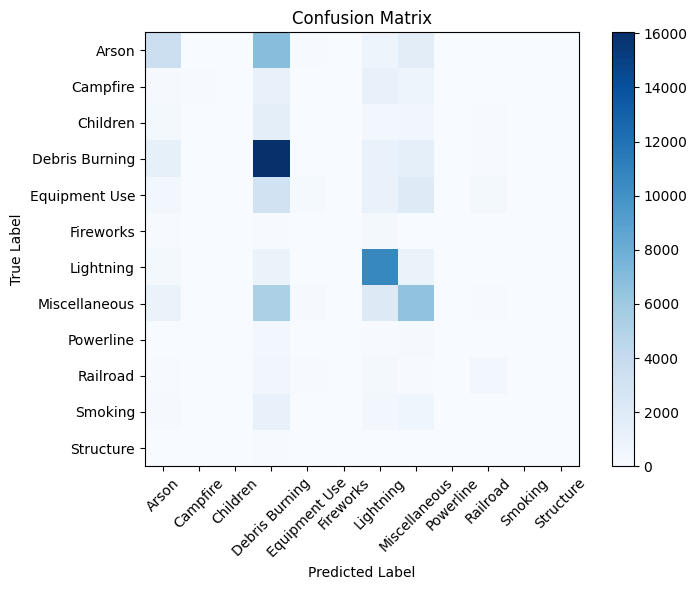

In [ ]:
history4_4 = run_model(model_4, X_val_scaled, y_val, label_encoder, 50, 256, X_train_scaled, y_train)
save_model("history4_4", history4_4)

**batch normalization**

In [ ]:
# Define the model architecture
model_5 = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(len(label_encoder.classes_), activation='softmax')
])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               19968     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 12)               

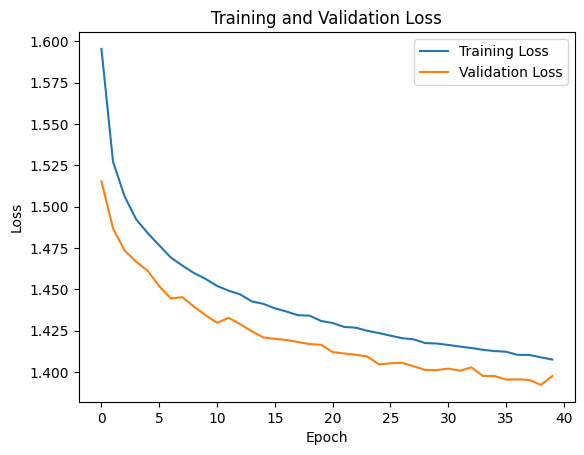

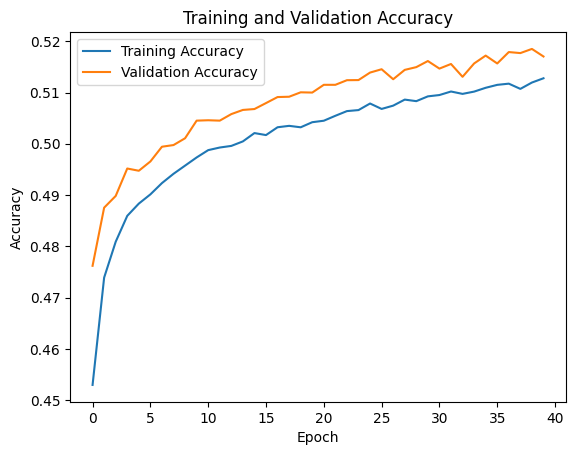

2500/2500 [==============================] - 6s 2ms/step - loss: 1.3976 - accuracy: 0.5170
Test Loss: 1.397631287574768
Test Accuracy: 0.5170267224311829
2500/2500 [==============================] - 5s 2ms/step
              precision    recall  f1-score   support

           0       0.49      0.49      0.49     12949
           1       0.43      0.19      0.26      3473
           2       0.31      0.04      0.07      2878
           3       0.48      0.70      0.57     20151
           4       0.37      0.18      0.24      6945
           5       0.51      0.33      0.40       538
           6       0.69      0.82      0.75     13008
           7       0.49      0.50      0.49     15217
           8       0.00      0.00      0.00       653
           9       0.42      0.36      0.39      1532
          10       0.33      0.00      0.00      2482
          11       0.36      0.03      0.06       166

    accuracy                           0.52     79992
   macro avg       0.41      0.

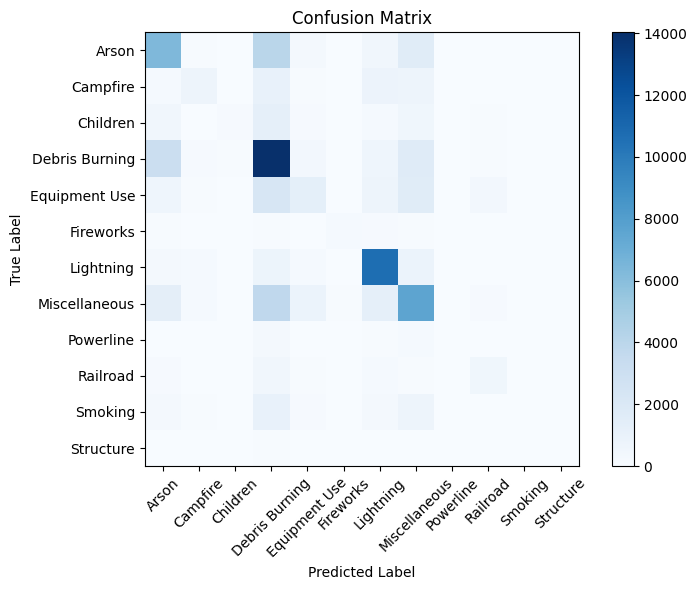

In [ ]:
history5_1 = run_model(model_5, X_val_scaled, y_val, label_encoder, 40, 128, X_train_scaled, y_train)
save_model("history5_1", history5_1)

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_65 (Dense)                │ (None, 256)            │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,204 (469.55 KB)

 Trainable params: 120,204 (469.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4269 - loss: 1.6762 - val_accuracy: 0.4728 - val_loss: 1.5238
Epoch 2/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4691 - loss: 1.5433 - val_accuracy: 0.4834 - val_loss: 1.4937
Epoch 3/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4778 - loss: 1.5127 - val_accuracy: 0.4866 - val_loss: 1.4795
Epoch 4/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4820 - loss: 1.4981 - val_accuracy: 0.4930 - val_loss: 1.4671
Epoch 5/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4868 - loss: 1.4842 - val_accuracy: 0.4955 - val_loss: 1.4575
Epoch 6/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4906 - loss: 1.4743 - val_accuracy: 0.4979 - val_loss: 1.4519
Epoch 7/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4916 - loss: 1.4706 - val_accuracy: 0.4984 - val_loss: 1.4495
Epoch 8/40
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4958 - loss: 1.4578 - 

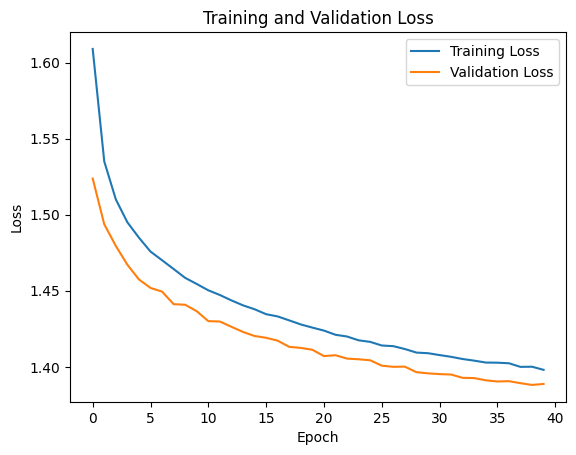

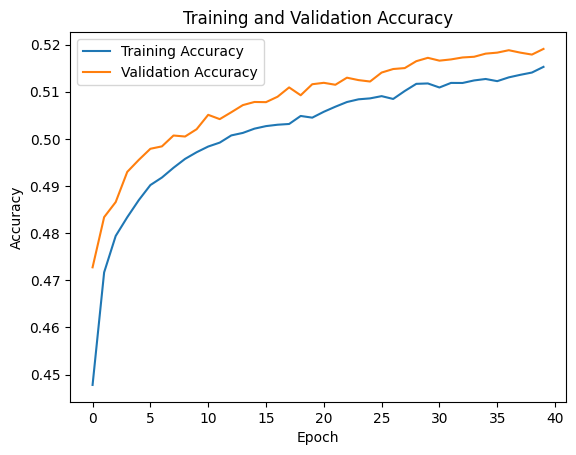

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5185 - loss: 1.3914
Test Loss: 1.3887319564819336
Test Accuracy: 0.5190768837928772
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 975us/step
              precision    recall  f1-score   support

           0       0.51      0.42      0.46     12949
           1       0.42      0.23      0.30      3473
           2       0.40      0.02      0.03      2878
           3       0.48      0.75      0.58     20151
           4       0.36      0.18      0.24      6945
           5       0.48      0.41      0.44       538
           6       0.69      0.83      0.75     13008
           7       0.49      0.49      0.49     15217
           8       0.00      0.00      0.00       653
           9       0.43      0.33      0.38      1532
          10       0.00      0.00      0.00      2482
          11       0.57      0.02      0.05       166

    accuracy                           0.52     79992
   macro avg       0.40      0.31      0.31     79992
we

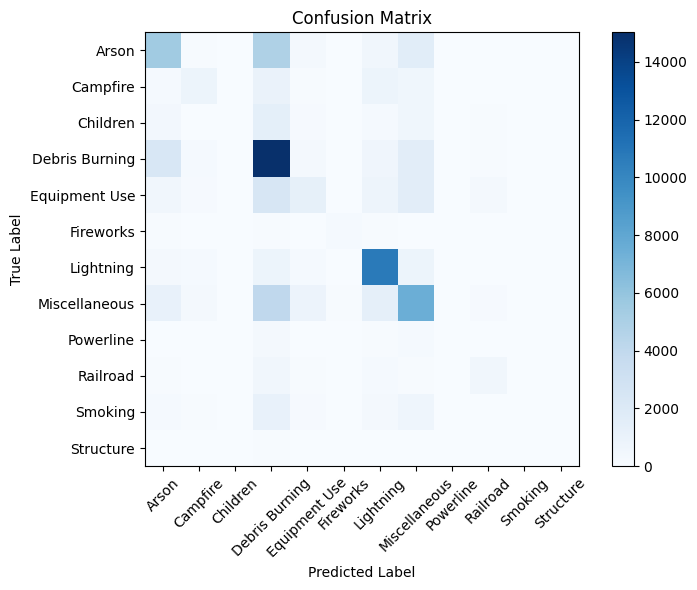

In [ ]:
history5_2 = run_model(model_5, X_val_scaled, y_val, label_encoder, 40, 256, X_train_scaled, y_train)
save_model("history5_2", history5_2)

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_69 (Dense)                │ (None, 256)            │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,204 (469.55 KB)

 Trainable params: 120,204 (469.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.4310 - loss: 1.6591 - val_accuracy: 0.4767 - val_loss: 1.5155
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4726 - loss: 1.5317 - val_accuracy: 0.4854 - val_loss: 1.4882
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4796 - loss: 1.5080 - val_accuracy: 0.4913 - val_loss: 1.4731
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4818 - loss: 1.4984 - val_accuracy: 0.4953 - val_loss: 1.4634
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4892 - loss: 1.4792 - val_accuracy: 0.4975 - val_loss: 1.4535
Epoch 6/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4910 - loss: 1.4724 - val_accuracy: 0.4978 - val_loss: 1.4509
Epoch 7/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4907 - loss: 1.4733 - val_accuracy: 0.5007 - val_loss: 1.4448
Epoch 8/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4952 - loss: 1.4615 - 

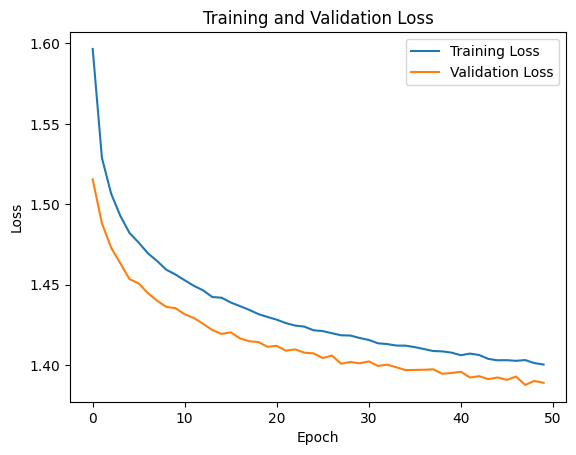

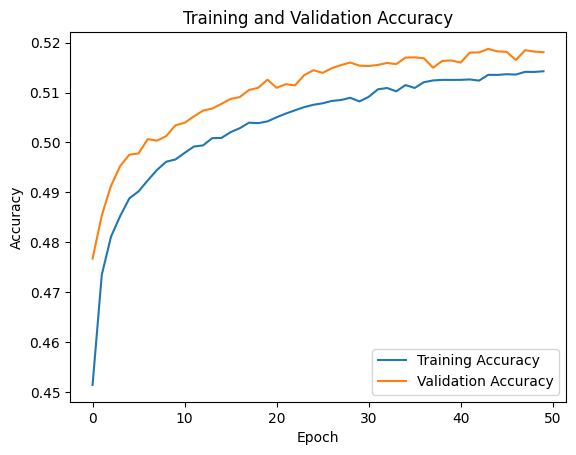

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5180 - loss: 1.3920
Test Loss: 1.3890693187713623
Test Accuracy: 0.5181018114089966
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
              precision    recall  f1-score   support

           0       0.51      0.44      0.47     12949
           1       0.39      0.26      0.31      3473
           2       0.32      0.03      0.05      2878
           3       0.48      0.73      0.58     20151
           4       0.40      0.12      0.19      6945
           5       0.48      0.37      0.42       538
           6       0.70      0.82      0.76     13008
           7       0.48      0.51      0.49     15217
           8       0.00      0.00      0.00       653
           9       0.42      0.36      0.39      1532
          10       0.40      0.00      0.00      2482
          11       0.62      0.03      0.06       166

    accuracy                           0.52     79992
   macro avg       0.43      0.31      0.31     79992
weig

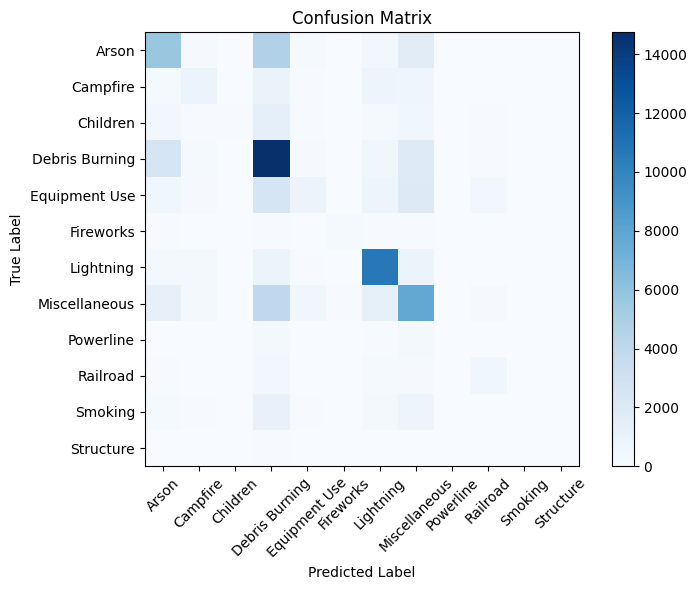

In [ ]:
history5_3 = run_model(model_5, X_val_scaled, y_val, label_encoder, 50, 128, X_train_scaled, y_train)
save_model("history5_3", history5_3)

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_73 (Dense)                │ (None, 256)            │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,204 (469.55 KB)

 Trainable params: 120,204 (469.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4251 - loss: 1.6799 - val_accuracy: 0.4731 - val_loss: 1.5277
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4688 - loss: 1.5414 - val_accuracy: 0.4835 - val_loss: 1.4928
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4779 - loss: 1.5167 - val_accuracy: 0.4882 - val_loss: 1.4812
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4833 - loss: 1.4997 - val_accuracy: 0.4920 - val_loss: 1.4669
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4869 - loss: 1.4823 - val_accuracy: 0.4935 - val_loss: 1.4607
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4904 - loss: 1.4761 - val_accuracy: 0.4964 - val_loss: 1.4542
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4931 - loss: 1.4679 - val_accuracy: 0.4966 - val_loss: 1.4500
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4928 - loss: 1.4607 - 

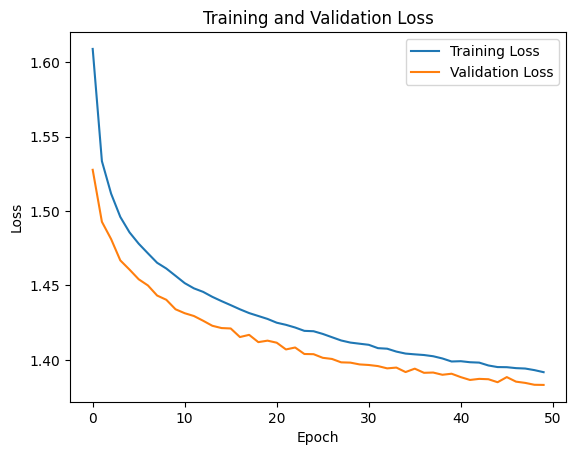

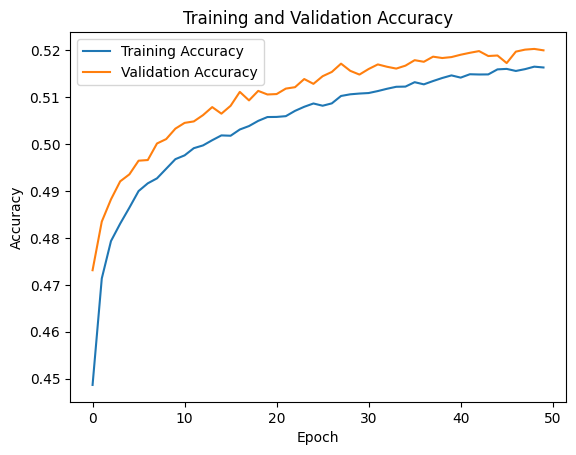

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 945us/step - accuracy: 0.5196 - loss: 1.3850
Test Loss: 1.3833003044128418
Test Accuracy: 0.5199394822120667
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 979us/step
              precision    recall  f1-score   support

           0       0.52      0.41      0.46     12949
           1       0.41      0.25      0.31      3473
           2       0.32      0.03      0.06      2878
           3       0.48      0.75      0.58     20151
           4       0.37      0.14      0.20      6945
           5       0.50      0.39      0.44       538
           6       0.71      0.81      0.76     13008
           7       0.49      0.51      0.50     15217
           8       0.00      0.00      0.00       653
           9       0.41      0.38      0.39      1532
          10       0.43      0.00      0.00      2482
          11       0.57      0.02      0.05       166

    accuracy                           0.52     79992
   macro avg       0.43      0.31      0.31     79992


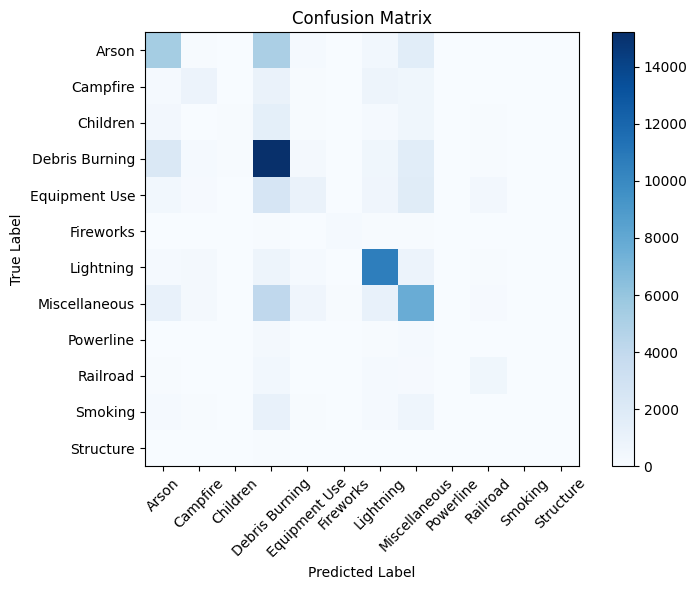

In [ ]:
history5_4 = run_model(model_5, X_val_scaled, y_val, label_encoder, 50, 256, X_train_scaled, y_train)
save_model("history5_4", history5_4)

In [ ]:
# Define the model architecture
model_6 = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 256)               19968     
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_8 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 64)               

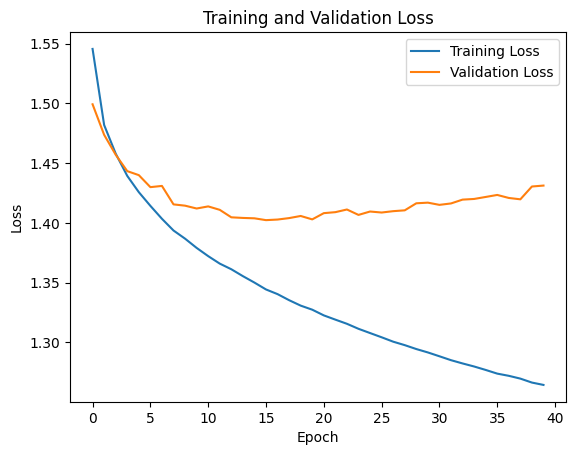

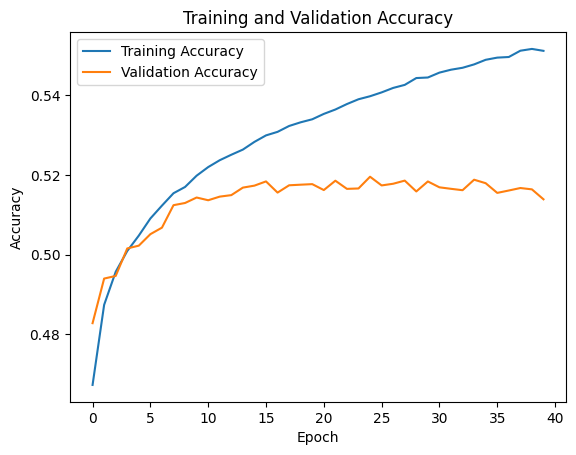

2500/2500 [==============================] - 6s 2ms/step - loss: 1.4312 - accuracy: 0.5139
Test Loss: 1.4311662912368774
Test Accuracy: 0.5138888955116272
2500/2500 [==============================] - 5s 2ms/step
              precision    recall  f1-score   support

           0       0.48      0.48      0.48     12949
           1       0.38      0.31      0.34      3473
           2       0.27      0.06      0.10      2878
           3       0.50      0.66      0.57     20151
           4       0.32      0.27      0.29      6945
           5       0.46      0.42      0.44       538
           6       0.70      0.81      0.75     13008
           7       0.50      0.47      0.48     15217
           8       0.13      0.03      0.05       653
           9       0.42      0.33      0.37      1532
          10       0.16      0.01      0.03      2482
          11       0.29      0.04      0.06       166

    accuracy                           0.51     79992
   macro avg       0.38      0

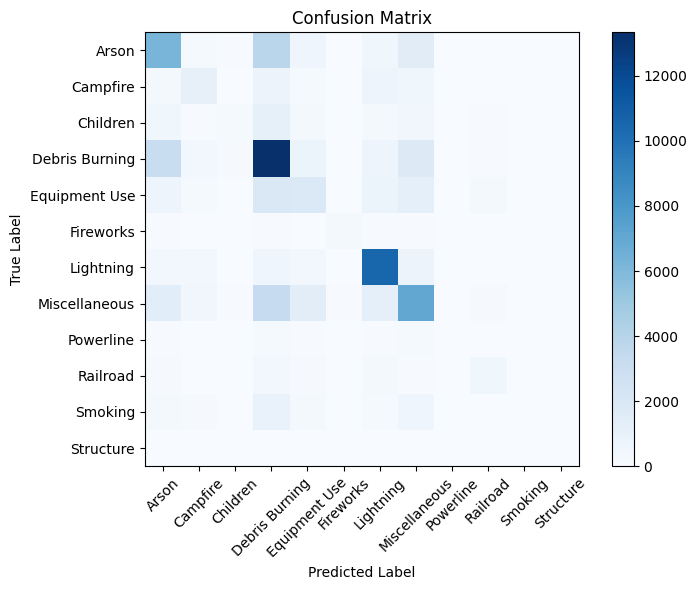

In [ ]:
history6_1 = run_model(model_6, X_val_scaled, y_val, label_encoder, 40, 128, X_train_scaled, y_train)
save_model("history6_1", history6_1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               19968     
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8

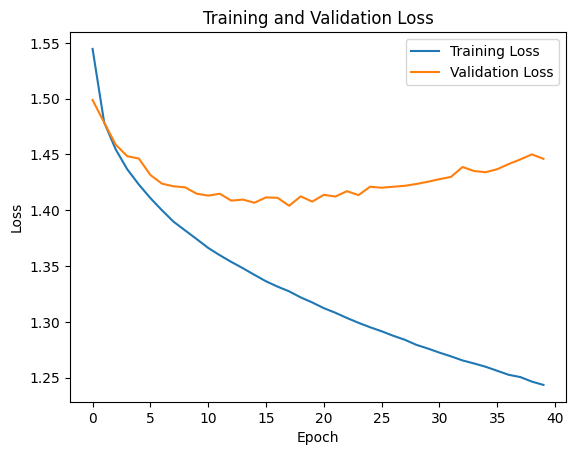

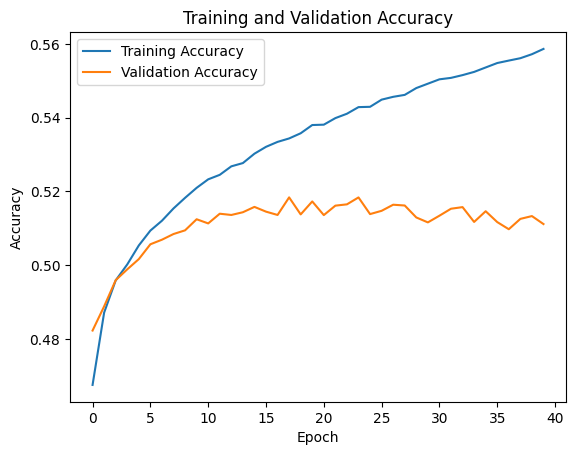

2500/2500 [==============================] - 5s 2ms/step - loss: 1.4461 - accuracy: 0.5112
Test Loss: 1.4460656642913818
Test Accuracy: 0.5111761093139648
2500/2500 [==============================] - 5s 2ms/step
              precision    recall  f1-score   support

           0       0.47      0.49      0.48     12949
           1       0.37      0.28      0.32      3473
           2       0.24      0.06      0.10      2878
           3       0.50      0.65      0.57     20151
           4       0.33      0.24      0.28      6945
           5       0.48      0.36      0.41       538
           6       0.70      0.81      0.75     13008
           7       0.49      0.48      0.48     15217
           8       0.08      0.02      0.03       653
           9       0.40      0.34      0.37      1532
          10       0.17      0.01      0.02      2482
          11       0.15      0.02      0.04       166

    accuracy                           0.51     79992
   macro avg       0.37      0

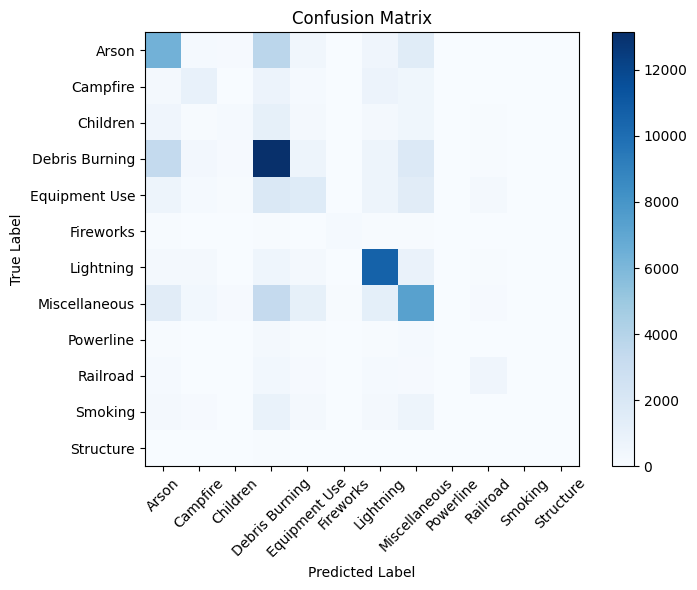

In [ ]:
history6_2 = run_model(model_6, X_val_scaled, y_val, label_encoder, 40, 256, X_train_scaled, y_train)
save_model("history6_2", history6_2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               19968     
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8

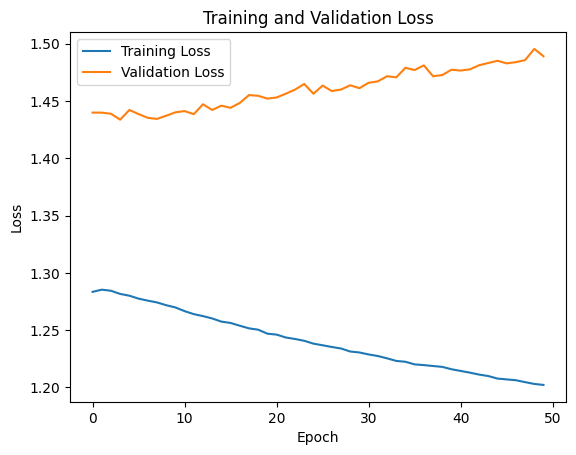

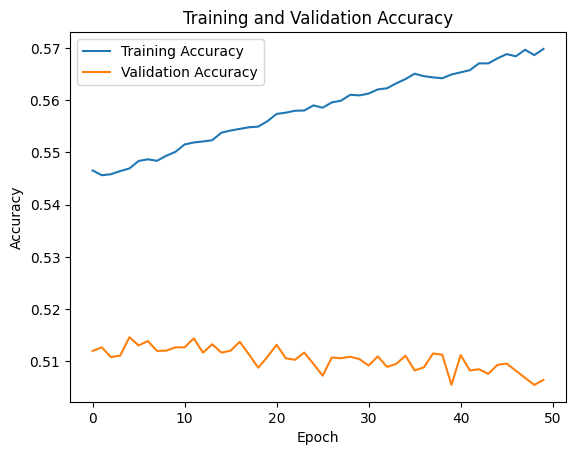

2500/2500 [==============================] - 6s 3ms/step - loss: 1.4891 - accuracy: 0.5065
Test Loss: 1.4890981912612915
Test Accuracy: 0.5064631700515747
2500/2500 [==============================] - 5s 2ms/step
              precision    recall  f1-score   support

           0       0.48      0.48      0.48     12949
           1       0.38      0.25      0.30      3473
           2       0.25      0.07      0.11      2878
           3       0.50      0.63      0.56     20151
           4       0.33      0.25      0.28      6945
           5       0.47      0.34      0.40       538
           6       0.68      0.82      0.74     13008
           7       0.47      0.49      0.48     15217
           8       0.14      0.04      0.06       653
           9       0.40      0.33      0.36      1532
          10       0.16      0.02      0.03      2482
          11       0.07      0.01      0.02       166

    accuracy                           0.51     79992
   macro avg       0.36      0

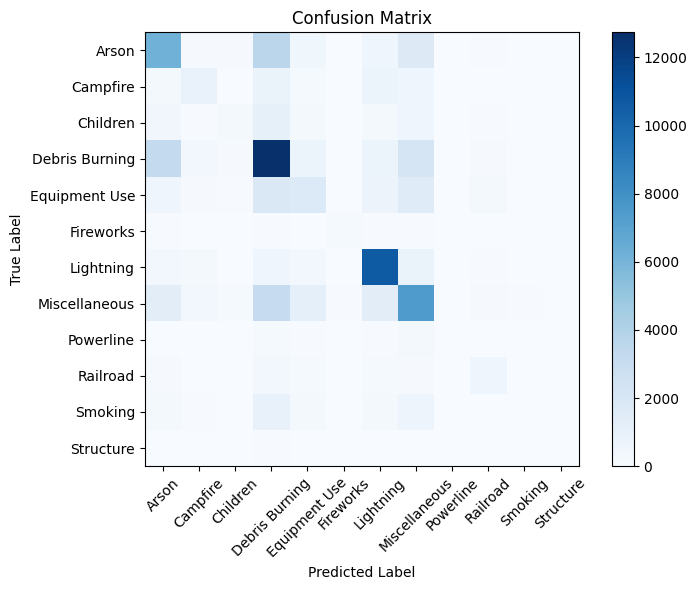

In [ ]:
history6_3 = run_model(model_6, X_val_scaled, y_val, label_encoder, 50, 128, X_train_scaled, y_train)
save_model("history6_3", history6_3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               19968     
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8

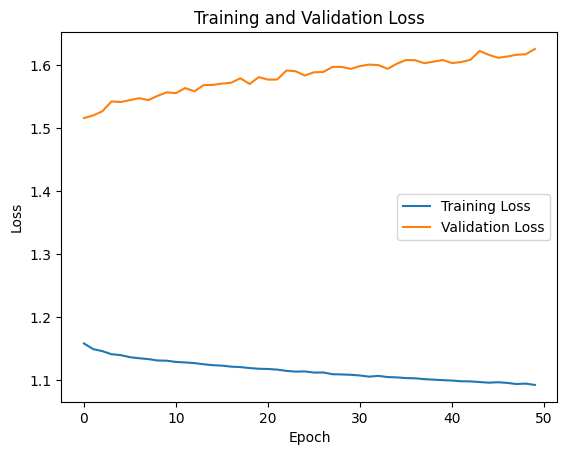

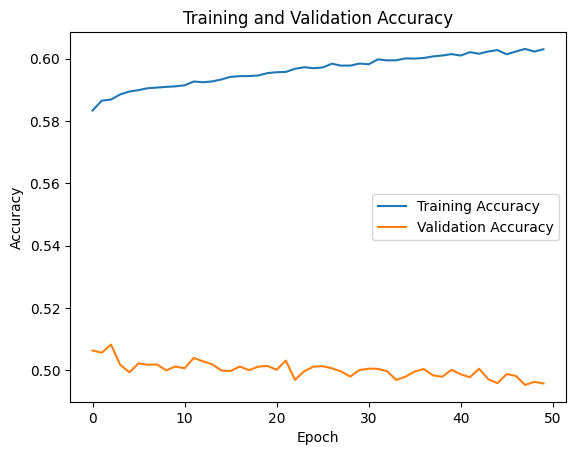

2500/2500 [==============================] - 7s 3ms/step - loss: 1.6259 - accuracy: 0.4958
Test Loss: 1.6258724927902222
Test Accuracy: 0.49583709239959717
2500/2500 [==============================] - 5s 2ms/step
              precision    recall  f1-score   support

           0       0.48      0.45      0.47     12949
           1       0.33      0.29      0.31      3473
           2       0.22      0.09      0.12      2878
           3       0.50      0.62      0.56     20151
           4       0.30      0.26      0.28      6945
           5       0.37      0.36      0.37       538
           6       0.71      0.77      0.74     13008
           7       0.46      0.48      0.47     15217
           8       0.11      0.05      0.07       653
           9       0.36      0.35      0.36      1532
          10       0.14      0.02      0.04      2482
          11       0.04      0.02      0.03       166

    accuracy                           0.50     79992
   macro avg       0.34      

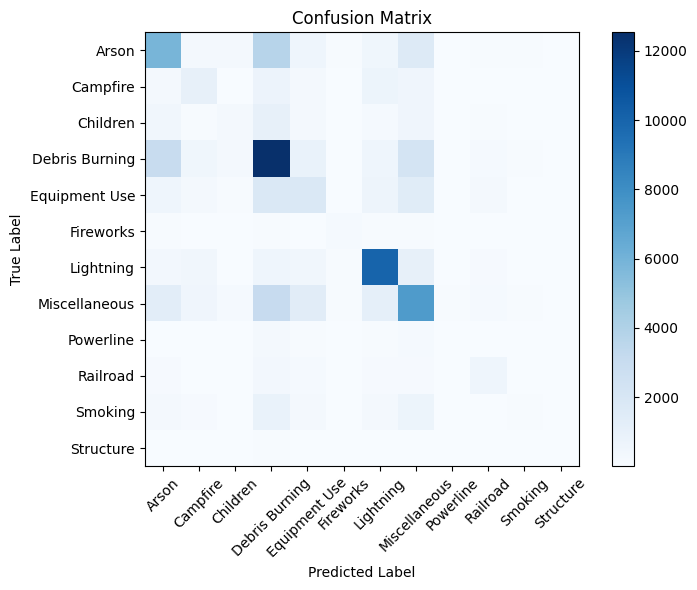

In [ ]:
history6_4 = run_model(model_6, X_val_scaled, y_val, label_encoder, 50, 256, X_train_scaled, y_train)
save_model("history6_4", history6_4)

In [ ]:
# Define the model architecture
model_7 = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               19968     
                                                                 
 batch_normalization_2 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_3 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             (None, 256)              

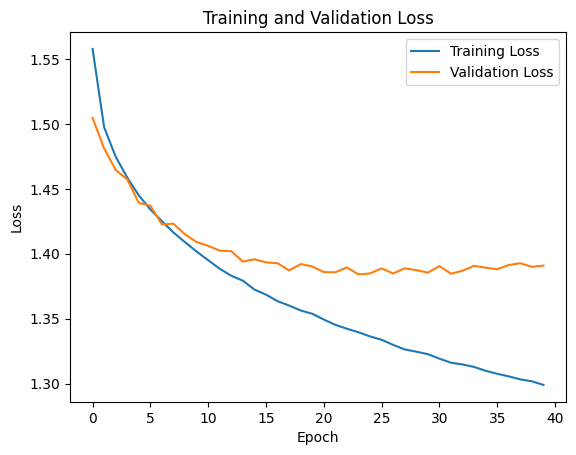

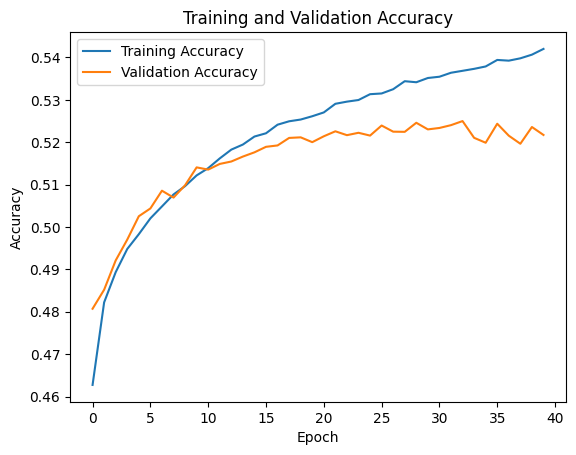

2500/2500 [==============================] - 6s 2ms/step - loss: 1.3909 - accuracy: 0.5217
Test Loss: 1.390905737876892
Test Accuracy: 0.5217146873474121
2500/2500 [==============================] - 6s 2ms/step
              precision    recall  f1-score   support

           0       0.50      0.48      0.49     12949
           1       0.44      0.25      0.32      3473
           2       0.28      0.07      0.11      2878
           3       0.49      0.72      0.58     20151
           4       0.34      0.23      0.27      6945
           5       0.52      0.33      0.41       538
           6       0.71      0.82      0.76     13008
           7       0.52      0.46      0.49     15217
           8       0.12      0.01      0.01       653
           9       0.42      0.38      0.40      1532
          10       0.20      0.01      0.03      2482
          11       0.42      0.03      0.06       166

    accuracy                           0.52     79992
   macro avg       0.41      0.

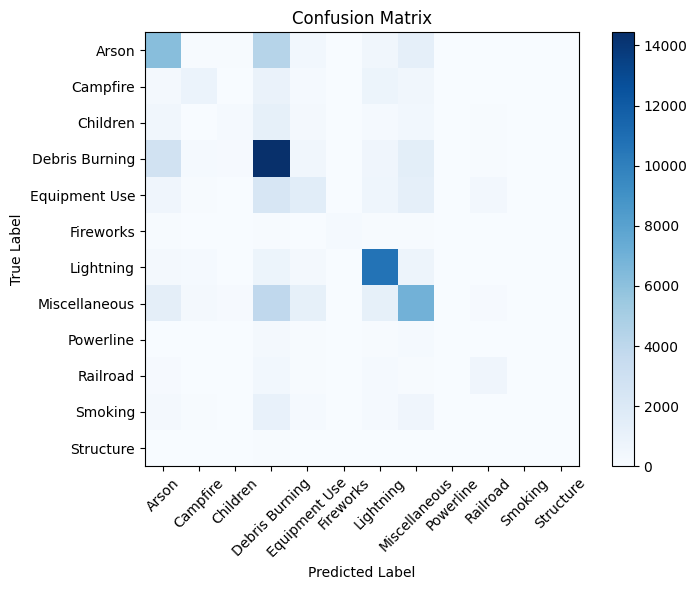

In [ ]:
history7_1 = run_model(model_7, X_val_scaled, y_val, label_encoder, 40, 128, X_train_scaled, y_train)
save_model("history7_1", history7_1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               19968     
                                                                 
 batch_normalization_2 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_3 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             (None, 256)              

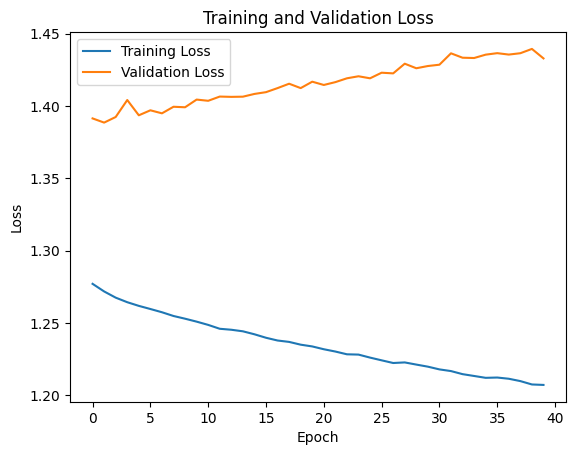

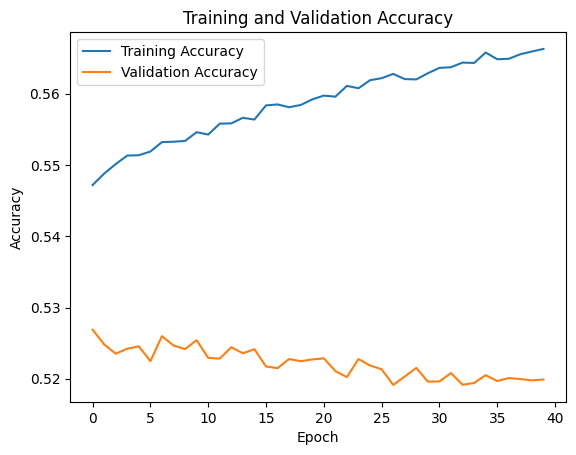

2500/2500 [==============================] - 5s 2ms/step - loss: 1.4328 - accuracy: 0.5199
Test Loss: 1.432831048965454
Test Accuracy: 0.5199019908905029
2500/2500 [==============================] - 5s 2ms/step
              precision    recall  f1-score   support

           0       0.50      0.48      0.49     12949
           1       0.40      0.27      0.32      3473
           2       0.26      0.06      0.10      2878
           3       0.51      0.67      0.58     20151
           4       0.34      0.22      0.27      6945
           5       0.50      0.36      0.42       538
           6       0.72      0.81      0.76     13008
           7       0.48      0.51      0.50     15217
           8       0.14      0.03      0.05       653
           9       0.40      0.41      0.40      1532
          10       0.16      0.01      0.02      2482
          11       0.15      0.03      0.05       166

    accuracy                           0.52     79992
   macro avg       0.38      0.

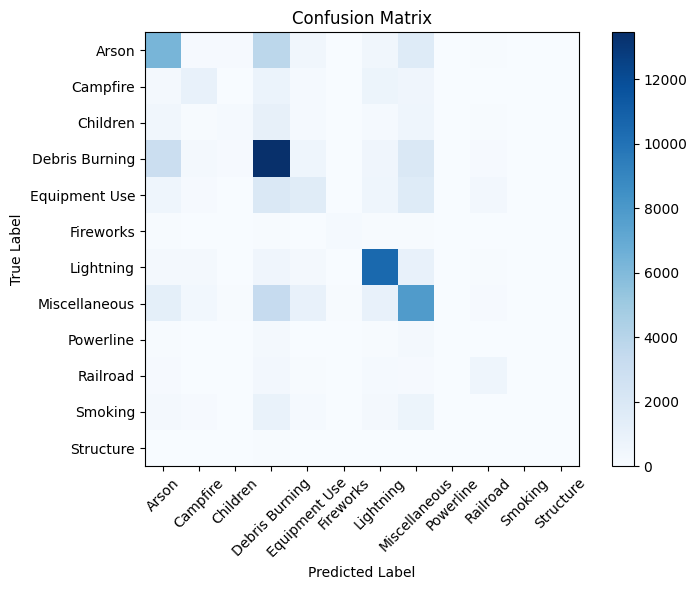

In [ ]:
history7_2 = run_model(model_7, X_val_scaled, y_val, label_encoder, 40, 256, X_train_scaled, y_train)
save_model("history7_2", history7_2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               19968     
                                                                 
 batch_normalization_2 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_3 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             (None, 256)              

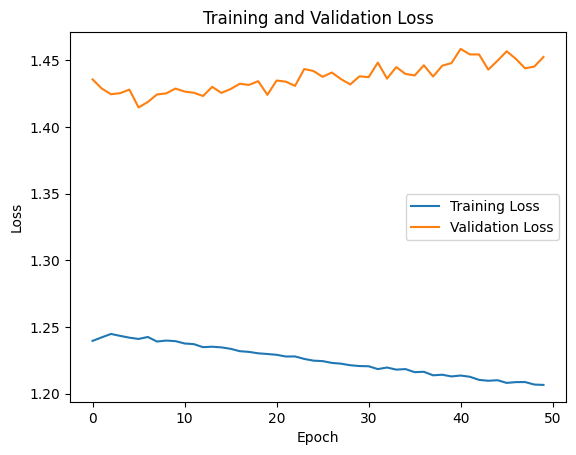

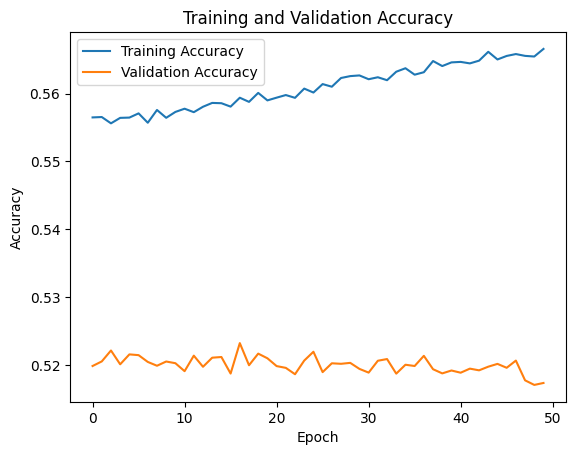

2500/2500 [==============================] - 5s 2ms/step - loss: 1.4526 - accuracy: 0.5173
Test Loss: 1.4525868892669678
Test Accuracy: 0.5173392295837402
2500/2500 [==============================] - 6s 2ms/step
              precision    recall  f1-score   support

           0       0.50      0.47      0.49     12949
           1       0.41      0.27      0.32      3473
           2       0.29      0.05      0.09      2878
           3       0.49      0.70      0.58     20151
           4       0.33      0.25      0.29      6945
           5       0.44      0.41      0.43       538
           6       0.73      0.79      0.76     13008
           7       0.50      0.47      0.49     15217
           8       0.12      0.05      0.07       653
           9       0.40      0.34      0.37      1532
          10       0.16      0.02      0.03      2482
          11       0.25      0.04      0.06       166

    accuracy                           0.52     79992
   macro avg       0.39      0

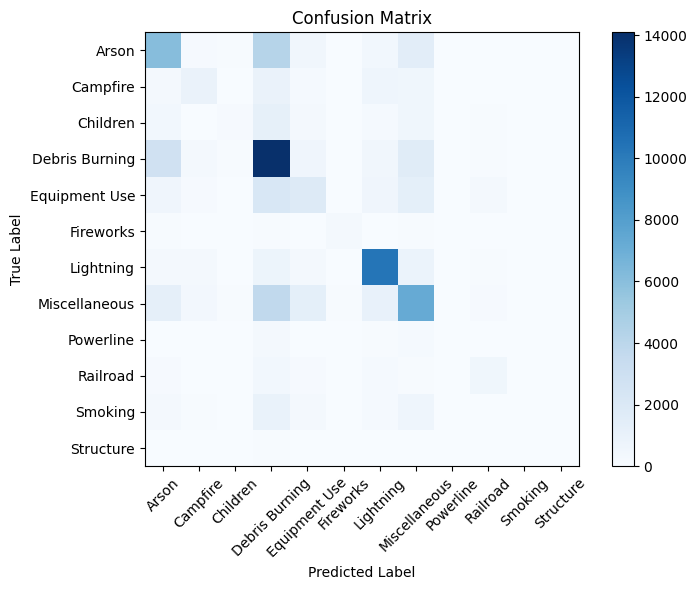

In [ ]:
history7_3 = run_model(model_7, X_val_scaled, y_val, label_encoder, 50, 128, X_train_scaled, y_train)
save_model("history7_3", history7_3)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               19968     
                                                                 
 batch_normalization_2 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_3 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             (None, 256)              

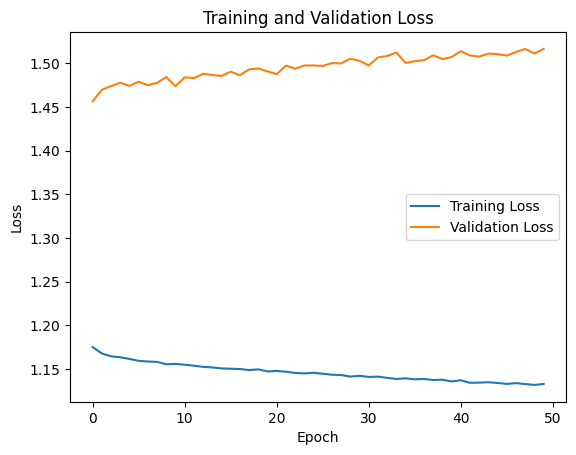

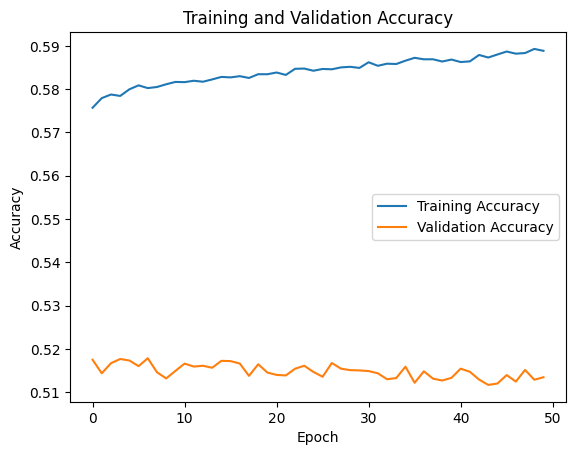

2500/2500 [==============================] - 5s 2ms/step - loss: 1.5165 - accuracy: 0.5135
Test Loss: 1.5164695978164673
Test Accuracy: 0.5134638547897339
2500/2500 [==============================] - 6s 3ms/step
              precision    recall  f1-score   support

           0       0.49      0.49      0.49     12949
           1       0.37      0.31      0.34      3473
           2       0.24      0.09      0.13      2878
           3       0.50      0.66      0.57     20151
           4       0.32      0.23      0.27      6945
           5       0.48      0.38      0.43       538
           6       0.73      0.79      0.76     13008
           7       0.49      0.48      0.49     15217
           8       0.18      0.06      0.09       653
           9       0.39      0.39      0.39      1532
          10       0.17      0.03      0.05      2482
          11       0.19      0.06      0.09       166

    accuracy                           0.51     79992
   macro avg       0.38      0

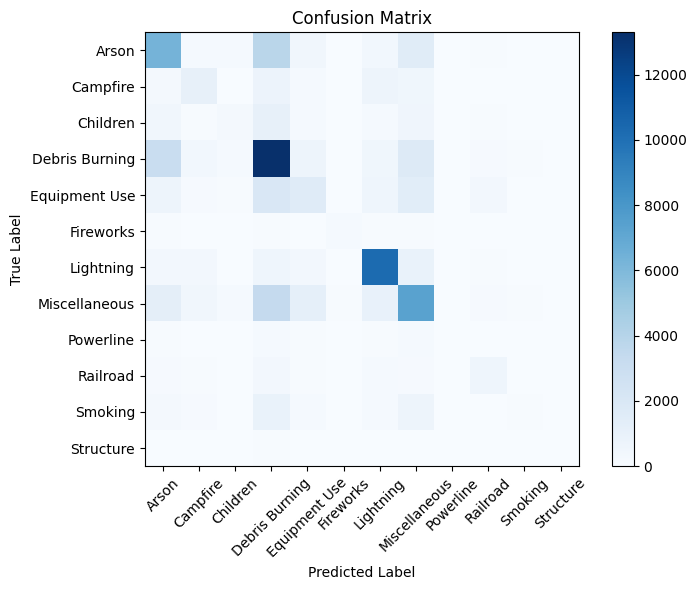

In [ ]:
history7_4 = run_model(model_7, X_val_scaled, y_val, label_encoder, 50, 256, X_train_scaled, y_train)
save_model("history7_4", history7_4)

grid search

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving history7_4.pkl to history7_4 (1).pkl
Saving history7_3.pkl to history7_3 (1).pkl
Saving history6_2.pkl to history6_2 (1).pkl
Saving history7_2.pkl to history7_2 (1).pkl
Saving history7_1.pkl to history7_1 (1).pkl
Saving history6_4.pkl to history6_4 (1).pkl
Saving history6_3.pkl to history6_3 (1).pkl
Saving history6_1.pkl to history6_1.pkl
Saving history5_1.pkl to history5_1.pkl
Saving history1_1.pkl to history1_1.pkl
Saving history1_3.pkl to history1_3.pkl
Saving history4_3.pkl to history4_3.pkl
Saving history5_4.pkl to history5_4.pkl
Saving history3_1.pkl to history3_1.pkl
Saving history1_2.pkl to history1_2.pkl
Saving history1_4.pkl to history1_4.pkl
Saving history2_3.pkl to history2_3.pkl
Saving history2_4.pkl to history2_4.pkl
Saving history2_1.pkl to history2_1.pkl
Saving history4_4.pkl to history4_4.pkl
Saving history3_3.pkl to history3_3.pkl
Saving history4_2.pkl to history4_2.pkl
Saving history3_4.pkl to history3_4.pkl
Saving history4_1.pkl to history4_1.pkl
Saving histo

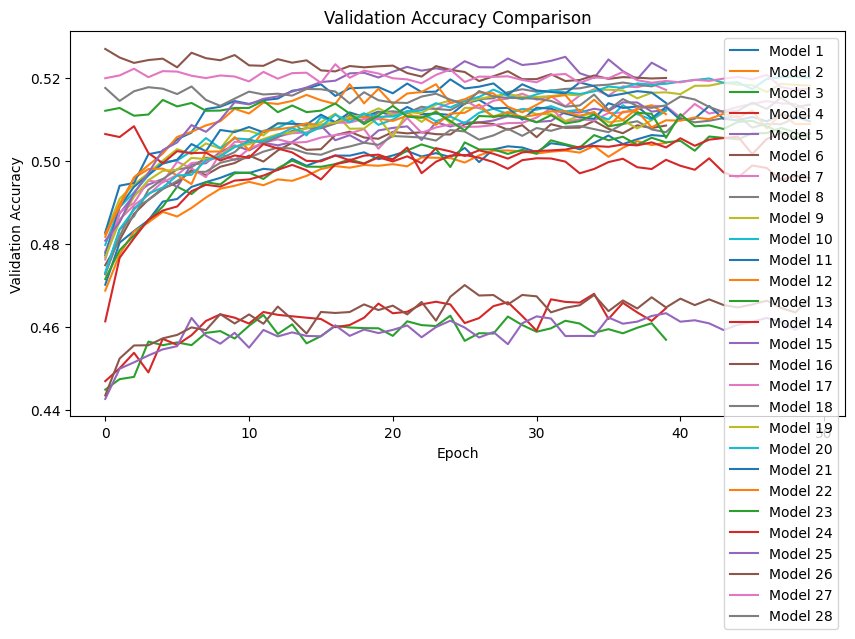

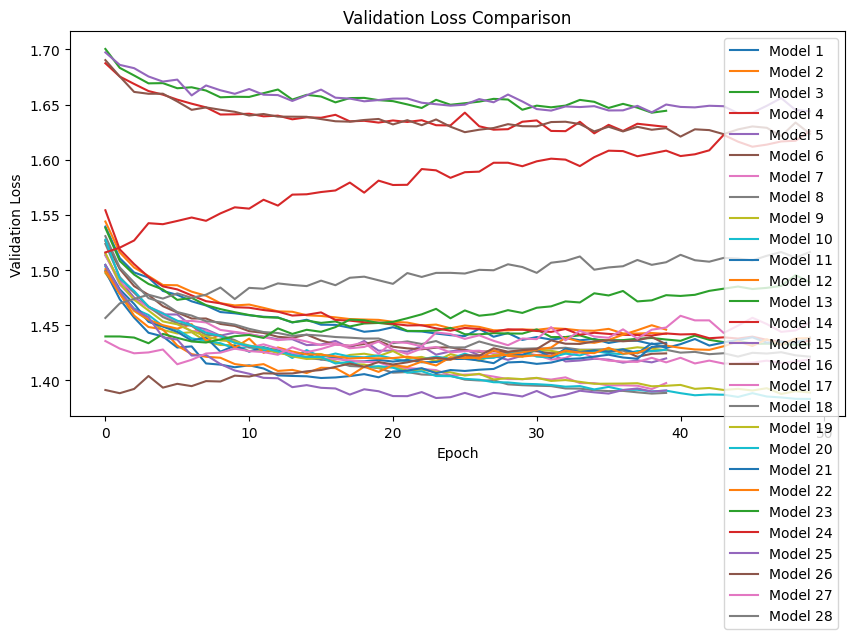

Top three models based on combined score:
Model: Model 26
   - Average Validation Accuracy: 0.5221372127532959
   - Average Validation Loss: 1.4156558364629745
   - Combined Score: 0.013334116935730056

Model: Model 27
   - Average Validation Accuracy: 0.5200102484226227
   - Average Validation Loss: 1.436823537349701
   - Combined Score: 0.012270634770393418

Model: Model 25
   - Average Validation Accuracy: 0.5157468900084495
   - Average Validation Loss: 1.404223084449768
   - Combined Score: 0.01013895556330685



In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Load history from pickle files
history_files = ['history1_1.pkl','history1_2.pkl','history1_3.pkl','history1_4.pkl',
                 'history2_1.pkl','history2_2.pkl','history2_3.pkl','history2_4.pkl',
                 'history3_1.pkl','history3_2.pkl','history3_3.pkl','history3_4.pkl',
                 'history4_1.pkl','history4_2.pkl','history4_3.pkl','history4_4.pkl',
                 'history5_1.pkl','history5_2.pkl','history5_3.pkl','history5_4.pkl',
                 'history6_1.pkl','history6_2.pkl','history6_3.pkl','history6_4.pkl',
                 'history7_1.pkl','history7_2.pkl','history7_3.pkl','history7_4.pkl',]

histories = []
for file in history_files:
    with open(file, 'rb') as f:
        history = pickle.load(f)
        histories.append(history)

# Extract relevant metrics
metrics = {}
for i, history in enumerate(histories):
    model_name = f"Model {i + 1}"
    metrics[model_name] = {
        'val_accuracy': history['val_accuracy'],
        'val_loss': history['val_loss']
    }

# Calculate average validation accuracy and loss for each model
average_val_accuracy = {model_name: np.mean(metric['val_accuracy']) for model_name, metric in metrics.items()}
average_val_loss = {model_name: np.mean(metric['val_loss']) for model_name, metric in metrics.items()}

# Combine average validation accuracy and loss into a single score
combined_score = {model_name: (avg_accuracy + (1 - avg_loss)) / 2
                  for model_name, avg_accuracy in average_val_accuracy.items()
                  for avg_loss in average_val_loss.values()}

# Sort models based on combined score
sorted_models = sorted(combined_score.items(), key=lambda x: x[1], reverse=True)

# Select the top three models
top_three_models = sorted_models[:3]

# Visualize results
plt.figure(figsize=(10, 5))
for model_name, metric in metrics.items():
    plt.plot(metric['val_accuracy'], label=model_name)

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.legend()
plt.show()

# Visualize validation loss
plt.figure(figsize=(10, 5))
for model_name, metric in metrics.items():
    plt.plot(metric['val_loss'], label=model_name)

plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.legend()
plt.show()

# Print the top three models along with their individual scores and combined score
print("Top three models based on combined score:")
for model_name, combined_score in top_three_models:
    avg_accuracy = average_val_accuracy[model_name]
    avg_loss = average_val_loss[model_name]
    print(f"Model: {model_name}")
    print(f"   - Average Validation Accuracy: {avg_accuracy}")
    print(f"   - Average Validation Loss: {avg_loss}")
    print(f"   - Combined Score: {combined_score}\n")


In [ ]:
test.head()

FIRE_YEAR  DISCOVERY_TIME    CONT_TIME FIRE_SIZE_CLASS   LATITUDE  \
0       1999     1800.000000  1900.000000               A  33.645000   
1       2003     1200.000000  1215.000000               B  47.984200   
2       2012       25.000000  1559.000000               B  39.068847   
3       2011     1454.582282  1632.270339               A  34.080247   
4       2000     1501.253188  1608.553512               B  33.716700   

    LONGITUDE STATE  FIPS_CODE  IS_LEAP_YEAR  DURATION_IN_DAYS  \
0 -117.356667    CA       58.0             0          1.000000   
1  -98.907600    ND       53.0             0          1.000000   
2  -81.498694    WV      105.0             1          1.000000   
3 -101.322098    TX      153.0             0          3.905005   
4  -80.000000    SC       46.0             1          3.905005   

   IS_DISCOVERY_DATE_US_HOLIDAY  HighTempMonth  LowTempMonth  PrecMonth  \
0                             0           23.5           8.7        2.9   
1                             0           12.6           0.0        3.8   
2                             1           12.2           0.3        7.8   
3                             0           26.4          12.3        7.2   
4                             0           18.9           5.5        8.1   

   DISCOVERY_DOY_SIN  DISCOVERY_DOY_COS  DISCOVERY_MONTH_SIN  \
0          -0.970064           0.242850            -0.866025   
1          -0.951057           0.309017            -0.866025   
2          -0.756771           0.653680            -0.500000   
3          -0.998435           0.055917            -0.866025   
4          -0.745438           0.666575            -0.500000   

   DISCOVERY_MONTH_COS  DISCOVERY_DOW_SIN  DISCOVERY_DOW_COS  
0             0.500000          -0.433884          -0.900969  
1             0.500000          -0.781831           0.623490  
2             0.866025          -0.781831           0.623490  
3             0.500000           0.781831           0.623490  
4             0.866025          -0.781831           0.623490

In [ ]:
def evaluate_models(model, X_test_scaled, y_test):
    # for model_name, model in models.items():
        # Evaluate the model on the test set
    loss, accuracy = model.evaluate(X_test_scaled, y_test)
    print(f'Model: {model}')
    print(f'Test Loss: {loss}')
    print(f'Test Accuracy: {accuracy}')
    print()

In [ ]:
# Define features and target variable
X = test

X = pd.get_dummies(test, columns=test.select_dtypes(include=['object']).columns)

# Convert target variable to numerical labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(test_y)

# Standardize features (optional but recommended for neural networks)
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X)

In [ ]:
# Define the model architecture
model_7 = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 256)               19968     
                                                                 
 batch_normalization_11 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_24 (Dense)            (None, 256)               65792     
                                                                 
 batch_normalization_12 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dense_25 (Dense)            (None, 256)              

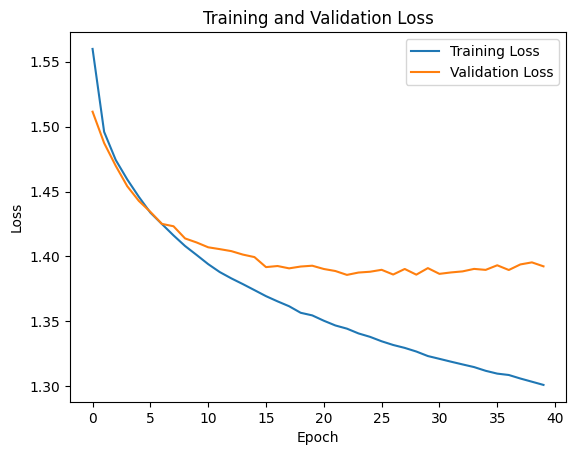

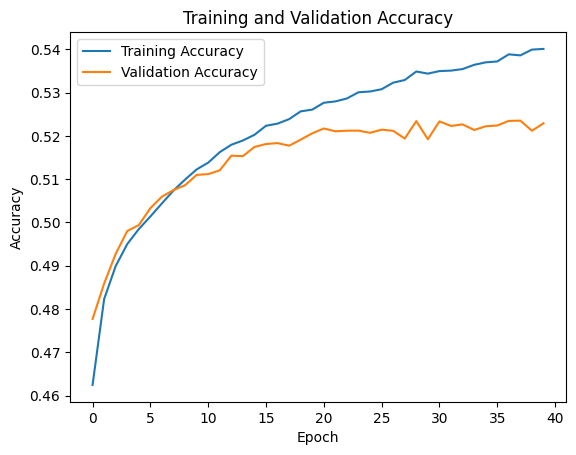

2500/2500 [==============================] - 5s 2ms/step - loss: 1.3924 - accuracy: 0.5229
Test Loss: 1.3923588991165161
Test Accuracy: 0.5229023098945618
2500/2500 [==============================] - 6s 2ms/step
              precision    recall  f1-score   support

           0       0.50      0.49      0.49     12949
           1       0.42      0.26      0.32      3473
           2       0.31      0.05      0.09      2878
           3       0.49      0.70      0.58     20151
           4       0.36      0.21      0.26      6945
           5       0.46      0.41      0.43       538
           6       0.69      0.83      0.76     13008
           7       0.51      0.48      0.49     15217
           8       0.10      0.01      0.01       653
           9       0.42      0.38      0.40      1532
          10       0.22      0.01      0.03      2482
          11       0.24      0.03      0.05       166

    accuracy                           0.52     79992
   macro avg       0.39      0

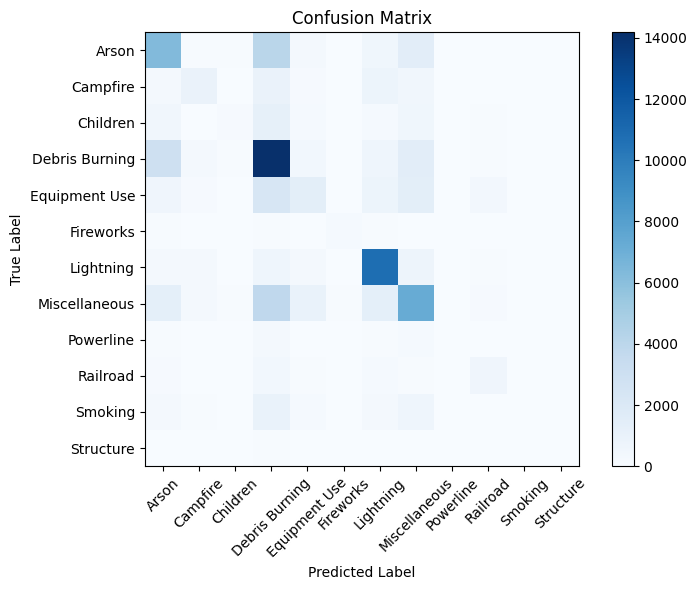

In [ ]:
history7_1 = run_model(model_7, X_val_scaled, y_val, label_encoder, 40, 128, X_train_scaled, y_train)
save_model("final_model_history7_1", history7_1)

In [ ]:
evaluate_models(model_7, X_test_scaled, y_encoded)

3572/3572 [==============================] - 9s 2ms/step - loss: 1.4068 - accuracy: 0.5184
Model: <keras.src.engine.sequential.Sequential object at 0x77fff4d4a2c0>
Test Loss: 1.4067862033843994
Test Accuracy: 0.5183969736099243



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 256)               19968     
                                                                 
 batch_normalization_11 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_24 (Dense)            (None, 256)               65792     
                                                                 
 batch_normalization_12 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dense_25 (Dense)            (None, 256)              

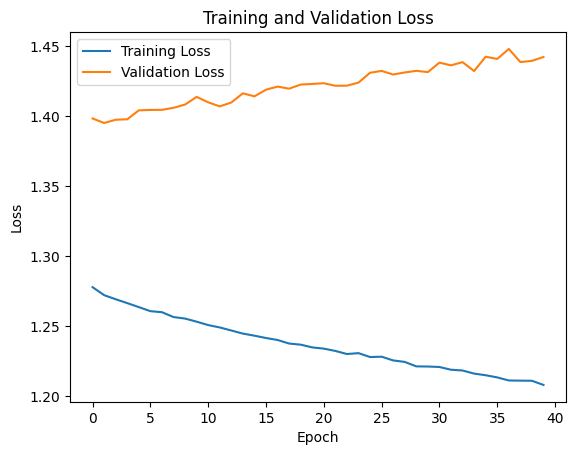

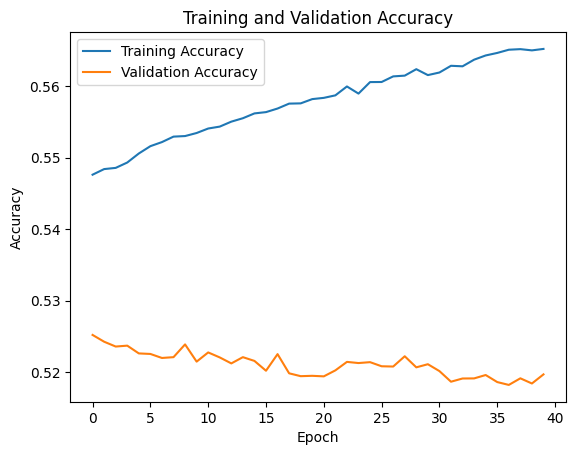

2500/2500 [==============================] - 6s 2ms/step - loss: 1.4423 - accuracy: 0.5197
Test Loss: 1.4422568082809448
Test Accuracy: 0.5196519494056702
2500/2500 [==============================] - 6s 3ms/step
              precision    recall  f1-score   support

           0       0.51      0.45      0.48     12949
           1       0.41      0.27      0.33      3473
           2       0.28      0.07      0.11      2878
           3       0.50      0.71      0.58     20151
           4       0.33      0.22      0.27      6945
           5       0.50      0.38      0.44       538
           6       0.72      0.80      0.76     13008
           7       0.49      0.49      0.49     15217
           8       0.14      0.04      0.06       653
           9       0.41      0.38      0.39      1532
          10       0.20      0.02      0.03      2482
          11       0.10      0.03      0.05       166

    accuracy                           0.52     79992
   macro avg       0.38      0

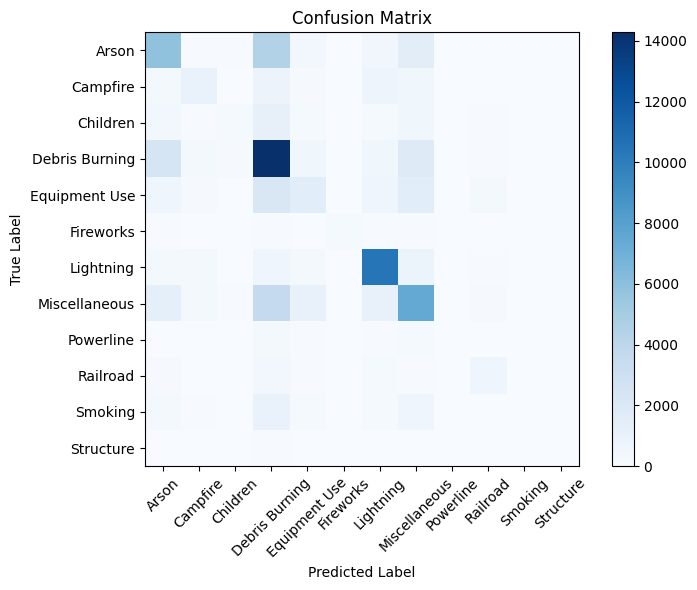

In [ ]:
history7_2 = run_model(model_7, X_val_scaled, y_val, label_encoder, 40, 256, X_train_scaled, y_train)
save_model("final_model_history7_2", history7_2)

In [ ]:
evaluate_models(model_7, X_test_scaled,y_encoded)

3572/3572 [==============================] - 9s 2ms/step - loss: 1.4638 - accuracy: 0.5126
Model: <keras.src.engine.sequential.Sequential object at 0x77fff4d4a2c0>
Test Loss: 1.4637997150421143
Test Accuracy: 0.5125694274902344



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 256)               19968     
                                                                 
 batch_normalization_11 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_24 (Dense)            (None, 256)               65792     
                                                                 
 batch_normalization_12 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dense_25 (Dense)            (None, 256)              

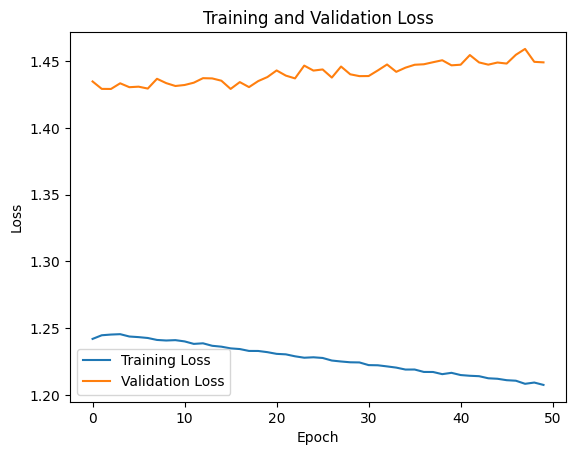

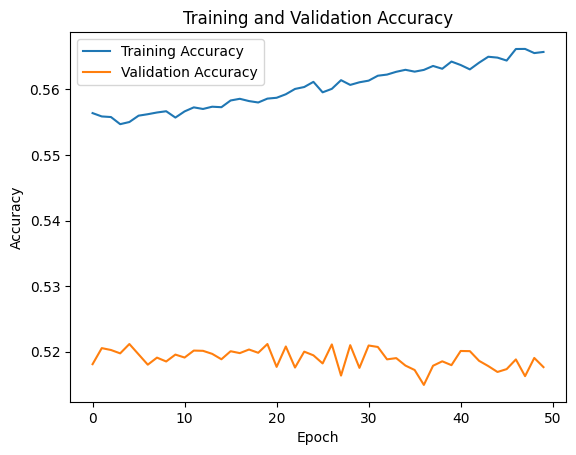

2500/2500 [==============================] - 6s 2ms/step - loss: 1.4492 - accuracy: 0.5176
Test Loss: 1.4491713047027588
Test Accuracy: 0.5176392793655396
2500/2500 [==============================] - 6s 2ms/step
              precision    recall  f1-score   support

           0       0.50      0.48      0.49     12949
           1       0.40      0.29      0.34      3473
           2       0.25      0.10      0.14      2878
           3       0.49      0.69      0.58     20151
           4       0.33      0.26      0.29      6945
           5       0.51      0.38      0.44       538
           6       0.73      0.79      0.76     13008
           7       0.50      0.47      0.48     15217
           8       0.14      0.04      0.07       653
           9       0.42      0.35      0.38      1532
          10       0.16      0.02      0.03      2482
          11       0.14      0.04      0.06       166

    accuracy                           0.52     79992
   macro avg       0.38      0

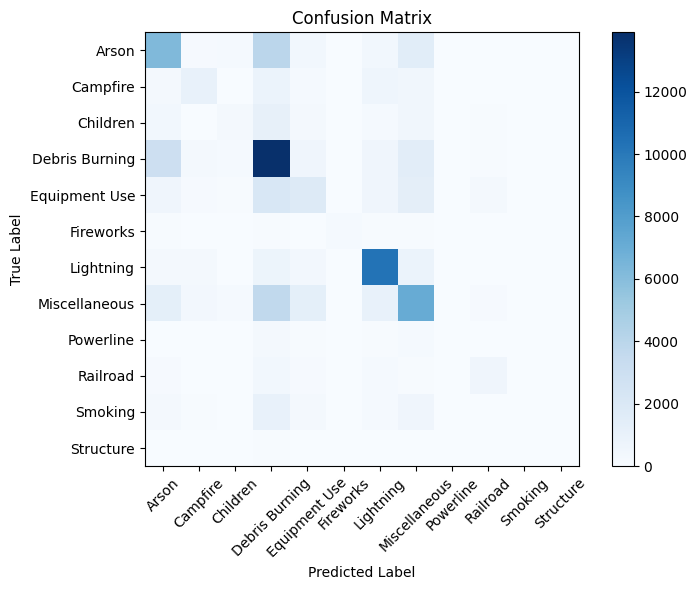

In [ ]:
history7_3 = run_model(model_7, X_val_scaled, y_val, label_encoder, 50, 128, X_train_scaled, y_train)
save_model("final_model_history7_3", history7_3)

In [ ]:
evaluate_models(model_7, X_test_scaled,y_encoded)

3572/3572 [==============================] - 7s 2ms/step - loss: 1.4757 - accuracy: 0.5075
Model: <keras.src.engine.sequential.Sequential object at 0x77fff4d4a2c0>
Test Loss: 1.4756616353988647
Test Accuracy: 0.5074769258499146



Evaluate test models

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving final_model_history7_3.pkl to final_model_history7_3 (1).pkl
Saving final_model_history7_2.pkl to final_model_history7_2 (1).pkl
Saving final_model_history7_1.pkl to final_model_history7_1 (1).pkl


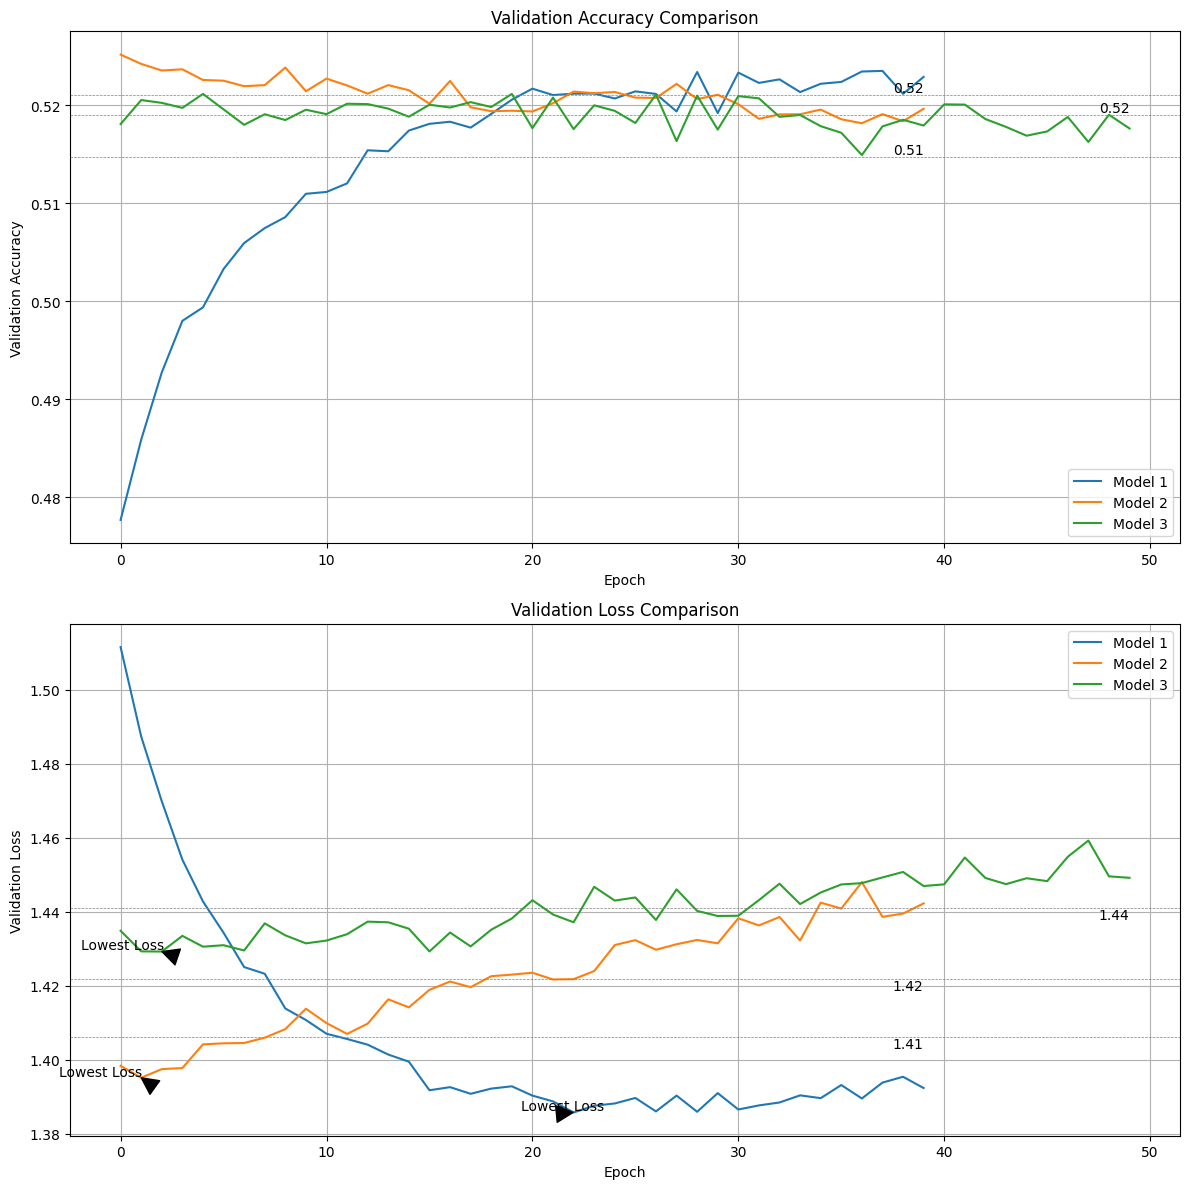

In [ ]:
# Load history from pickle files
history_files = ['final_model_history7_1.pkl', 'final_model_history7_2.pkl', 'final_model_history7_3.pkl']

histories = []
for file in history_files:
    with open(file, 'rb') as f:
        history = pickle.load(f)
        histories.append(history)

# Extract relevant metrics and calculate averages
metrics = {}
for i, history in enumerate(histories):
    model_name = f"Model {i + 1}"
    metrics[model_name] = {
        'val_accuracy': history['val_accuracy'],
        'val_loss': history['val_loss']
    }

# Visualization setup
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
axes = axes.flatten()  # Flatten if using more than one row

# Visualize validation accuracy
for model_name, metric in metrics.items():
    axes[0].plot(metric['val_accuracy'], label=model_name)
    mean_val_acc = np.mean(metric['val_accuracy'])
    axes[0].axhline(y=mean_val_acc, color='gray', linestyle='--', linewidth=0.5)
    axes[0].text(len(metric['val_accuracy']) - 1, mean_val_acc, f'{mean_val_acc:.2f}', verticalalignment='bottom', horizontalalignment='right')

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Validation Accuracy')
axes[0].set_title('Validation Accuracy Comparison')
axes[0].legend()
axes[0].grid(True)

# Visualize validation loss
for model_name, metric in metrics.items():
    axes[1].plot(metric['val_loss'], label=model_name)
    mean_val_loss = np.mean(metric['val_loss'])
    axes[1].axhline(y=mean_val_loss, color='gray', linestyle='--', linewidth=0.5)
    axes[1].text(len(metric['val_loss']) - 1, mean_val_loss, f'{mean_val_loss:.2f}', verticalalignment='top', horizontalalignment='right')

    # Annotate the lowest loss point
    min_loss_epoch = np.argmin(metric['val_loss'])
    min_loss = np.min(metric['val_loss'])
    axes[1].annotate('Lowest Loss', xy=(min_loss_epoch, min_loss), xytext=(min_loss_epoch, min_loss + 0.05),
                     textcoords="offset points", xycoords='data',
                     arrowprops=dict(facecolor='black', shrink=0.05), horizontalalignment='right')

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Validation Loss Comparison')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


**Production of Model**

In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def load_model(path_to_model):
    """
    Loads a pickle model from the specified path.
    """
    with open(path_to_model, 'rb') as file:
        model = pickle.load(file)
    return model

def load_data(path_to_data):
    """
    Loads data from a CSV file and returns features
    """
    df = pd.read_csv(path_to_data)
    X = df.drop(columns=['STAT_CAUSE_DESCR'])
    y = df['STAT_CAUSE_DESCR']
    return X, y

def preprocess_data(X):
    X = pd.get_dummies(test, columns=test.select_dtypes(include=['object']).columns)

  # Convert target variable to numerical labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(test_y)

  # Standardize features (optional but recommended for neural networks)

    return X_scaled,y_encoded

def evaluate_model(model, X, y):
    """
    Evaluates the model on the provided data.
    """
    predictions = model.predict(X)
    accuracy = np.mean(predictions == y)
    return accuracy

if __name__ == "__main__":
    path_to_model = '/content/drive/My Drive/Colab Notebooks/ML final project/Final project/final_model_history7_1.pkl'
    path_to_data = 'data.csv'  # Path to your dataset file

    # Load the model
    model = load_model(path_to_model)

    # Load and preprocess the data
    X, y = load_data(path_to_data)
    X_processed,y_processed = preprocess_data(X)

    # Evaluate the model
    accuracy = evaluate_model(model, X_processed, y_processed)
    print(f'Model Accuracy: {accuracy}')
